<a href="https://colab.research.google.com/github/Sigurdur-Ragan-Steinsson/Character-Reconigtion-Project/blob/main/Handwritten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HANDWRITTEN digits recognition (MNIST dataset)

The goal of this notebook is to train and tune a neural networks 
on the data-set MNIST (digits from 0 to 9). 
#![](MnistExamples.png)

## Learning Objectives

1. Understand the basics of classification and accuracy by testing _your_ neural net (i.e., your brain)
2. Practice estimating what will be hard problems for a computer to learn
3. Learn how to build and train a neural net classifier
4. Learn to tune a neural net classifier

## Expectations for end presentation

On the last day we will ask groups to give a presentation. You will be expected to present the following:

- How accurate was each member of your group at classifying numbers using their brains?
- Did everyone agree on what digits would be difficult for a computer? Did everyone agree on what examples would be difficult for a computer?
- Give details on the different network configurations that you tried and the accuracies that they achieved.  What was the best accuracy that you achieved?
- Were your guesses about which digits and which examples would be hard for the computer to learn correct?

## Setup

These cells import python modules that allow us to build our neural net. They also load data and produce special objects that will help us with the rest of this demo. It is not important that you understand what is happening in this section, but if you are curious, you can ask one of the camp staff.

### import modules; set up data and classes
![](SciUML-im.jpg)

In [ ]:
#
# imports
#

# this makes scroll boxes a bit larger
from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

!pip install transformers
#!pip -q install transformers


import numpy as np
import torch
#import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

!pip install livelossplot

from livelossplot import PlotLosses
from collections import UserDict


#
# load data
#

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('MNIST', download=True, train=True, transform=transform)
valset = datasets.MNIST('MNIST', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)
dataloaders = {
    "train": trainloader,
    "validation": testloader
}

#
# define some convenient classes to interact with the data in the notebook
#

class _Digits(UserDict):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def random(self):
        d = np.random.randint(0,10)
        e = np.random.randint(0, len(self[d]))
        return d,e
    def check_brain_accuracy(self):
        print('\n\n+++ Type what digit you see and type "done" if you are done +++\n\n')
        score = []
        while True:
            d,e = self.random()
            print("currently viewing sample %d" % len(score))
            self[d][e].show()
            guess = input()
            if guess == "done":
                break
            if int(guess) == int(d):
                score.append(1)
            else:
                score.append(0)
        print ("your accuracy is %.1f percent" % (100. * sum(score) / len(score)))
    def show(self, k = 0):
        for n, d in enumerate(self[k]):
            print("Example %d" % n)
            d.show()
    def find_mistakes(self, model, k = 0):
        num = 0
        for n, d in enumerate(self[k]):
            ans = d.evaluate_model(model)
            if ans != k:
                print ("I thought example %d was a %d" % (n, ans))
                d.show()
                num += 1
        print ("misclassified %.1f percent" % (100. * num / len(self[k])))


        
class _Digit(object):
    def __init__(self, inp, label):
        self.inp = inp
        self.label = label
    def show(self):
        plt.imshow(self.inp[0].numpy().squeeze(), cmap='gray_r')
        plt.show()
    def evaluate_model(self, model, device = "cpu"):
        model.to(device)
        self.inp.to(device)
        this_input = self.inp.view(self.inp.shape[0], -1)
        this_input.to(device)
        out = model(this_input)[0,:]
        out = out.detach().numpy()
        # FIXME FIXME FIXME Simon is this correct? How do I find the best classified digit?
        ans = np.argmax(out)
        return ans
    def check_model(self, model, device = "cpu"):
        ans = self.evaluate_model(model, device)
        print("I think that this is %d" % ans)
        self.show()


    
Digits = _Digits()
for inputs, labels in dataloaders['validation']:
    for i, label in enumerate(labels):
        key = int(label)
        Digits.setdefault(key, []).append(_Digit(inputs[i:i+1,:,:,:], labels[i:i+1]))

#
# Define a function to train the model
#

def train_model(model, criterion, optimizer, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.view(inputs.shape[0], -1)
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs)
        liveloss.send()

# Setup CUDA 
# FIXME!! Will this spread out GPU usage on average?
device = torch.device('cuda:%d' % np.random.randint(0,4))
print (device)
input_size = 784 # can this be gotten from the data?
output_size = 10 # can this be gotten from the data?

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda:0


## Exercise 1: How accurate is _your_ neural net? (i.e., your brain)

**THIS EXCERSISE SHOULD BE DONE INDIVIDUALLY**

**TIME ESTIMATE: 20 minutes**

In this exercise we will evaluate how accurate you are at identifying these handwritten digits.  You can think of your brain as a machine that has been trained over the last 10+ years to identify written language. Your training has primarily been through supervised learning where you have access to the correct answer and can validate your response.  


The data you have loaded can be visualized using the "Digits" object you can access a sequence of writing samples for digits 0 through 9 by evaluating Digits[digit][sequence number]. digit can be any number from 0 to 9 and sequence number can be any number through 800.  For example, the first example of an 8 is:

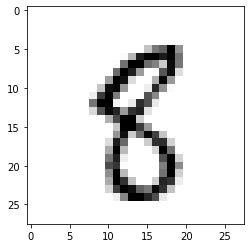

In [ ]:
Digits[8][0].show()

and the **fourth** (remember that python starts counting at 0) example of a 2 is:

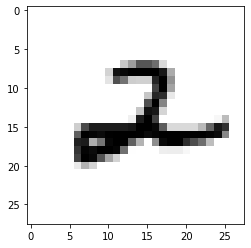

In [ ]:
Digits[2][3].show()

In the interactive example below, you will be asked to randomly identify digits and you will be given a score at the end that indicates your accuracy.  The **best** computer acheives 99.8% accuracy. If you want to beat the computer, you will need to look at 1000 samples and not miss more than 1.  



+++ Type what digit you see and type "done" if you are done +++


currently viewing sample 0


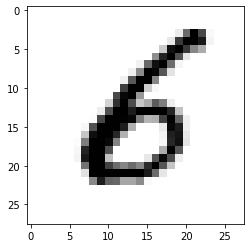

6
currently viewing sample 1


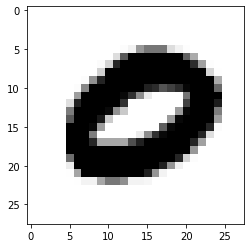

done
your accuracy is 100.0 percent


In [ ]:
Digits.check_brain_accuracy()

## Exercise 2: Which digits do you think would be hard for a computer to learn?

**THIS EXERCISE SHOULD BE DONE INDIVIDUALLY**

**TIME ESTIMATE: 30 minutes**

In this exercise we want to you reason which digits would be hard for a computer to learn.  

Question: Of the handwritten digits 0-9, which do you think would be most confusing for a computer? Would a computer be more likely to misidentify a 1 as a 2 or a 0 as a 1?

Next, pick the digit that you think is hardest to learn and iterate over all of the images. Take note of the ones that are problematic in your opinion by writing down the example number. We will compare this later. **NOTE:** change the 0 below to your digit if you didn't choose 0.

Example 0


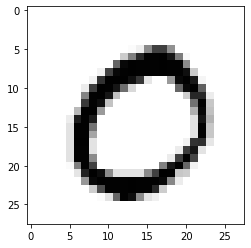

Example 1


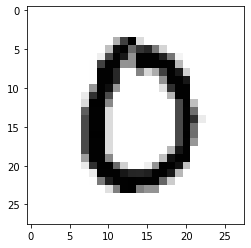

Example 2


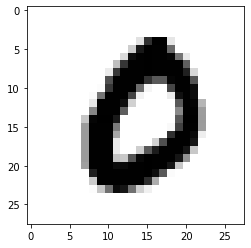

Example 3


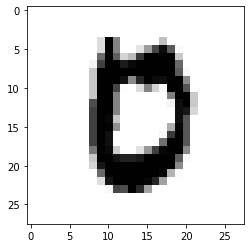

Example 4


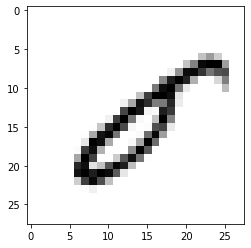

Example 5


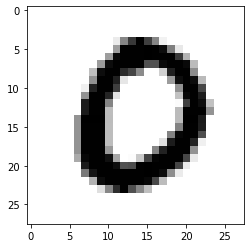

Example 6


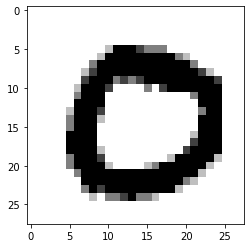

Example 7


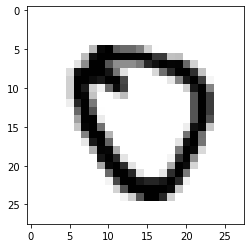

Example 8


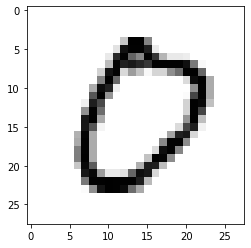

Example 9


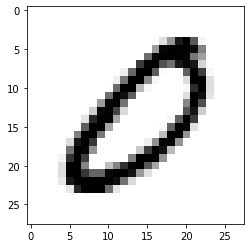

Example 10


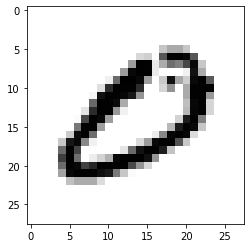

Example 11


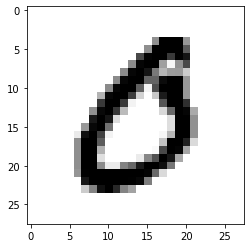

Example 12


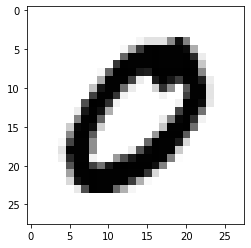

Example 13


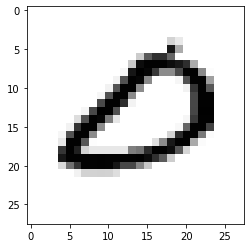

Example 14


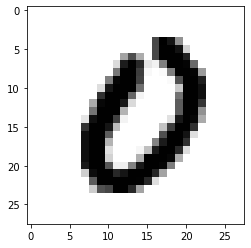

Example 15


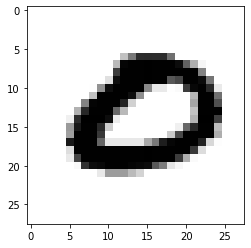

Example 16


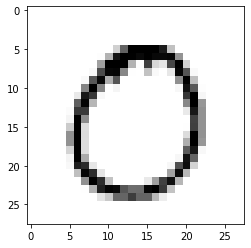

Example 17


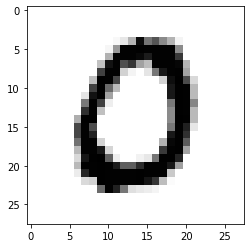

Example 18


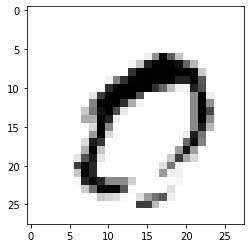

Example 19


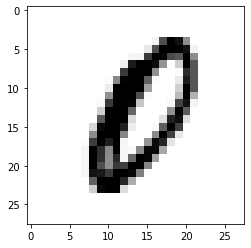

Example 20


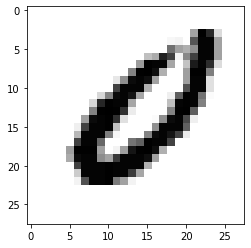

Example 21


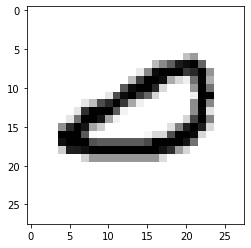

Example 22


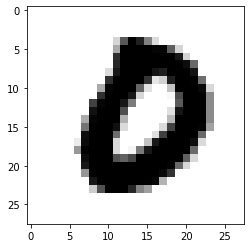

Example 23


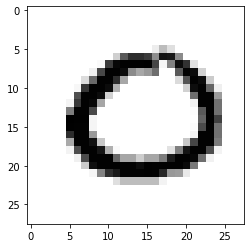

Example 24


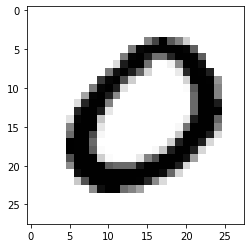

Example 25


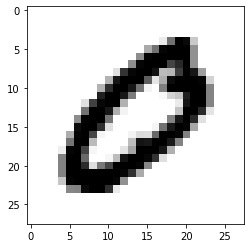

Example 26


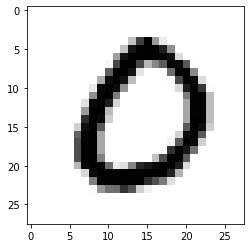

Example 27


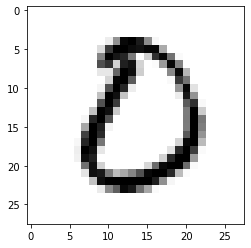

Example 28


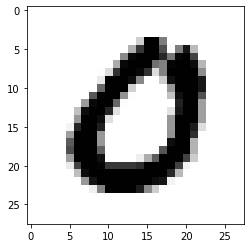

Example 29


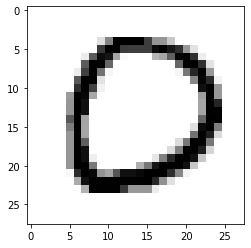

Example 30


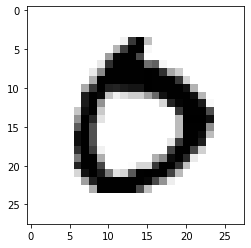

Example 31


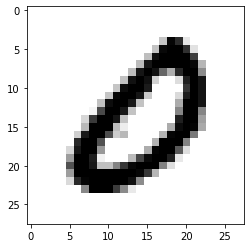

Example 32


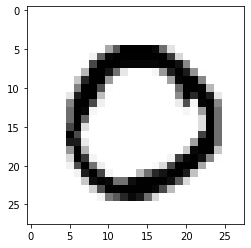

Example 33


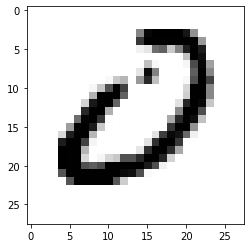

Example 34


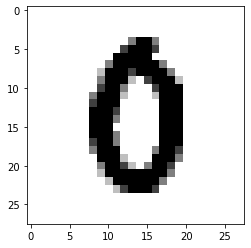

Example 35


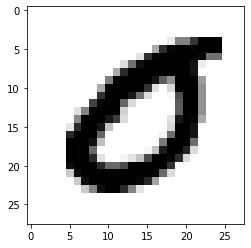

Example 36


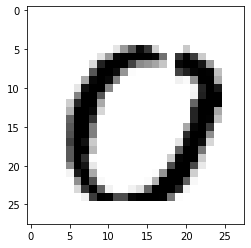

Example 37


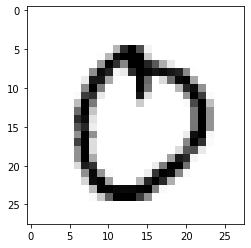

Example 38


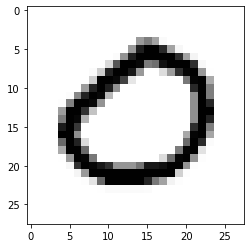

Example 39


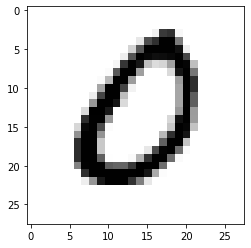

Example 40


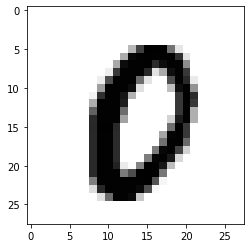

Example 41


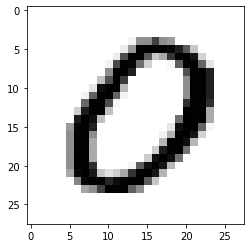

Example 42


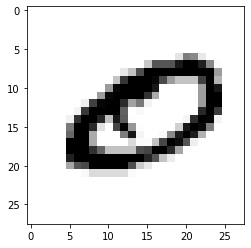

Example 43


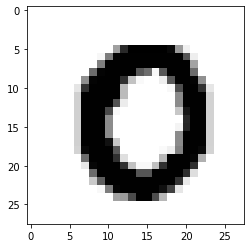

Example 44


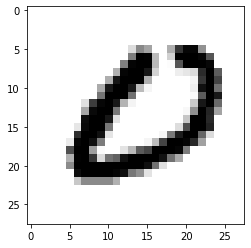

Example 45


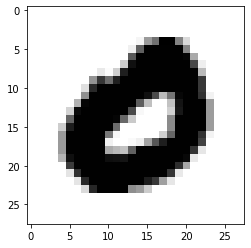

Example 46


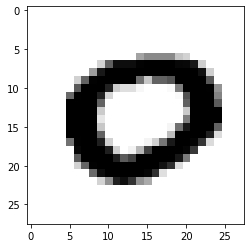

Example 47


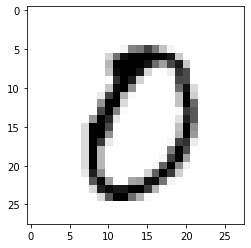

Example 48


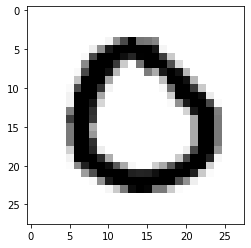

Example 49


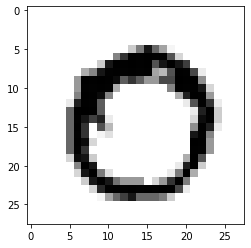

Example 50


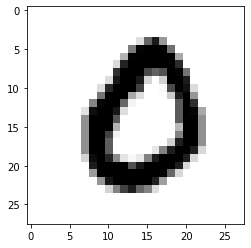

Example 51


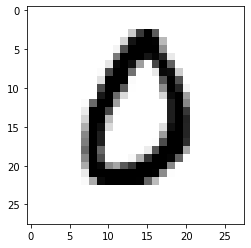

Example 52


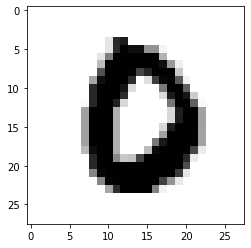

Example 53


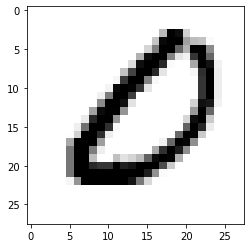

Example 54


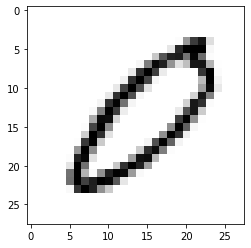

Example 55


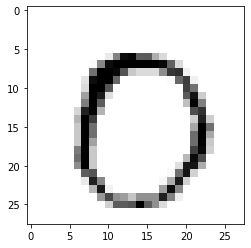

Example 56


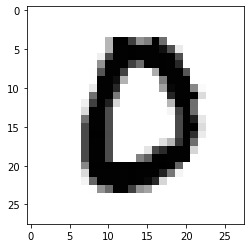

Example 57


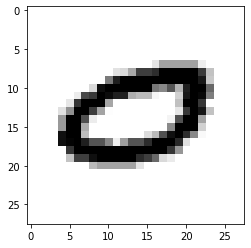

Example 58


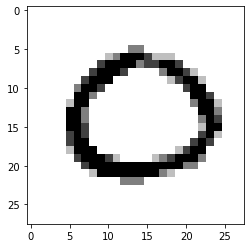

Example 59


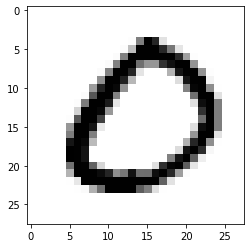

Example 60


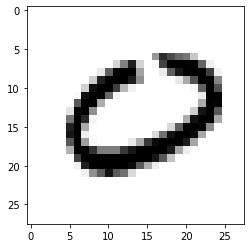

Example 61


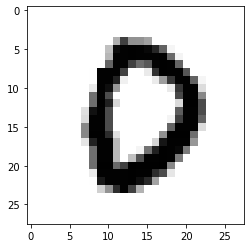

Example 62


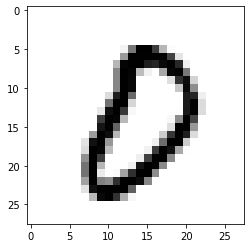

Example 63


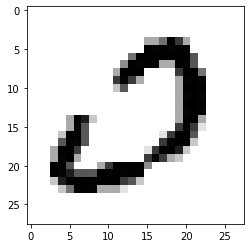

Example 64


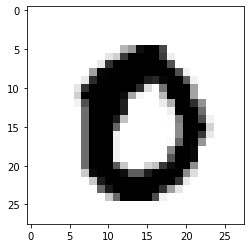

Example 65


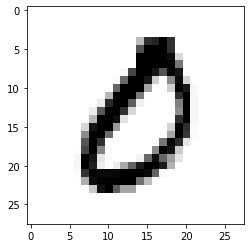

Example 66


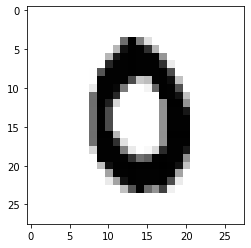

Example 67


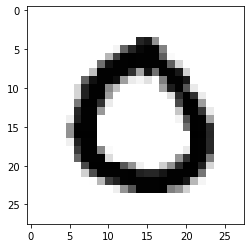

Example 68


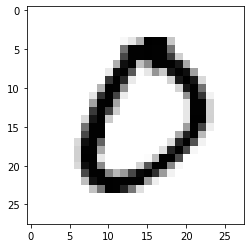

Example 69


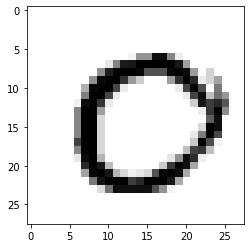

Example 70


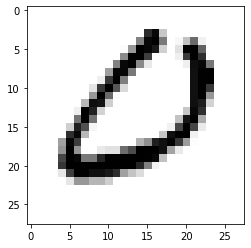

Example 71


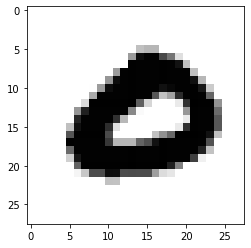

Example 72


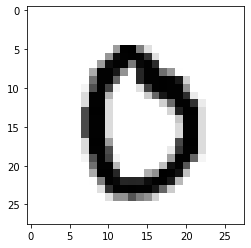

Example 73


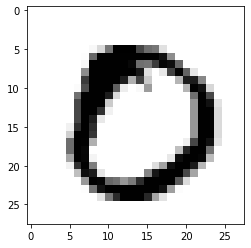

Example 74


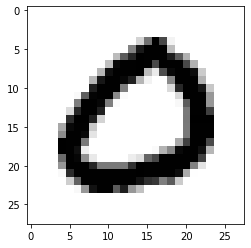

Example 75


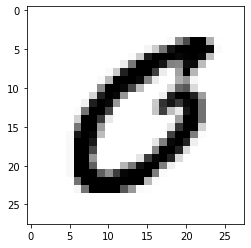

Example 76


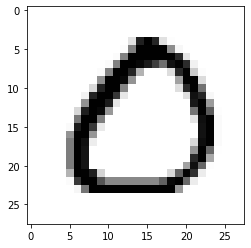

Example 77


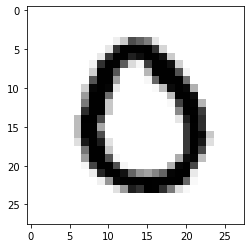

Example 78


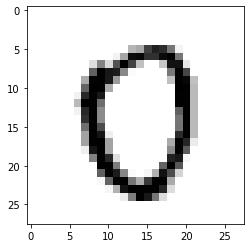

Example 79


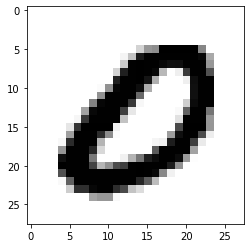

Example 80


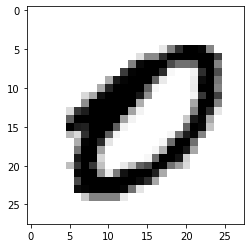

Example 81


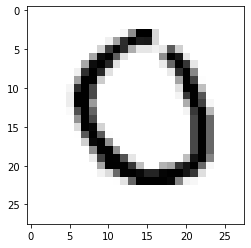

Example 82


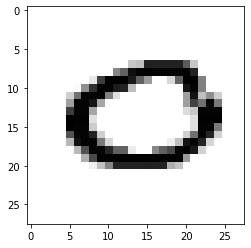

Example 83


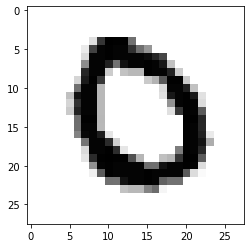

Example 84


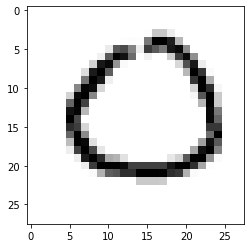

Example 85


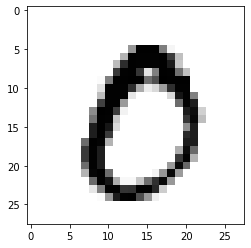

Example 86


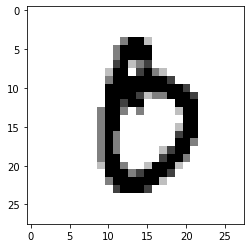

Example 87


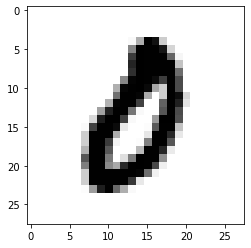

Example 88


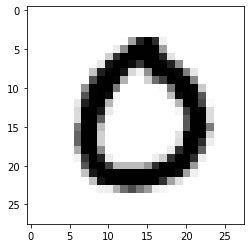

Example 89


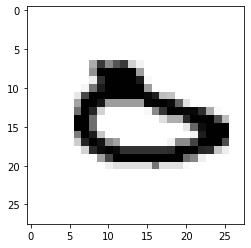

Example 90


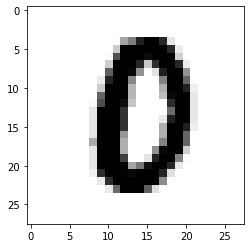

Example 91


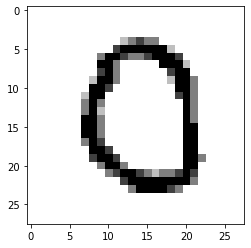

Example 92


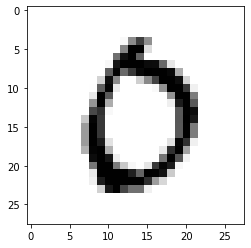

Example 93


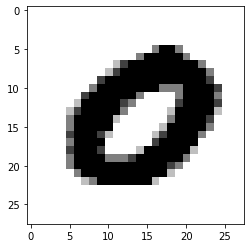

Example 94


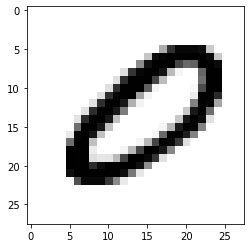

Example 95


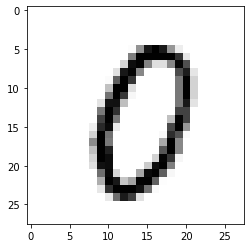

Example 96


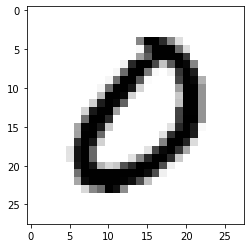

Example 97


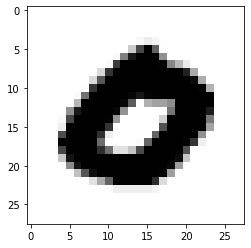

Example 98


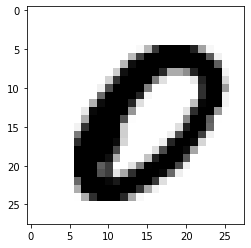

Example 99


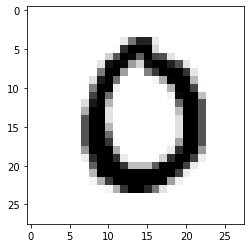

Example 100


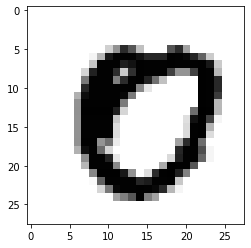

Example 101


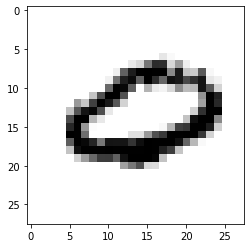

Example 102


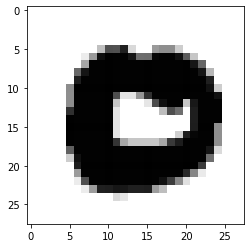

Example 103


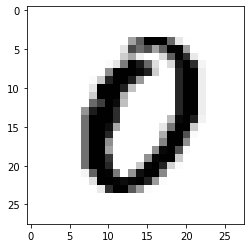

Example 104


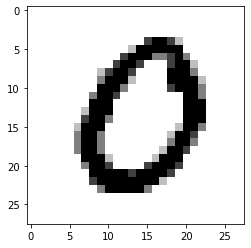

Example 105


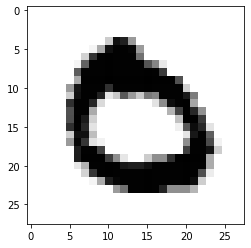

Example 106


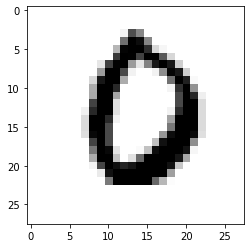

Example 107


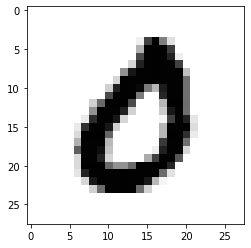

Example 108


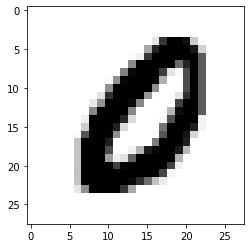

Example 109


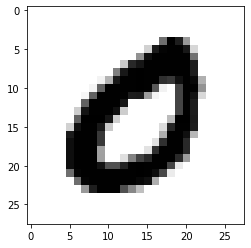

Example 110


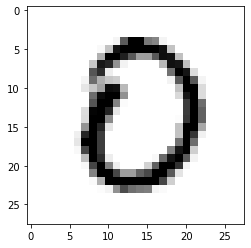

Example 111


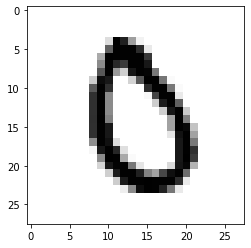

Example 112


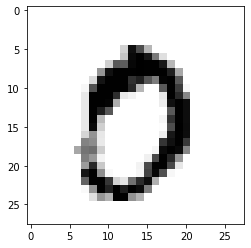

Example 113


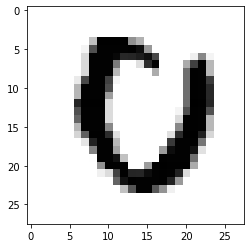

Example 114


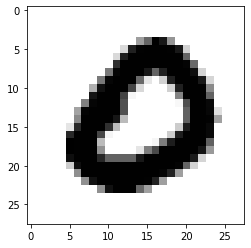

Example 115


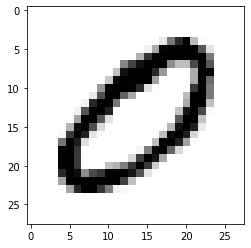

Example 116


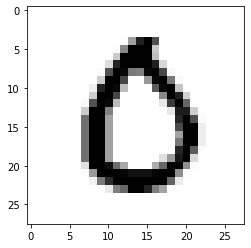

Example 117


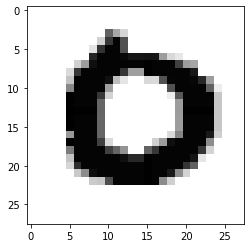

Example 118


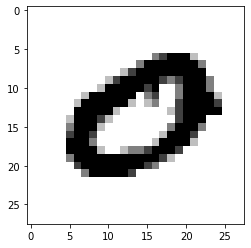

Example 119


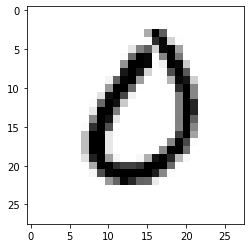

Example 120


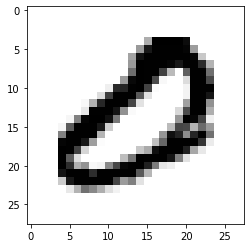

Example 121


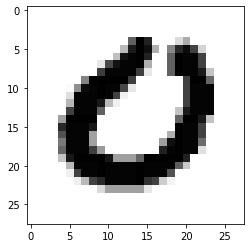

Example 122


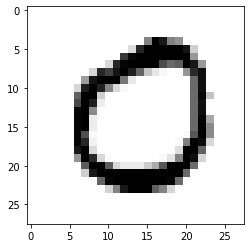

Example 123


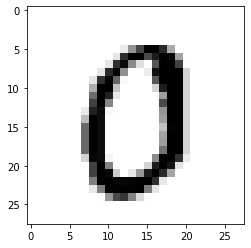

Example 124


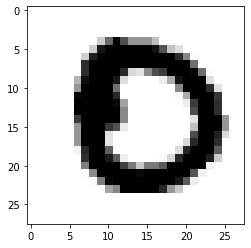

Example 125


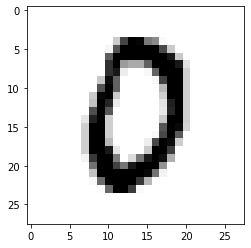

Example 126


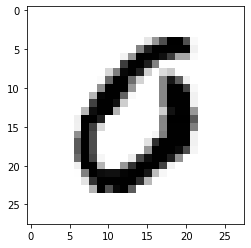

Example 127


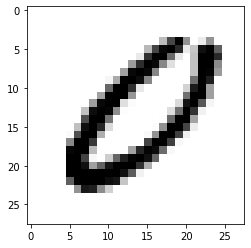

Example 128


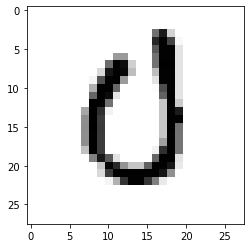

Example 129


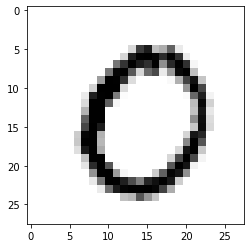

Example 130


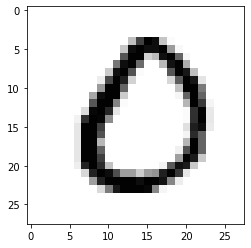

Example 131


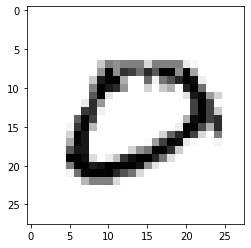

Example 132


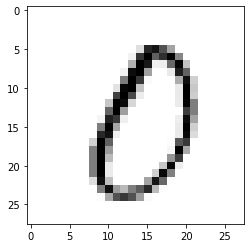

Example 133


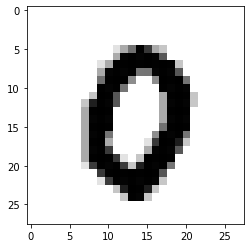

Example 134


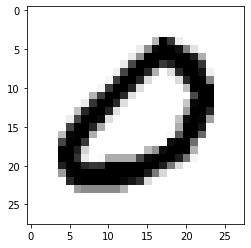

Example 135


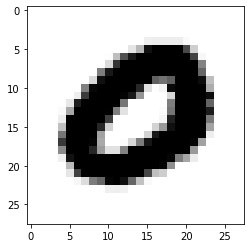

Example 136


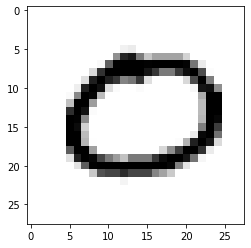

Example 137


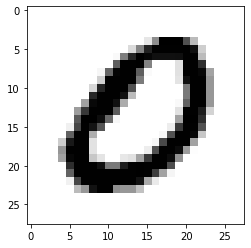

Example 138


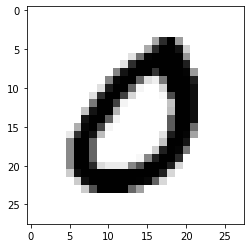

Example 139


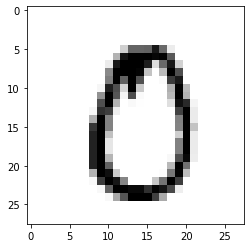

Example 140


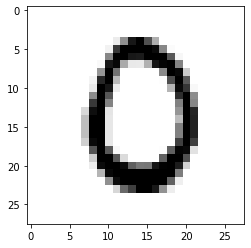

Example 141


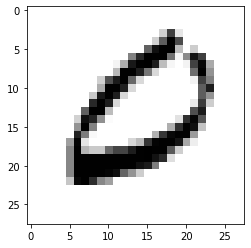

Example 142


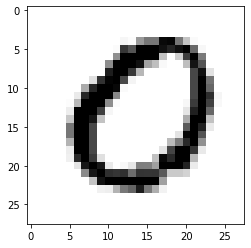

Example 143


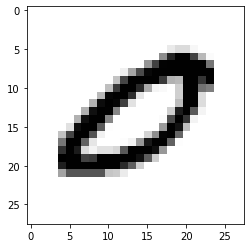

Example 144


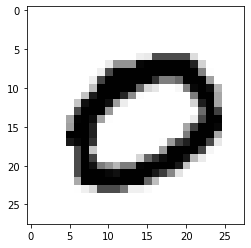

Example 145


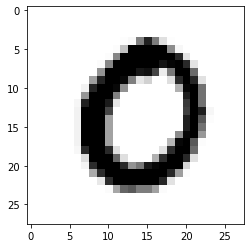

Example 146


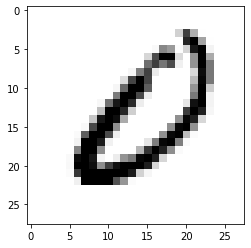

Example 147


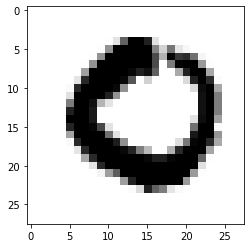

Example 148


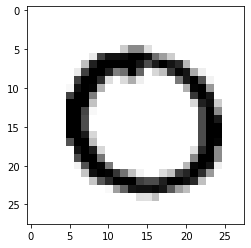

Example 149


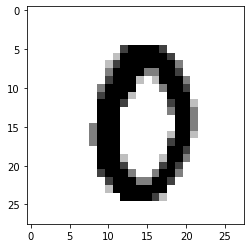

Example 150


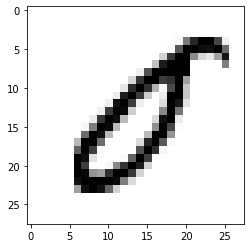

Example 151


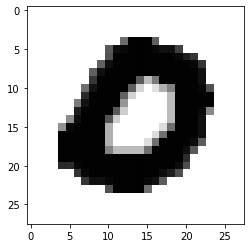

Example 152


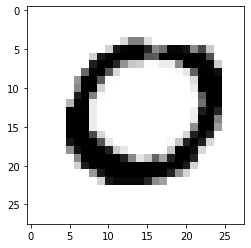

Example 153


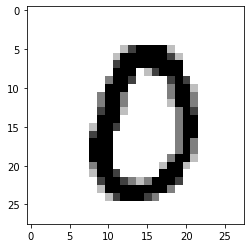

Example 154


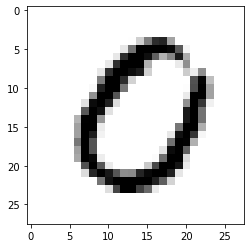

Example 155


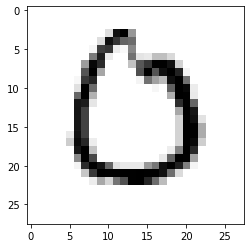

Example 156


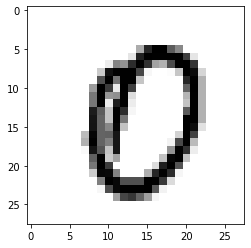

Example 157


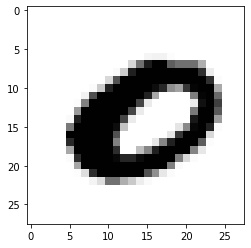

Example 158


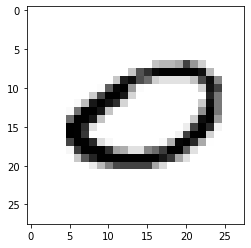

Example 159


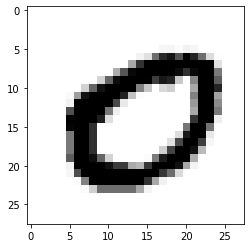

Example 160


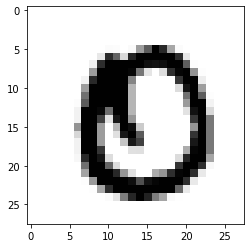

Example 161


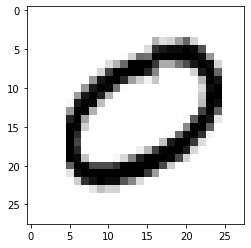

Example 162


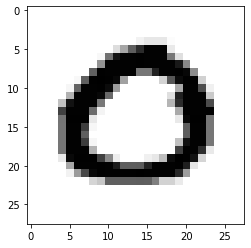

Example 163


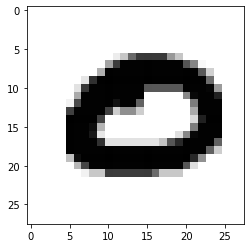

Example 164


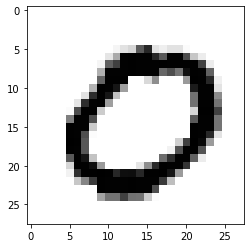

Example 165


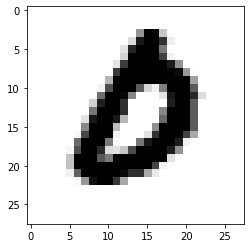

Example 166


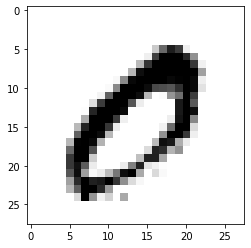

Example 167


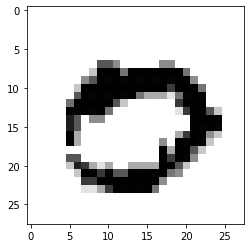

Example 168


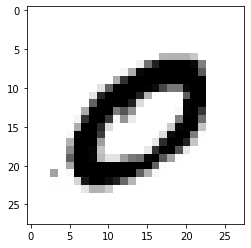

Example 169


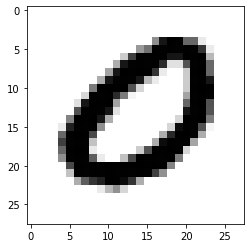

Example 170


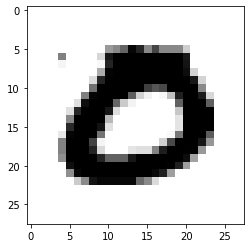

Example 171


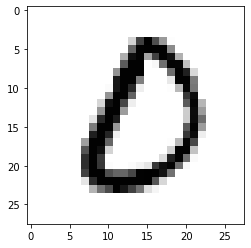

Example 172


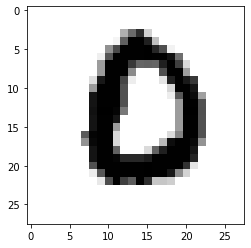

Example 173


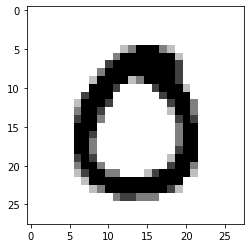

Example 174


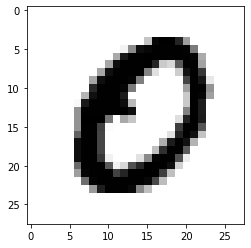

Example 175


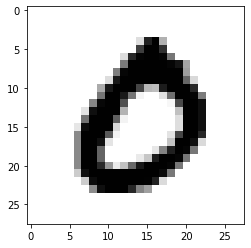

Example 176


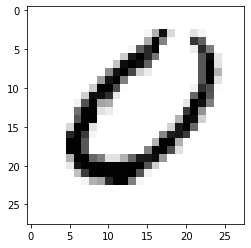

Example 177


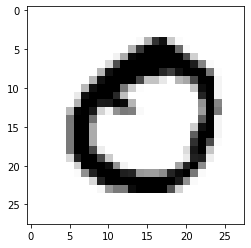

Example 178


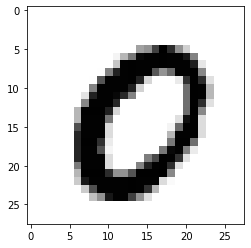

Example 179


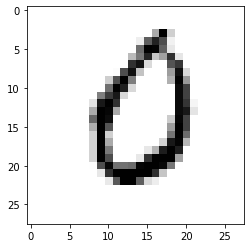

Example 180


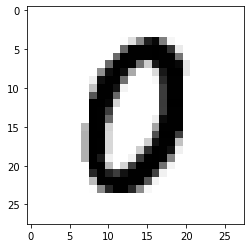

Example 181


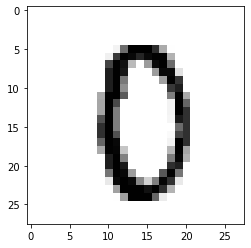

Example 182


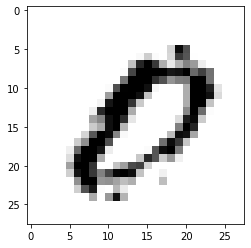

Example 183


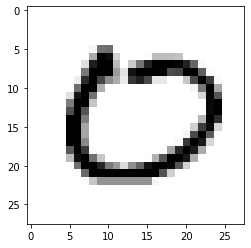

Example 184


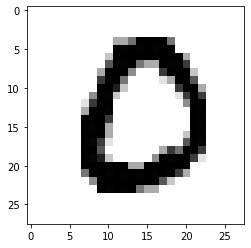

Example 185


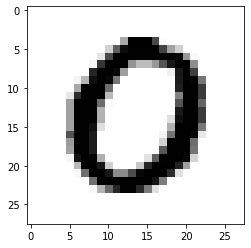

Example 186


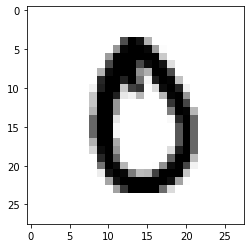

Example 187


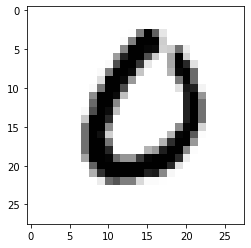

Example 188


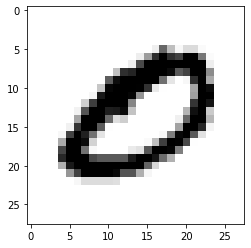

Example 189


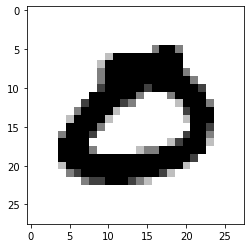

Example 190


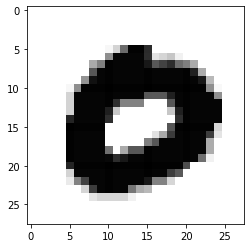

Example 191


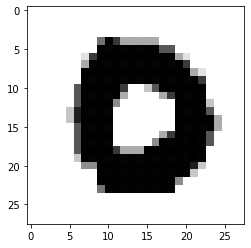

Example 192


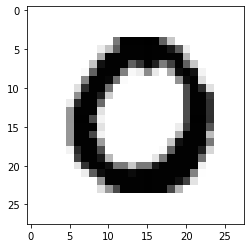

Example 193


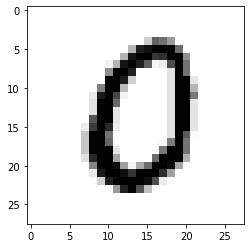

Example 194


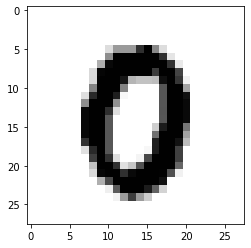

Example 195


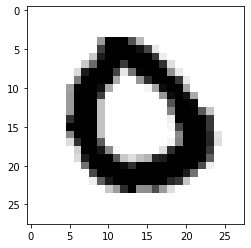

Example 196


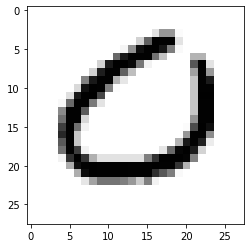

Example 197


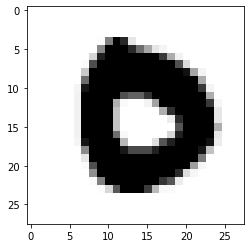

Example 198


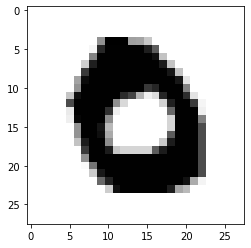

Example 199


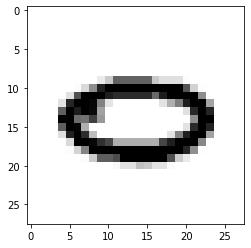

Example 200


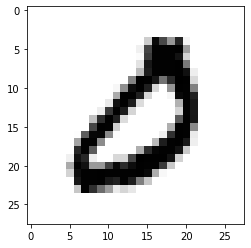

Example 201


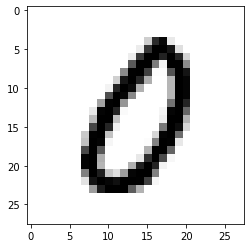

Example 202


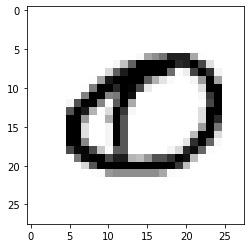

Example 203


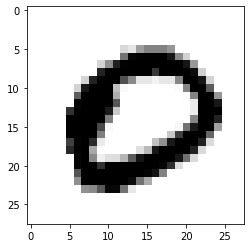

Example 204


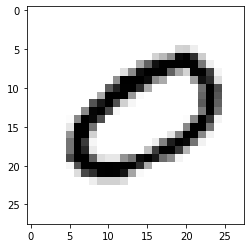

Example 205


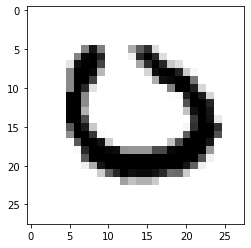

Example 206


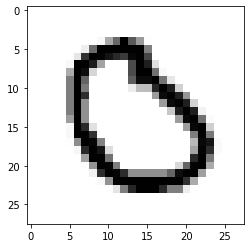

Example 207


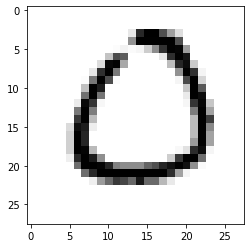

Example 208


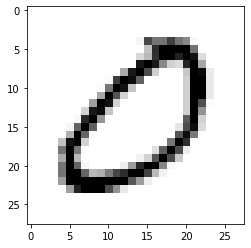

Example 209


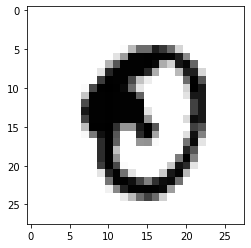

Example 210


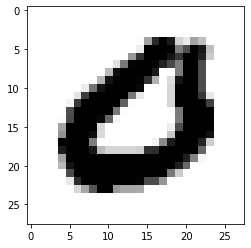

Example 211


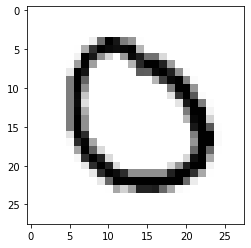

Example 212


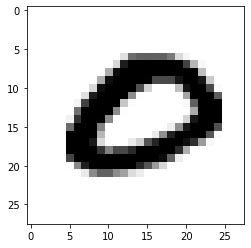

Example 213


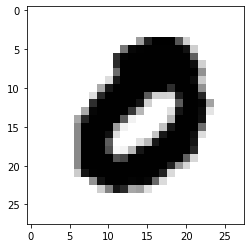

Example 214


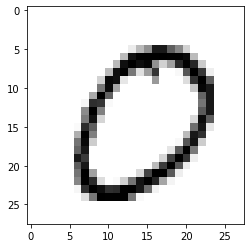

Example 215


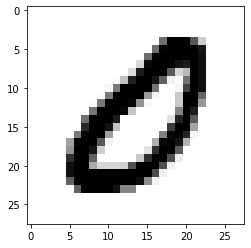

Example 216


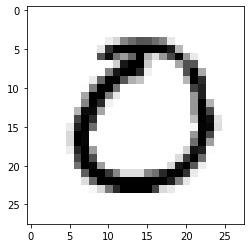

Example 217


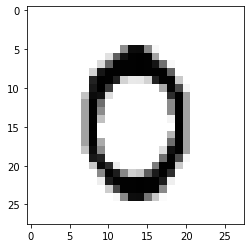

Example 218


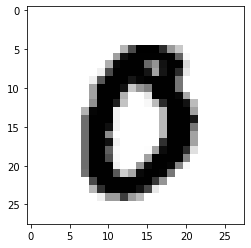

Example 219


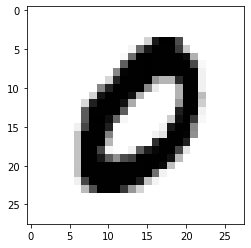

Example 220


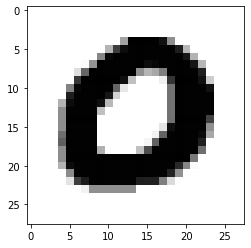

Example 221


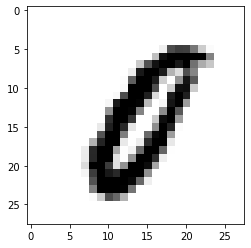

Example 222


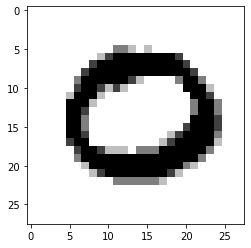

Example 223


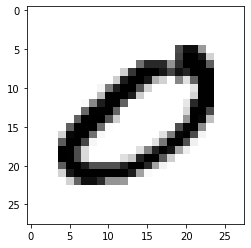

Example 224


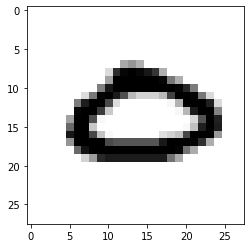

Example 225


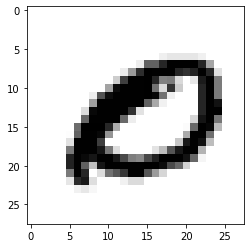

Example 226


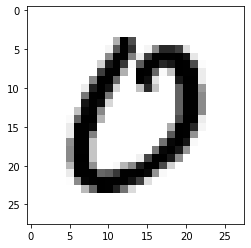

Example 227


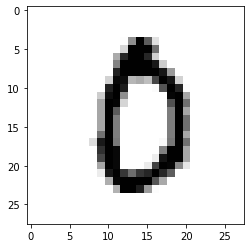

Example 228


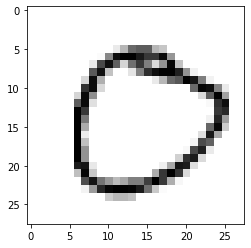

Example 229


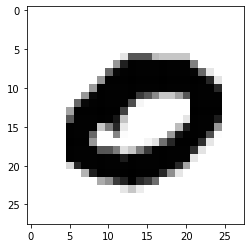

Example 230


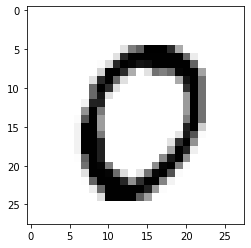

Example 231


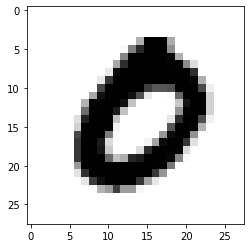

Example 232


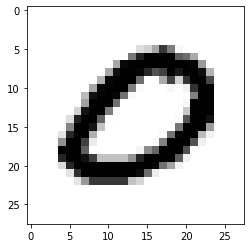

Example 233


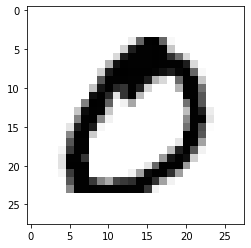

Example 234


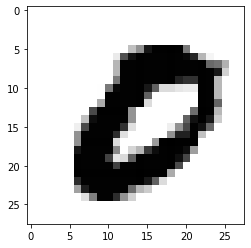

Example 235


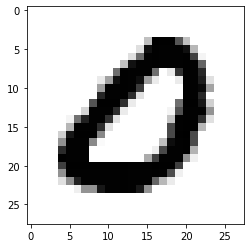

Example 236


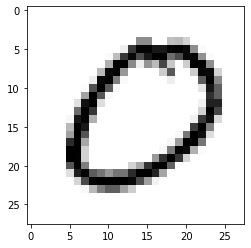

Example 237


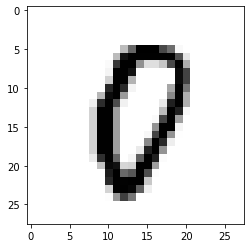

Example 238


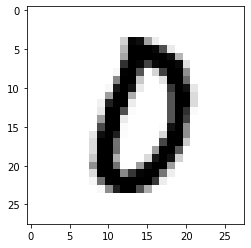

Example 239


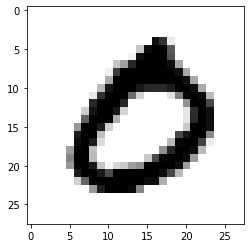

Example 240


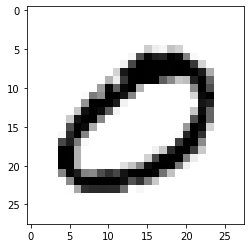

Example 241


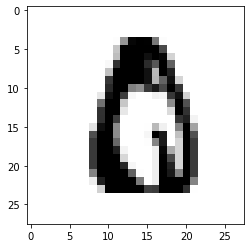

Example 242


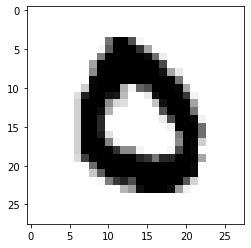

Example 243


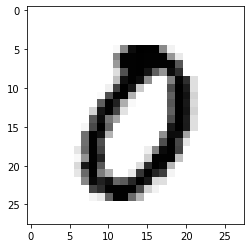

Example 244


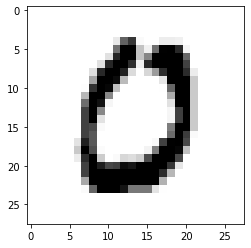

Example 245


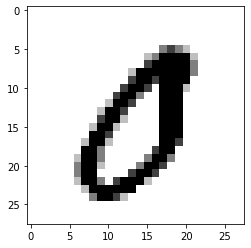

Example 246


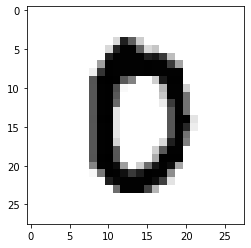

Example 247


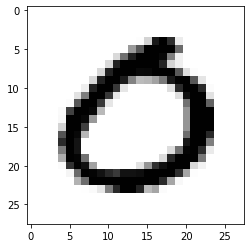

Example 248


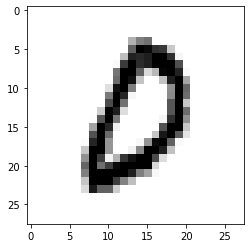

Example 249


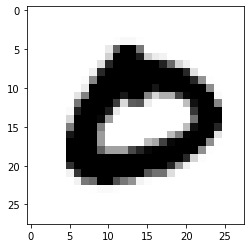

Example 250


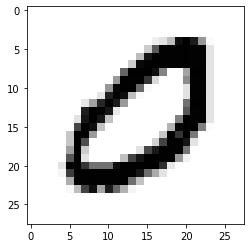

Example 251


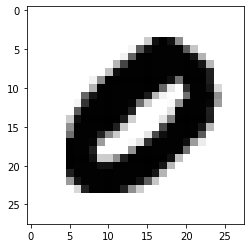

Example 252


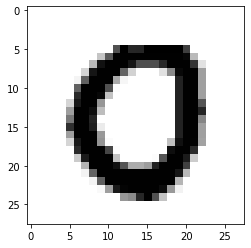

Example 253


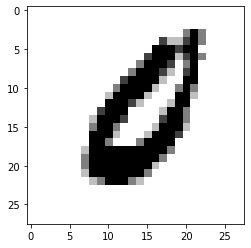

Example 254


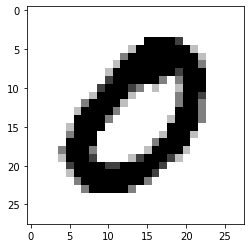

Example 255


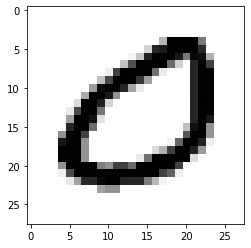

Example 256


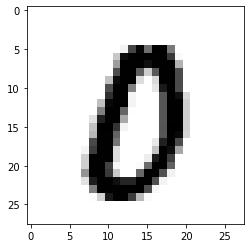

Example 257


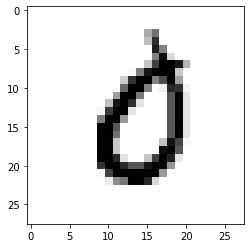

Example 258


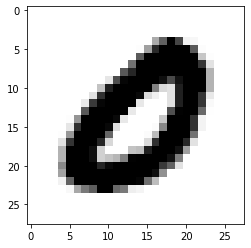

Example 259


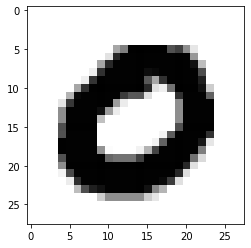

Example 260


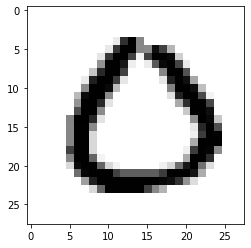

Example 261


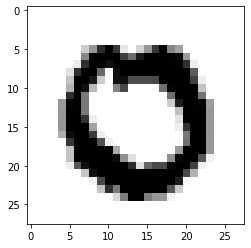

Example 262


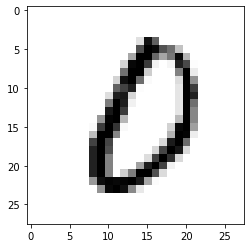

Example 263


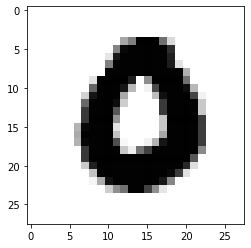

Example 264


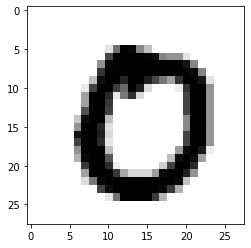

Example 265


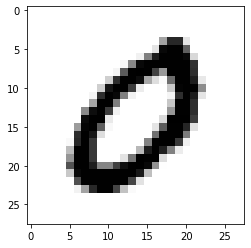

Example 266


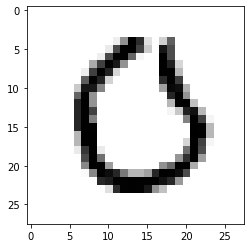

Example 267


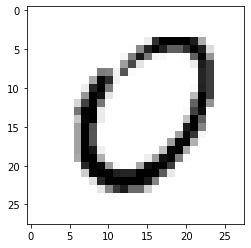

Example 268


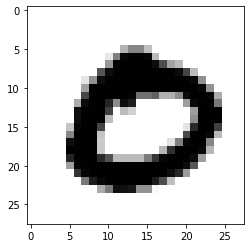

Example 269


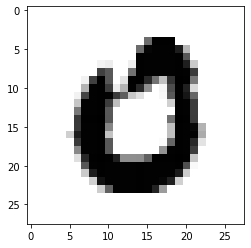

Example 270


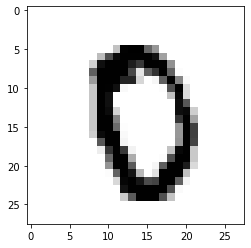

Example 271


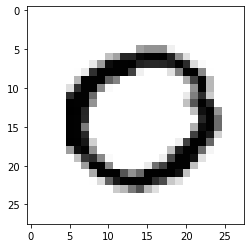

Example 272


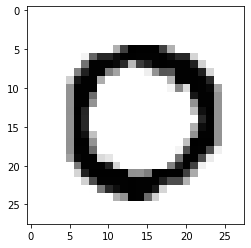

Example 273


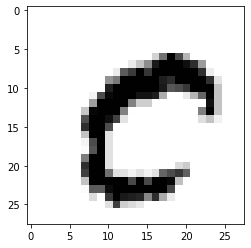

Example 274


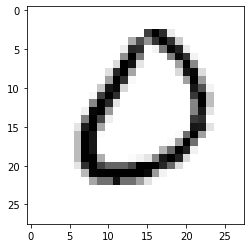

Example 275


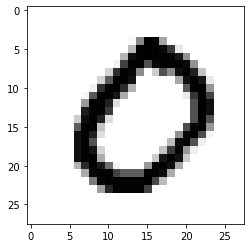

Example 276


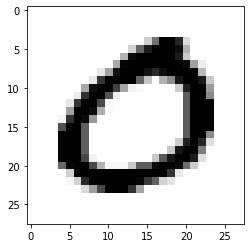

Example 277


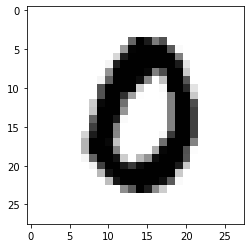

Example 278


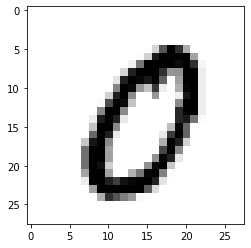

Example 279


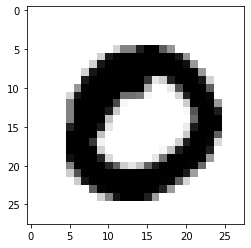

Example 280


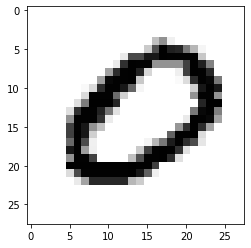

Example 281


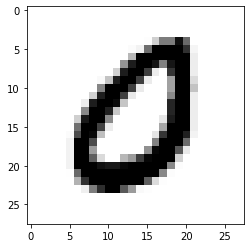

Example 282


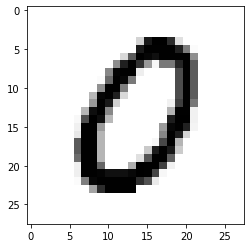

Example 283


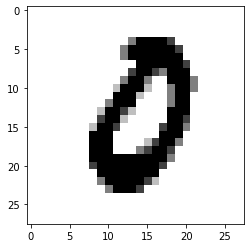

Example 284


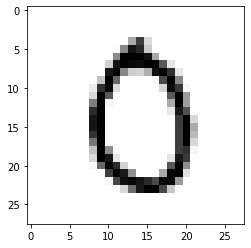

Example 285


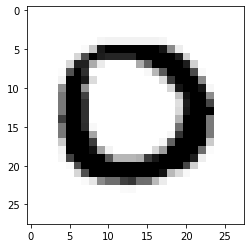

Example 286


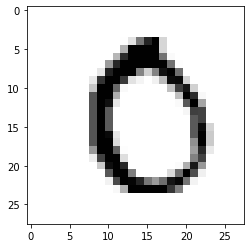

Example 287


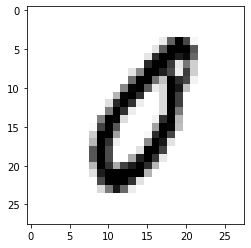

Example 288


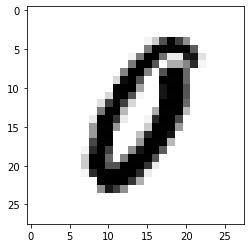

Example 289


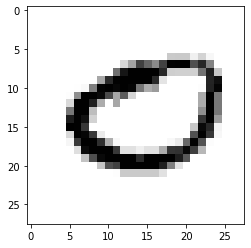

Example 290


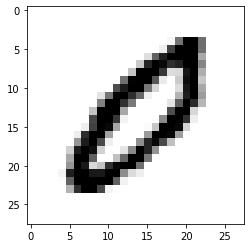

Example 291


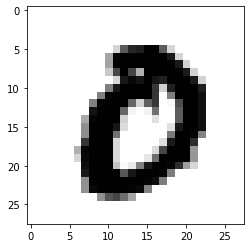

Example 292


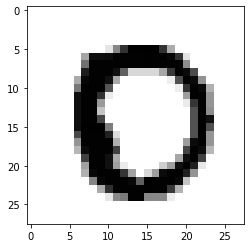

Example 293


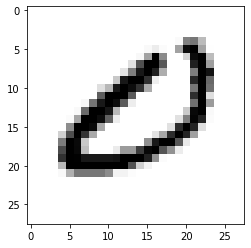

Example 294


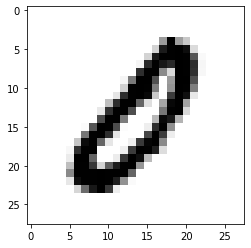

Example 295


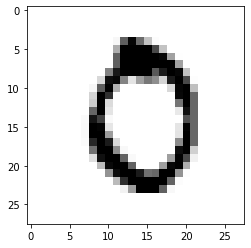

Example 296


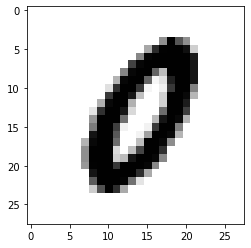

Example 297


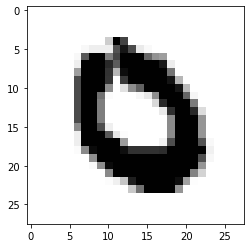

Example 298


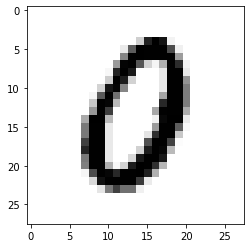

Example 299


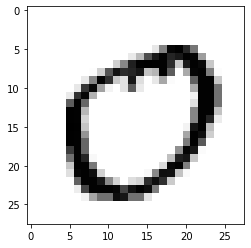

Example 300


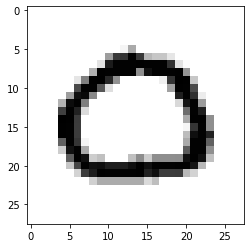

Example 301


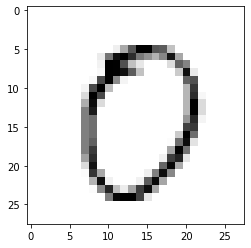

Example 302


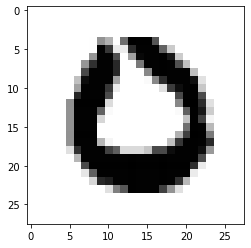

Example 303


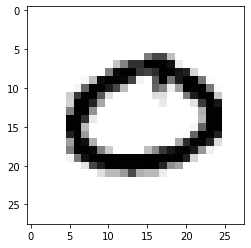

Example 304


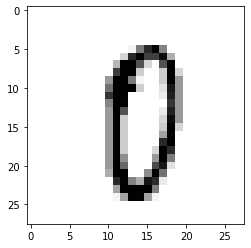

Example 305


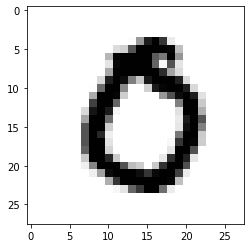

Example 306


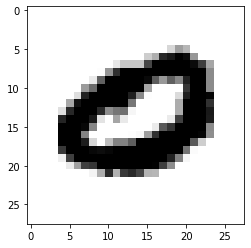

Example 307


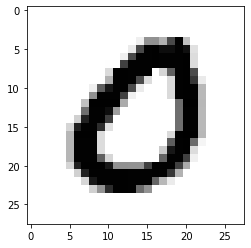

Example 308


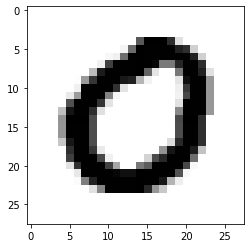

Example 309


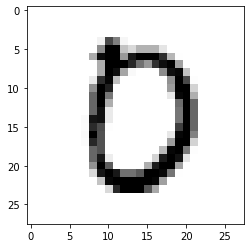

Example 310


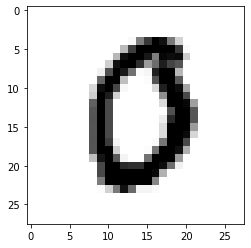

Example 311


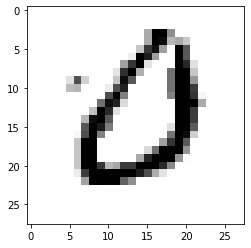

Example 312


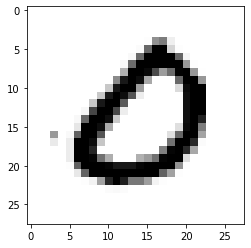

Example 313


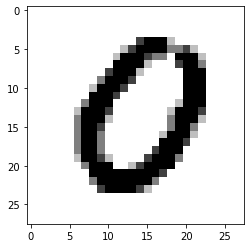

Example 314


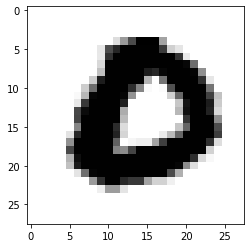

Example 315


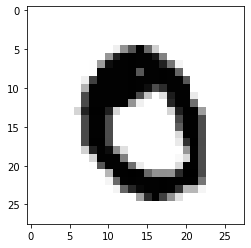

Example 316


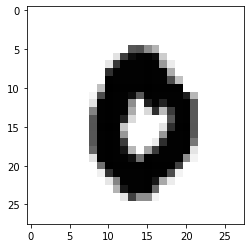

Example 317


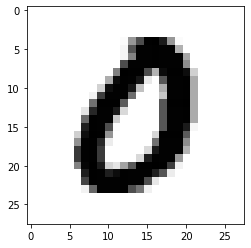

Example 318


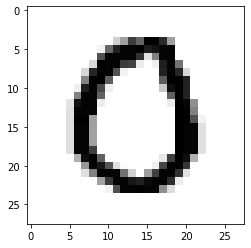

Example 319


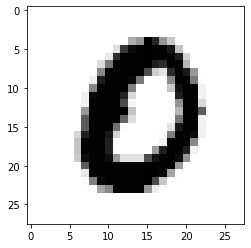

Example 320


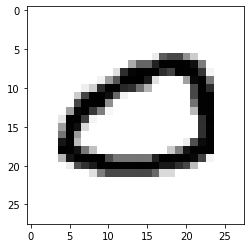

Example 321


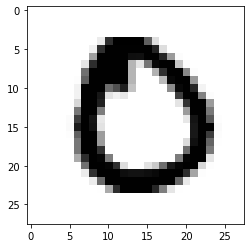

Example 322


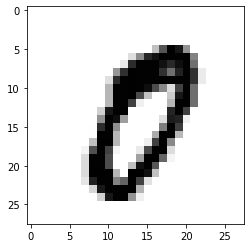

Example 323


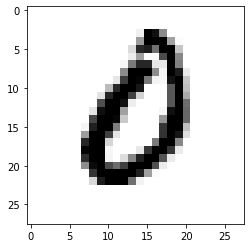

Example 324


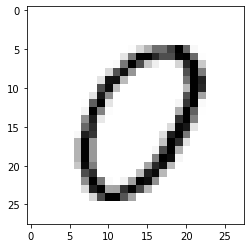

Example 325


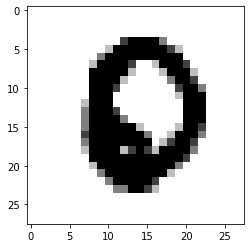

Example 326


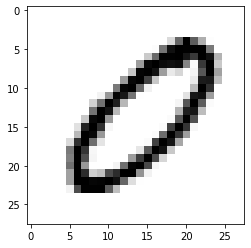

Example 327


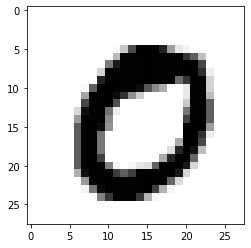

Example 328


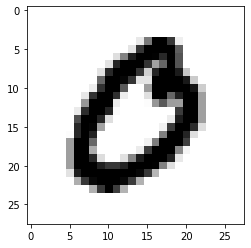

Example 329


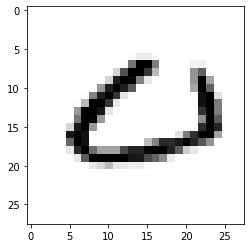

Example 330


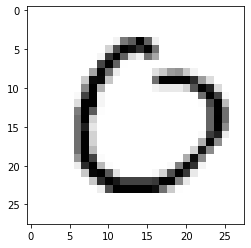

Example 331


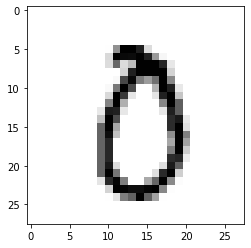

Example 332


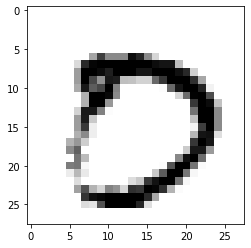

Example 333


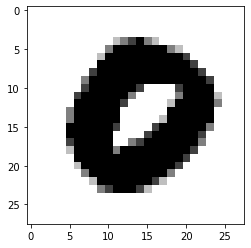

Example 334


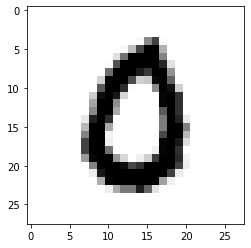

Example 335


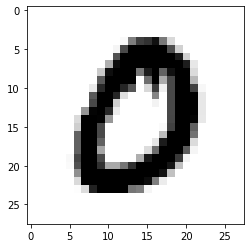

Example 336


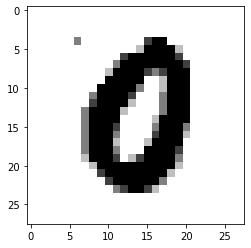

Example 337


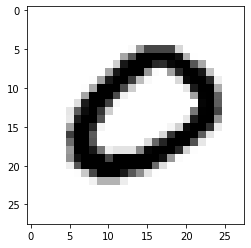

Example 338


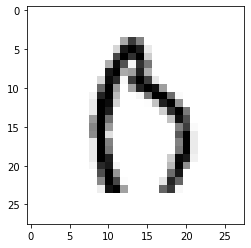

Example 339


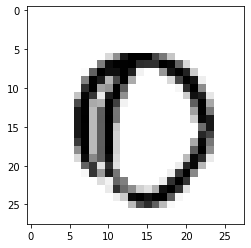

Example 340


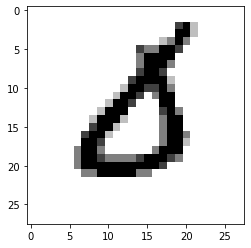

Example 341


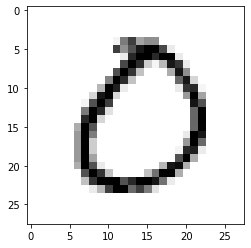

Example 342


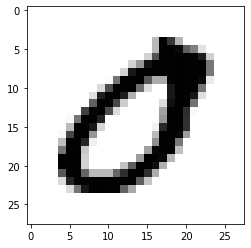

Example 343


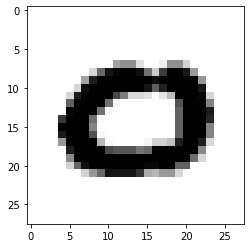

Example 344


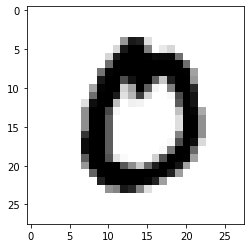

Example 345


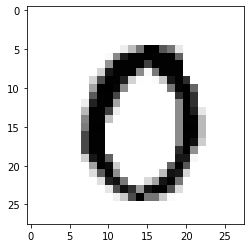

Example 346


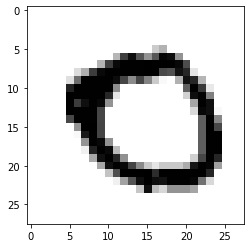

Example 347


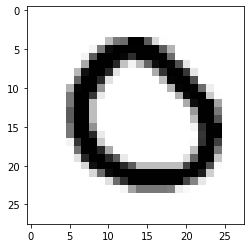

Example 348


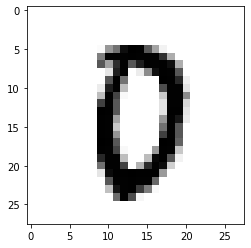

Example 349


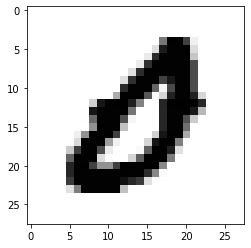

Example 350


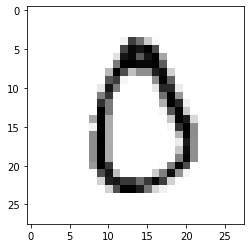

Example 351


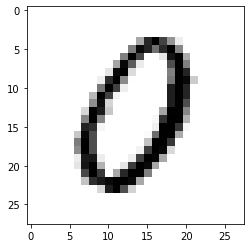

Example 352


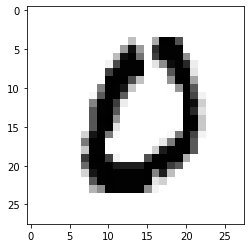

Example 353


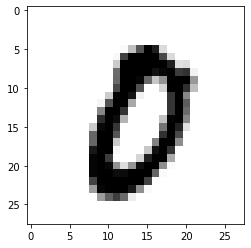

Example 354


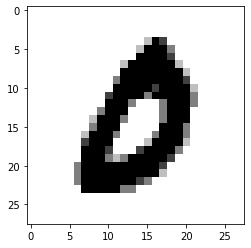

Example 355


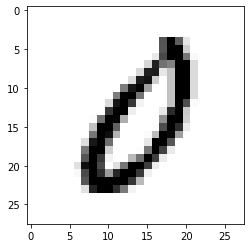

Example 356


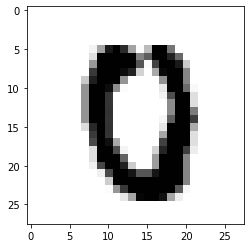

Example 357


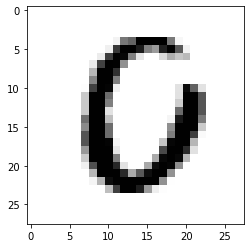

Example 358


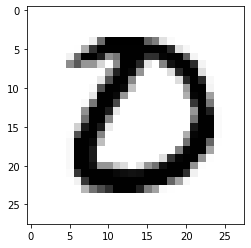

Example 359


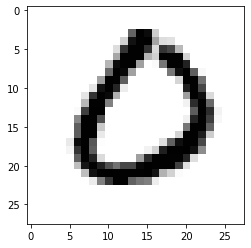

Example 360


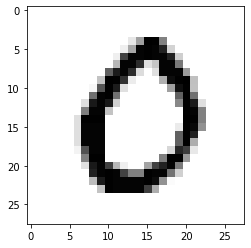

Example 361


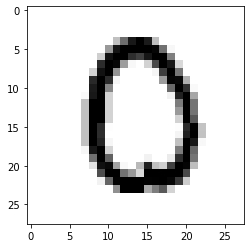

Example 362


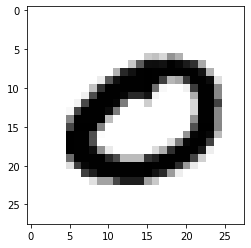

Example 363


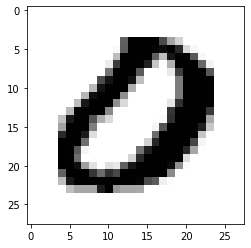

Example 364


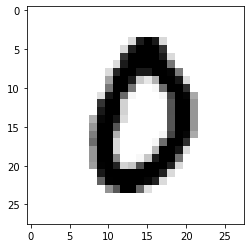

Example 365


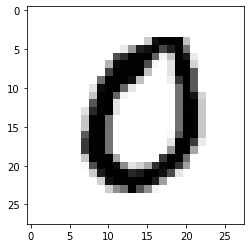

Example 366


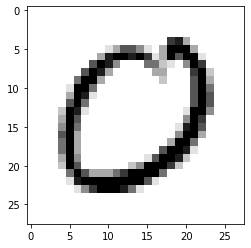

Example 367


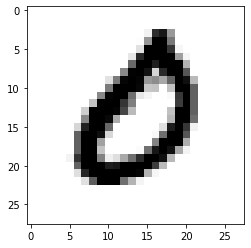

Example 368


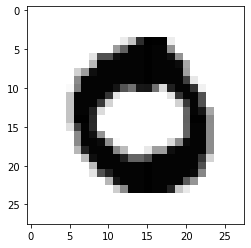

Example 369


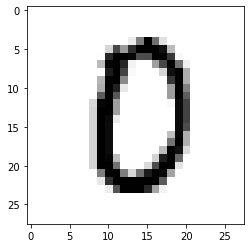

Example 370


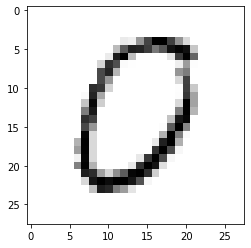

Example 371


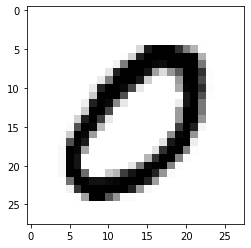

Example 372


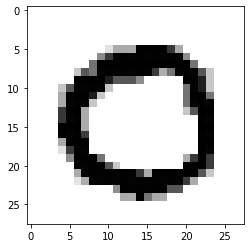

Example 373


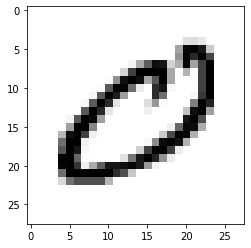

Example 374


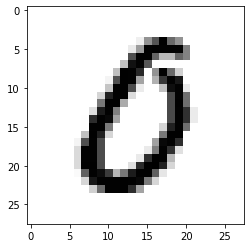

Example 375


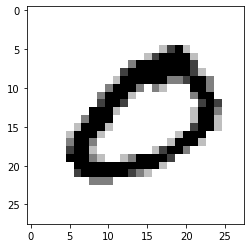

Example 376


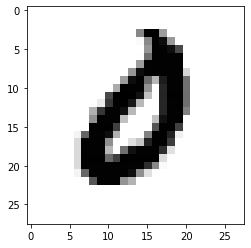

Example 377


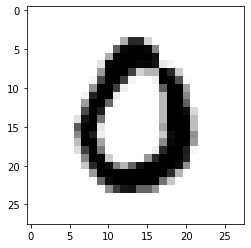

Example 378


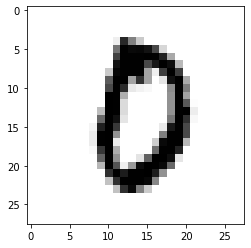

Example 379


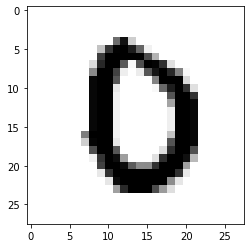

Example 380


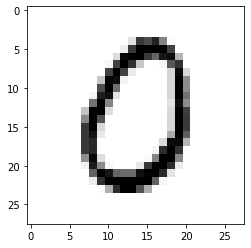

Example 381


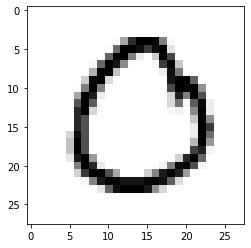

Example 382


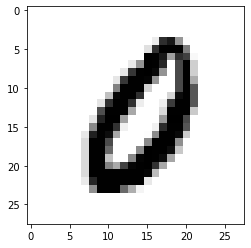

Example 383


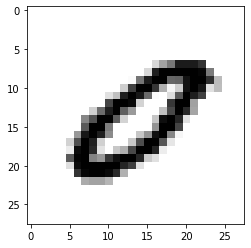

Example 384


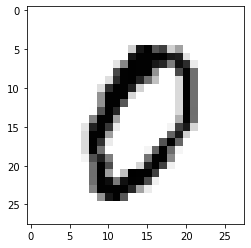

Example 385


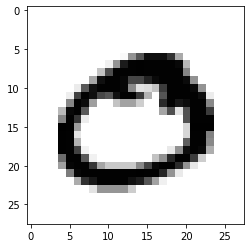

Example 386


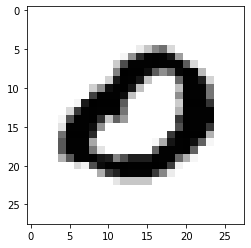

Example 387


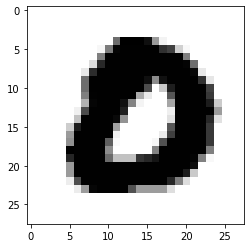

Example 388


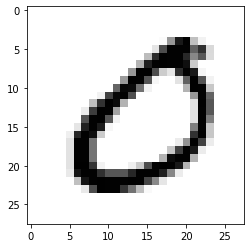

Example 389


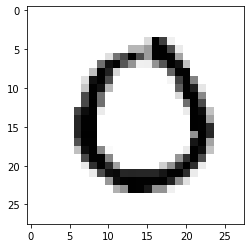

Example 390


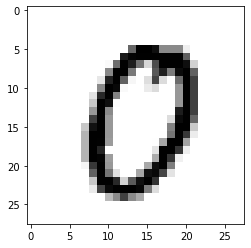

Example 391


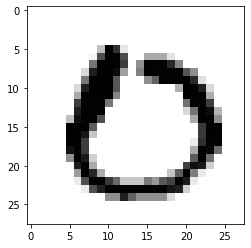

Example 392


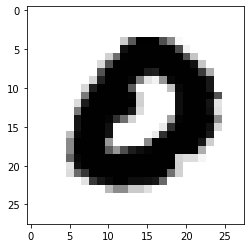

Example 393


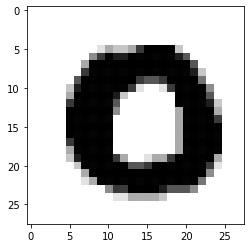

Example 394


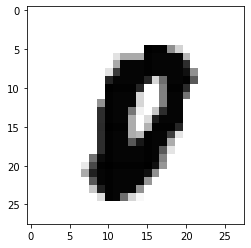

Example 395


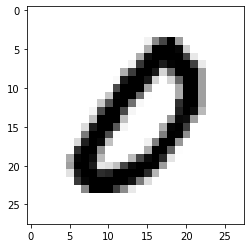

Example 396


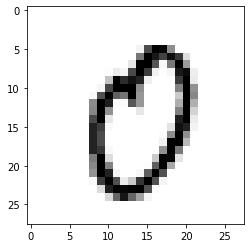

Example 397


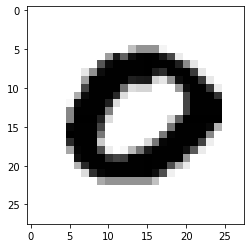

Example 398


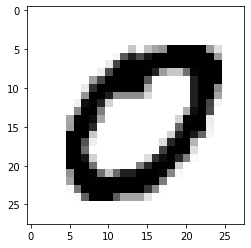

Example 399


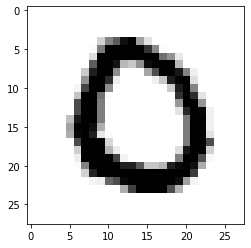

Example 400


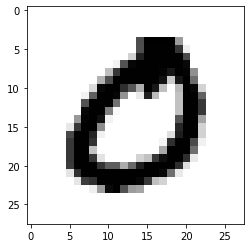

Example 401


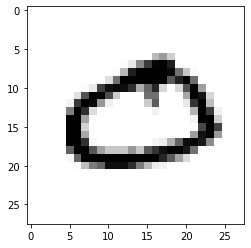

Example 402


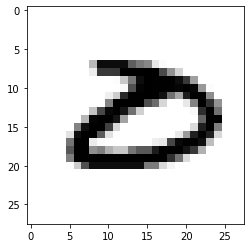

Example 403


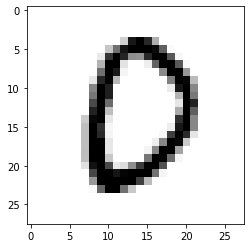

Example 404


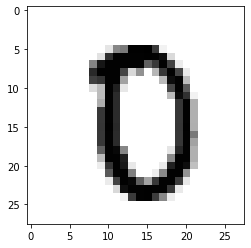

Example 405


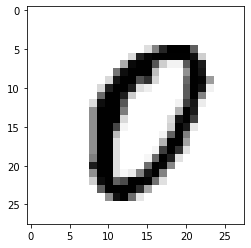

Example 406


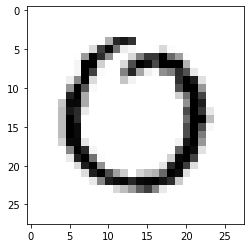

Example 407


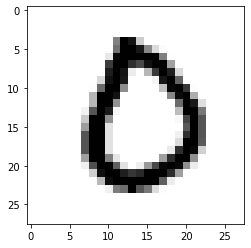

Example 408


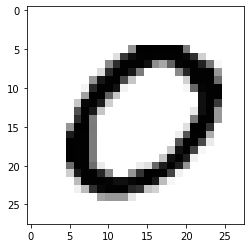

Example 409


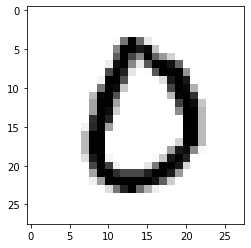

Example 410


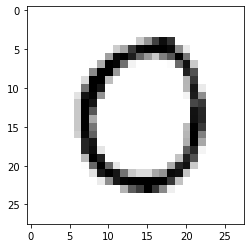

Example 411


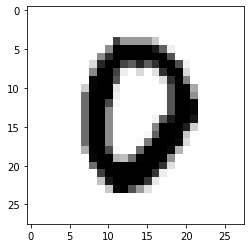

Example 412


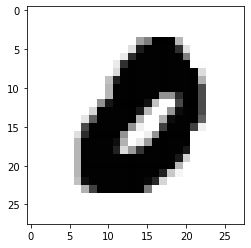

Example 413


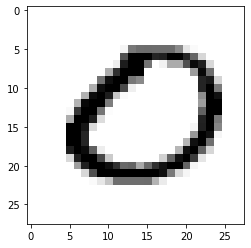

Example 414


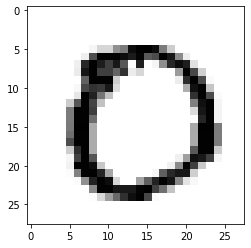

Example 415


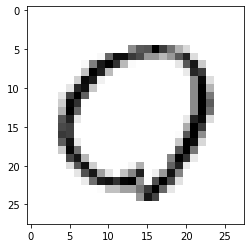

Example 416


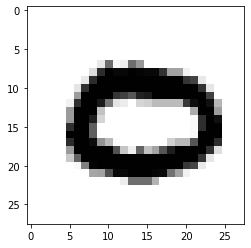

Example 417


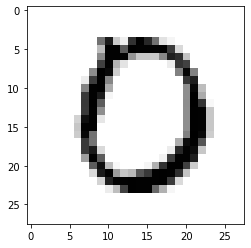

Example 418


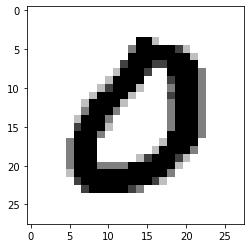

Example 419


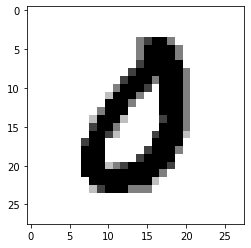

Example 420


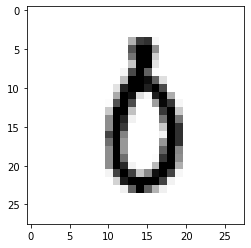

Example 421


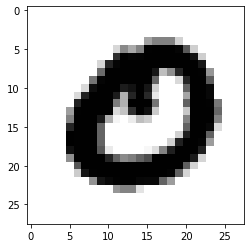

Example 422


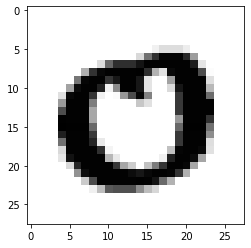

Example 423


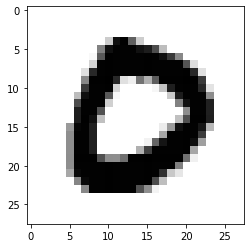

Example 424


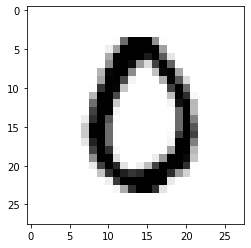

Example 425


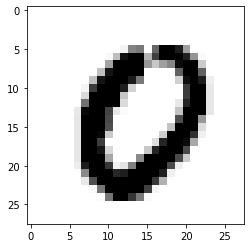

Example 426


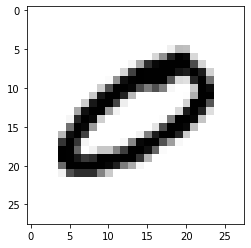

Example 427


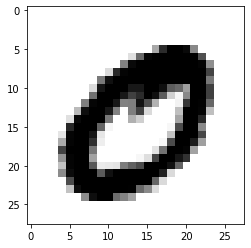

Example 428


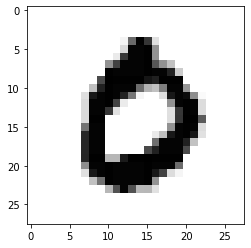

Example 429


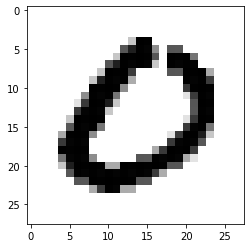

Example 430


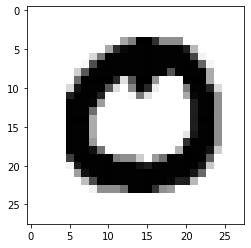

Example 431


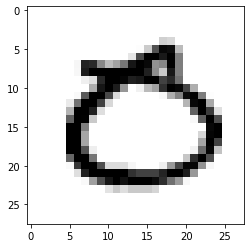

Example 432


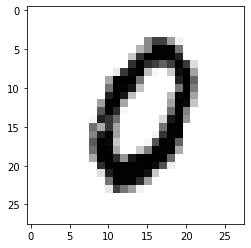

Example 433


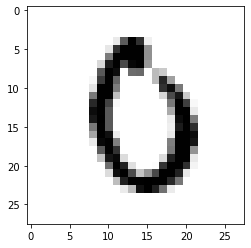

Example 434


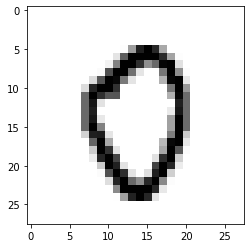

Example 435


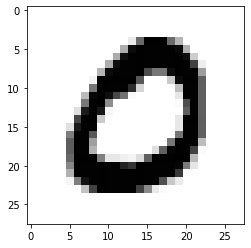

Example 436


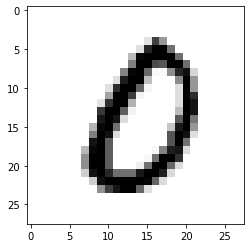

Example 437


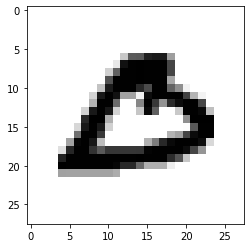

Example 438


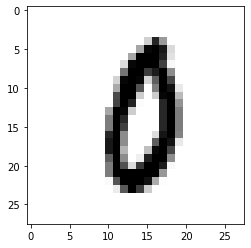

Example 439


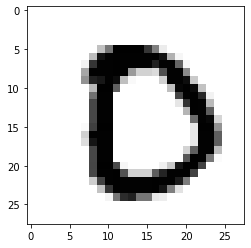

Example 440


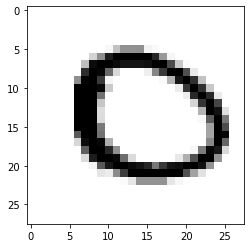

Example 441


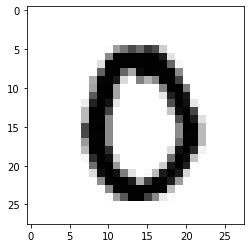

Example 442


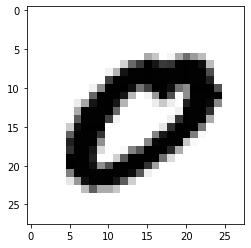

Example 443


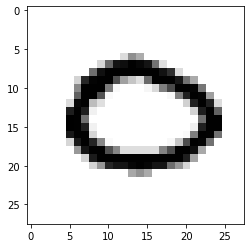

Example 444


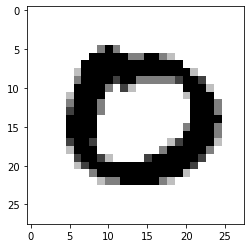

Example 445


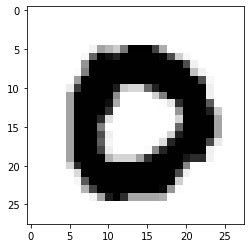

Example 446


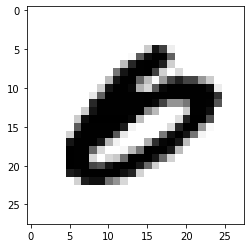

Example 447


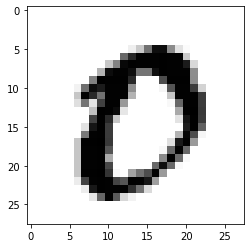

Example 448


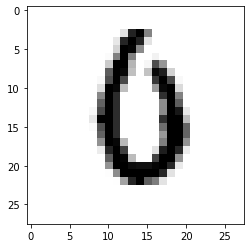

Example 449


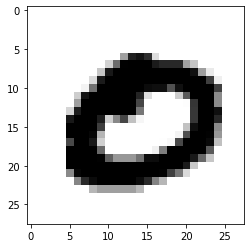

Example 450


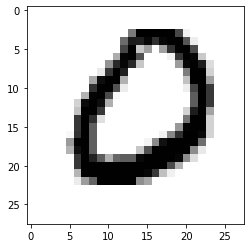

Example 451


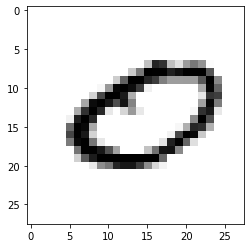

Example 452


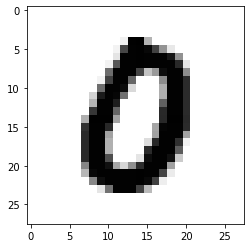

Example 453


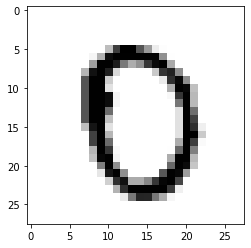

Example 454


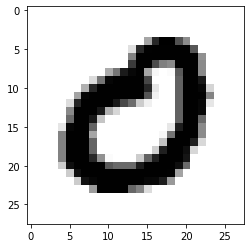

Example 455


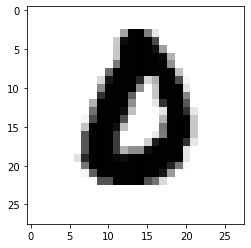

Example 456


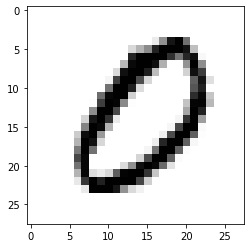

Example 457


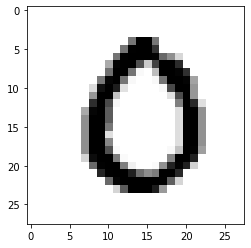

Example 458


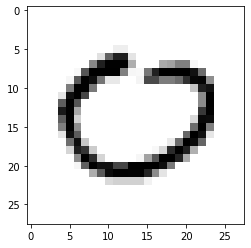

Example 459


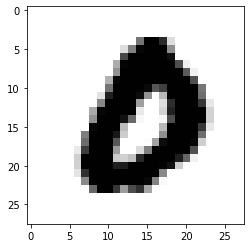

Example 460


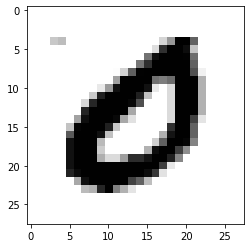

Example 461


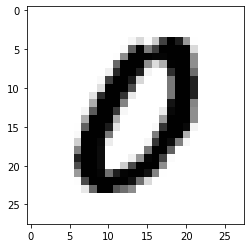

Example 462


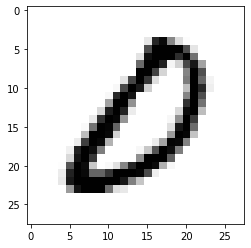

Example 463


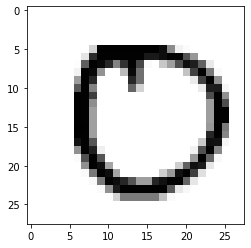

Example 464


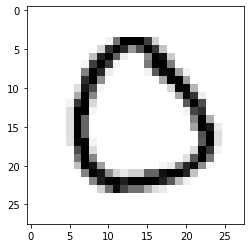

Example 465


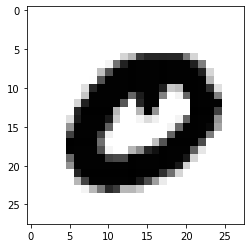

Example 466


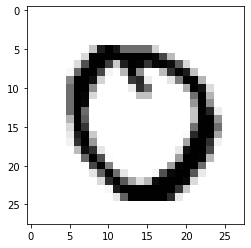

Example 467


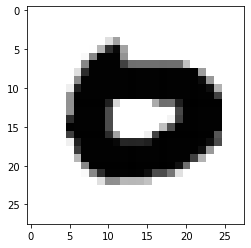

Example 468


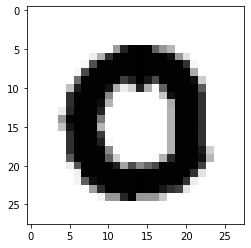

Example 469


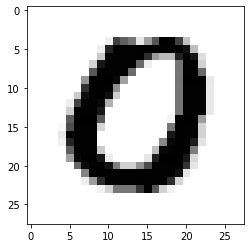

Example 470


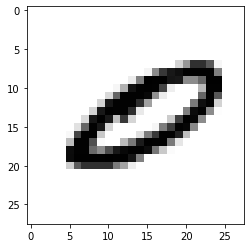

Example 471


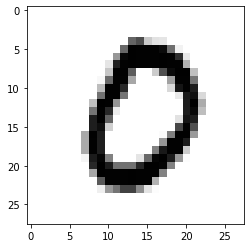

Example 472


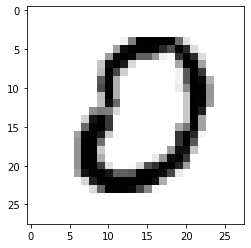

Example 473


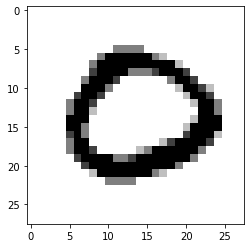

Example 474


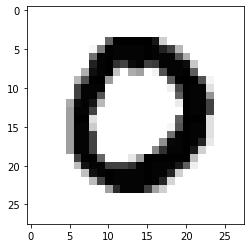

Example 475


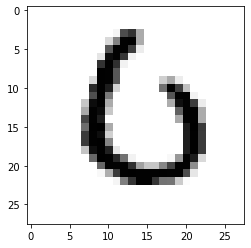

Example 476


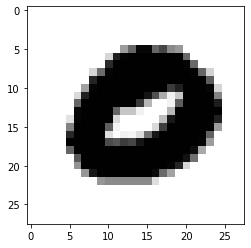

Example 477


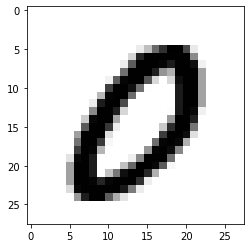

Example 478


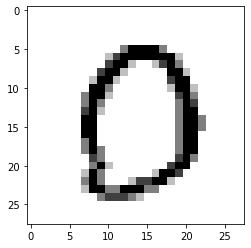

Example 479


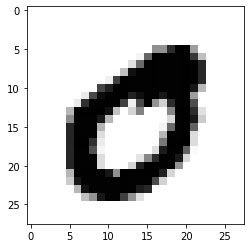

Example 480


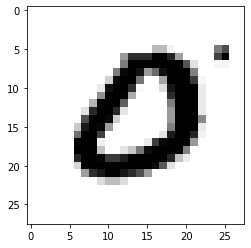

Example 481


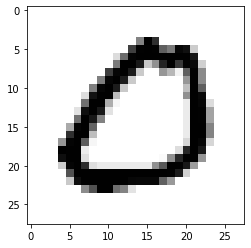

Example 482


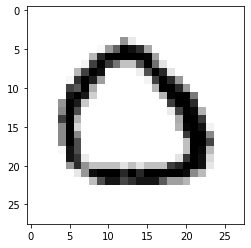

Example 483


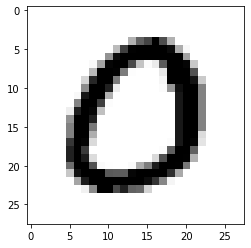

Example 484


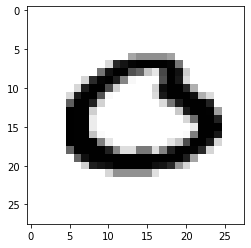

Example 485


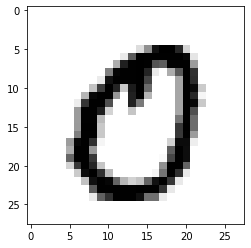

Example 486


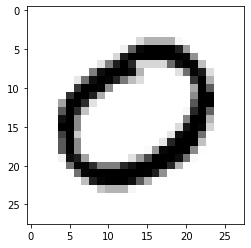

Example 487


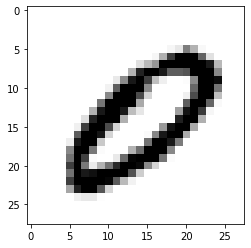

Example 488


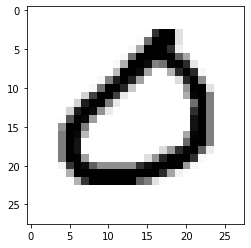

Example 489


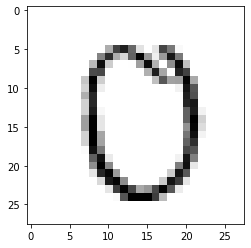

Example 490


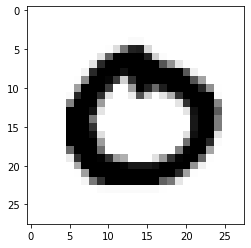

Example 491


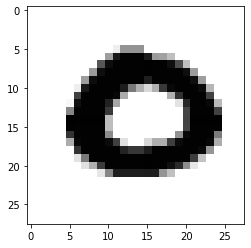

Example 492


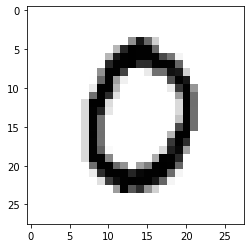

Example 493


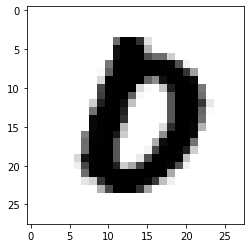

Example 494


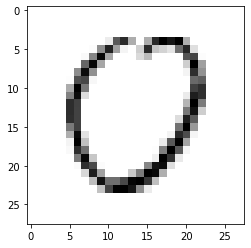

Example 495


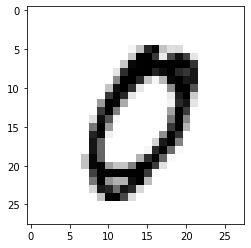

Example 496


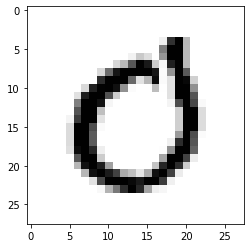

Example 497


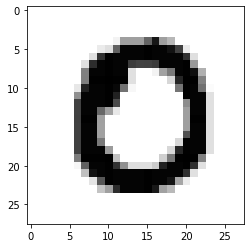

Example 498


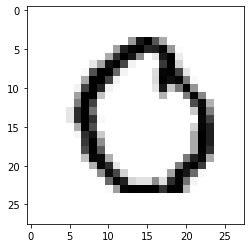

Example 499


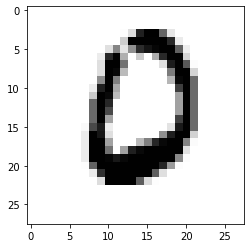

Example 500


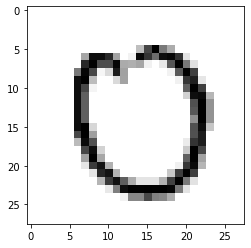

Example 501


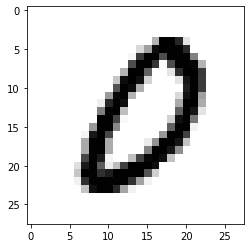

Example 502


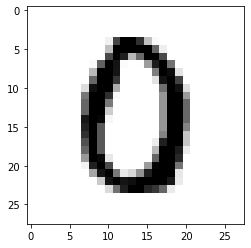

Example 503


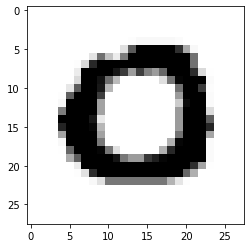

Example 504


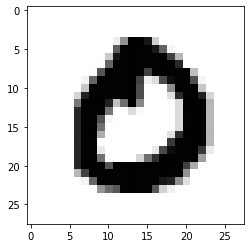

Example 505


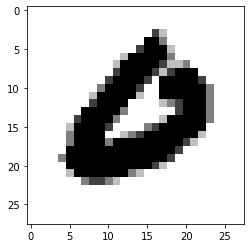

Example 506


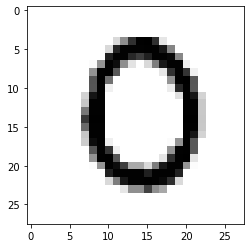

Example 507


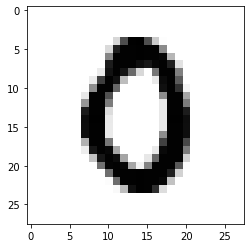

Example 508


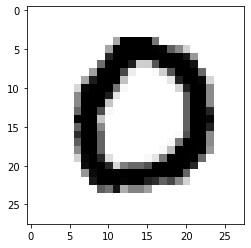

Example 509


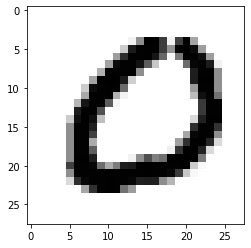

Example 510


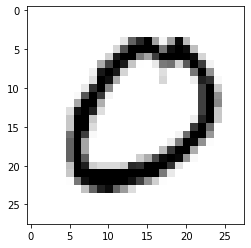

Example 511


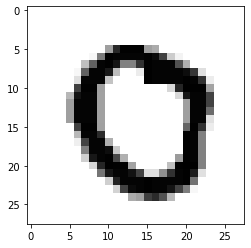

Example 512


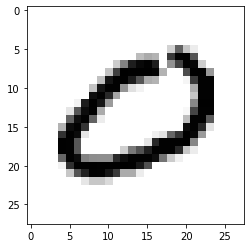

Example 513


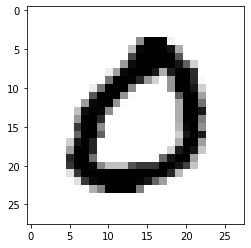

Example 514


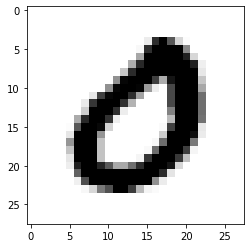

Example 515


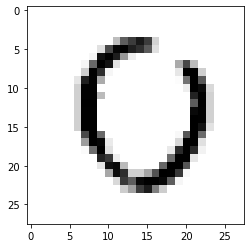

Example 516


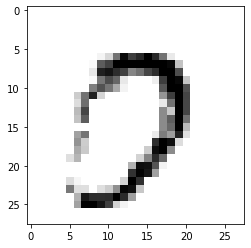

Example 517


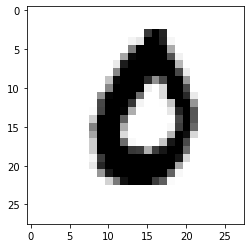

Example 518


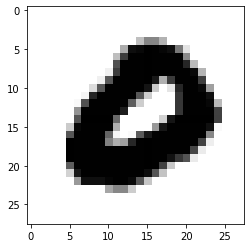

Example 519


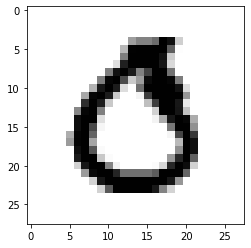

Example 520


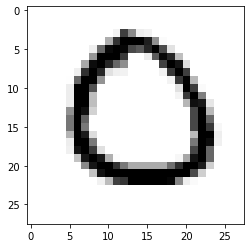

Example 521


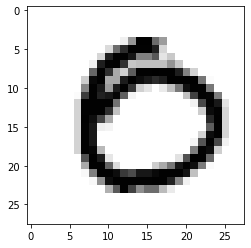

Example 522


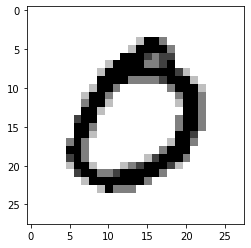

Example 523


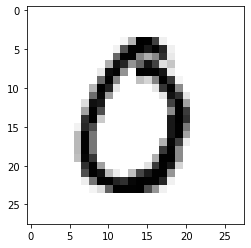

Example 524


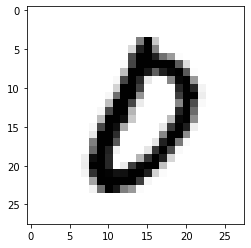

Example 525


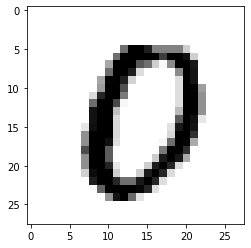

Example 526


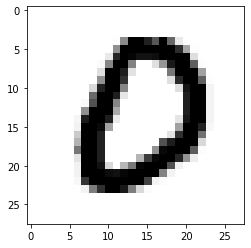

Example 527


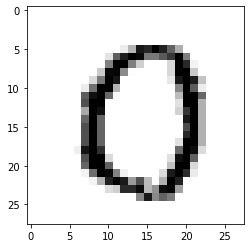

Example 528


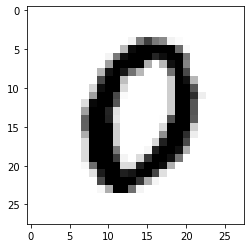

Example 529


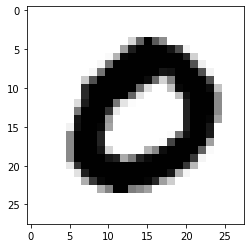

Example 530


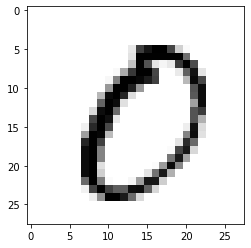

Example 531


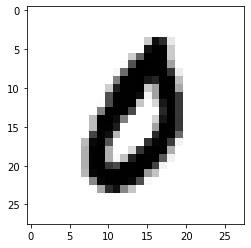

Example 532


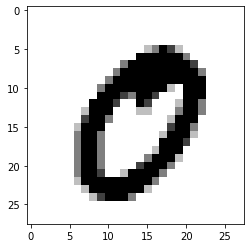

Example 533


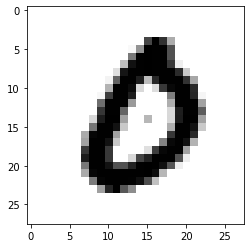

Example 534


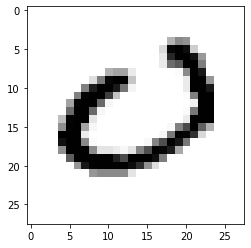

Example 535


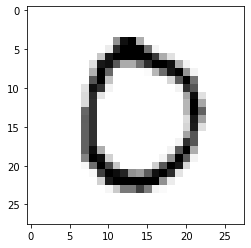

Example 536


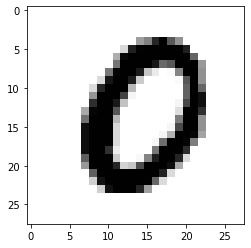

Example 537


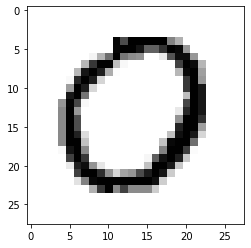

Example 538


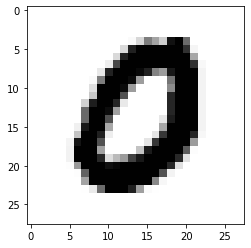

Example 539


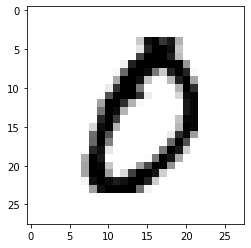

Example 540


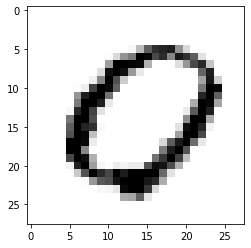

Example 541


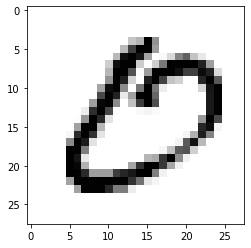

Example 542


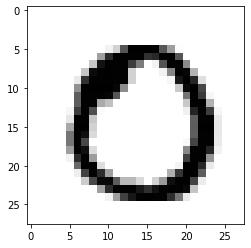

Example 543


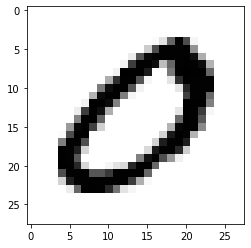

Example 544


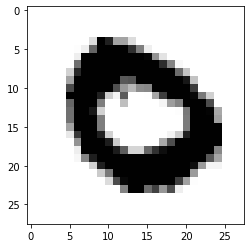

Example 545


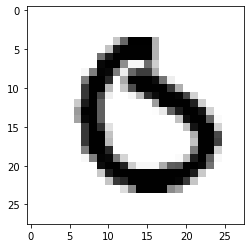

Example 546


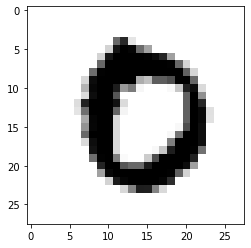

Example 547


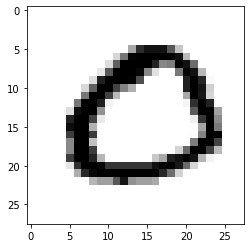

Example 548


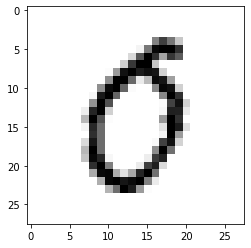

Example 549


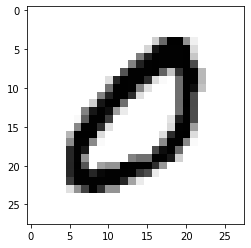

Example 550


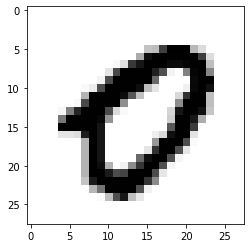

Example 551


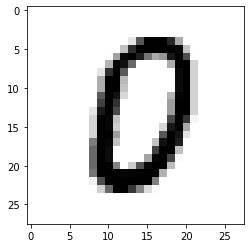

Example 552


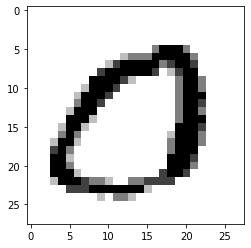

Example 553


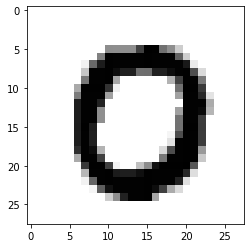

Example 554


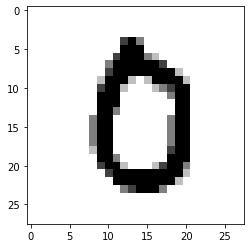

Example 555


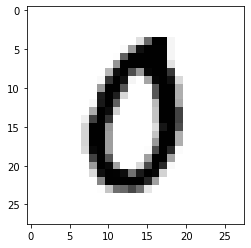

Example 556


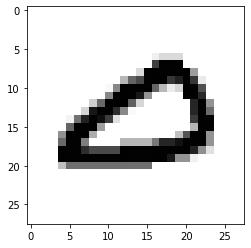

Example 557


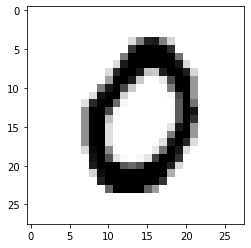

Example 558


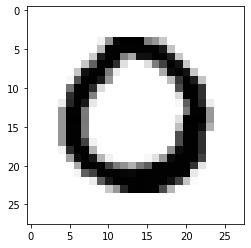

Example 559


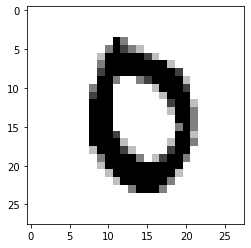

Example 560


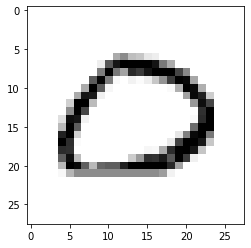

Example 561


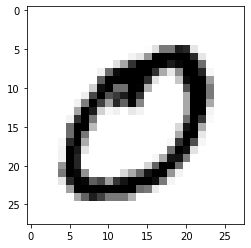

Example 562


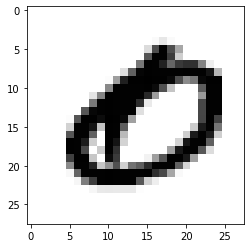

Example 563


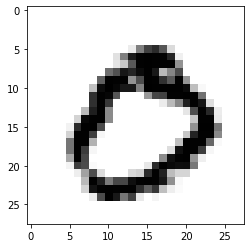

Example 564


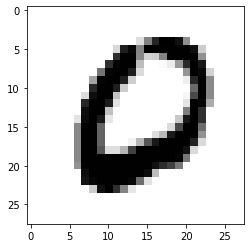

Example 565


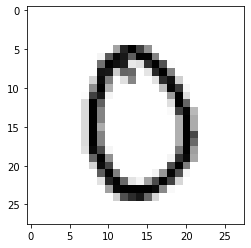

Example 566


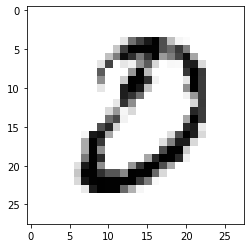

Example 567


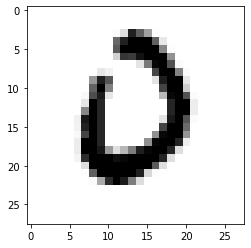

Example 568


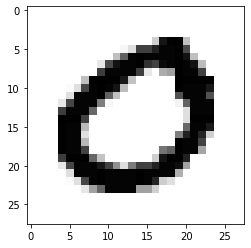

Example 569


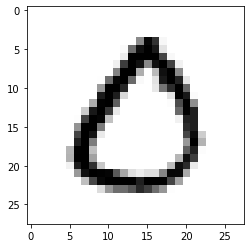

Example 570


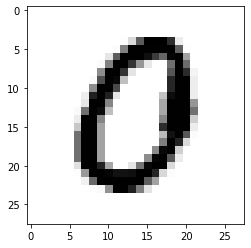

Example 571


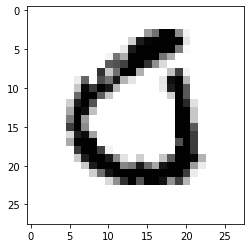

Example 572


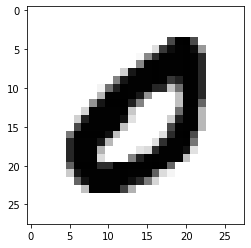

Example 573


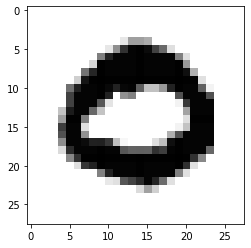

Example 574


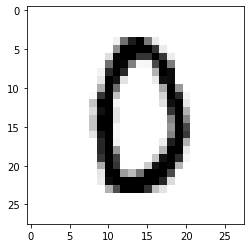

Example 575


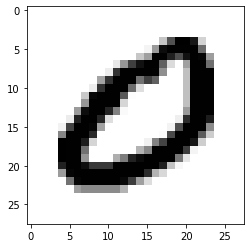

Example 576


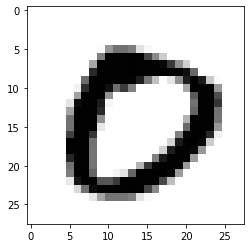

Example 577


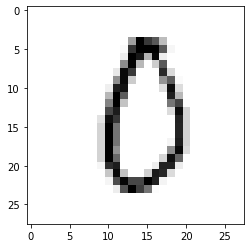

Example 578


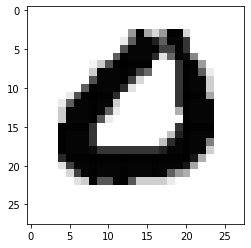

Example 579


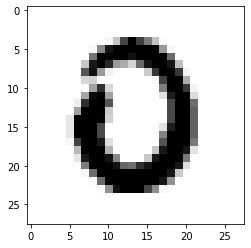

Example 580


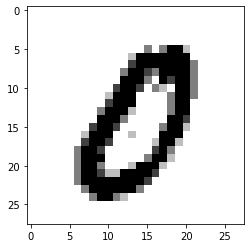

Example 581


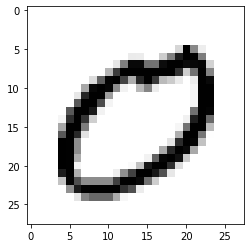

Example 582


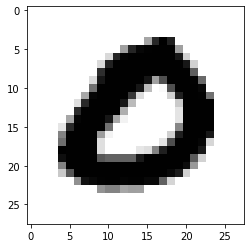

Example 583


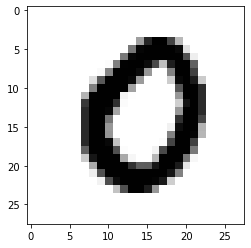

Example 584


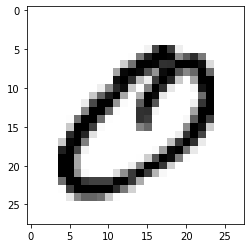

Example 585


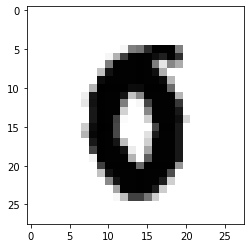

Example 586


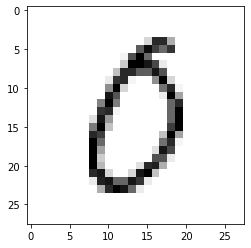

Example 587


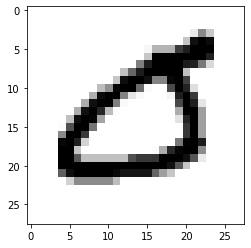

Example 588


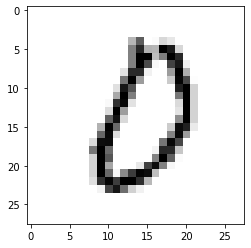

Example 589


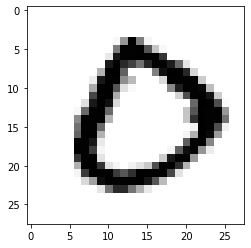

Example 590


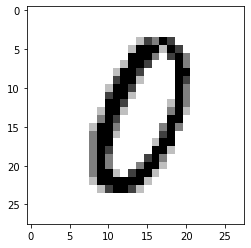

Example 591


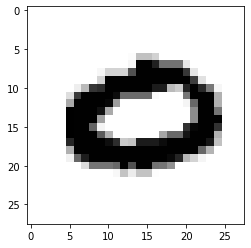

Example 592


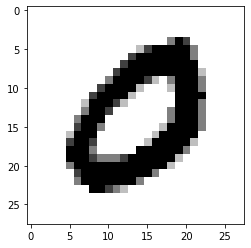

Example 593


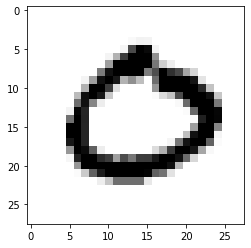

Example 594


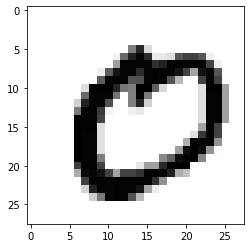

Example 595


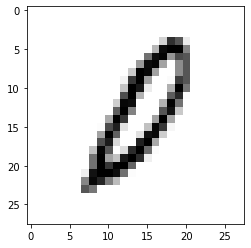

Example 596


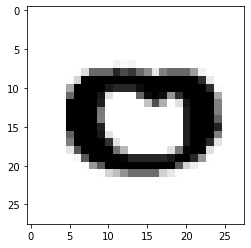

Example 597


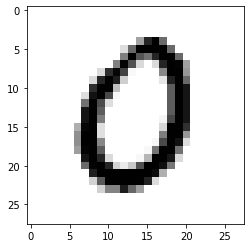

Example 598


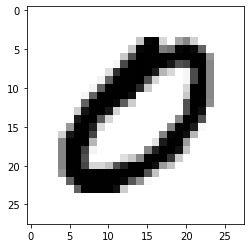

Example 599


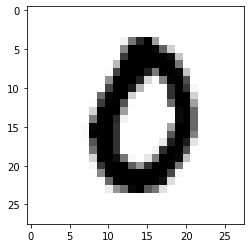

Example 600


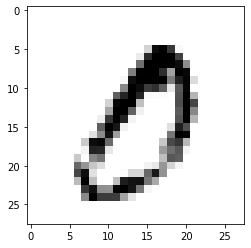

Example 601


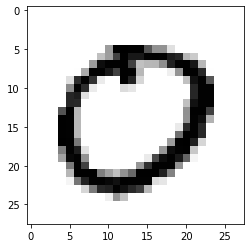

Example 602


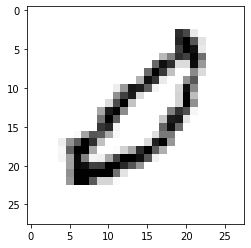

Example 603


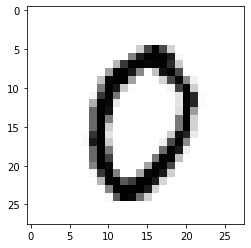

Example 604


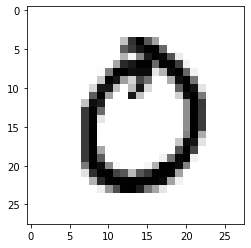

Example 605


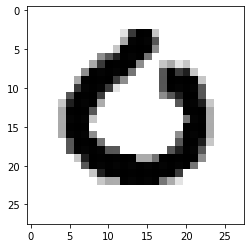

Example 606


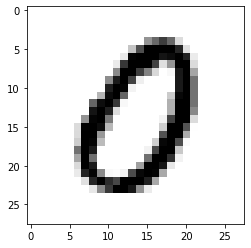

Example 607


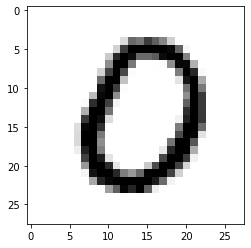

Example 608


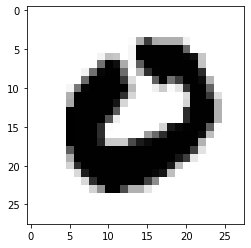

Example 609


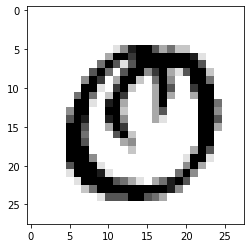

Example 610


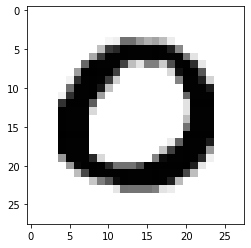

Example 611


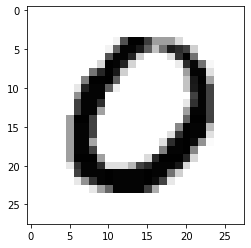

Example 612


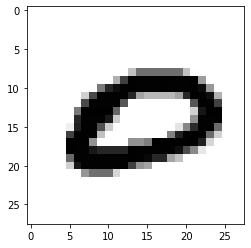

Example 613


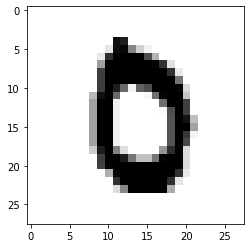

Example 614


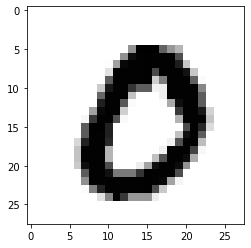

Example 615


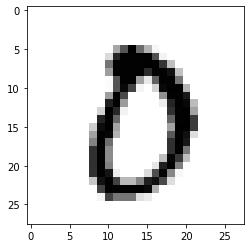

Example 616


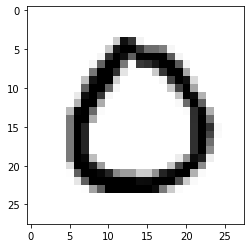

Example 617


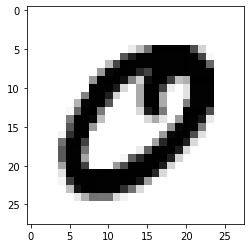

Example 618


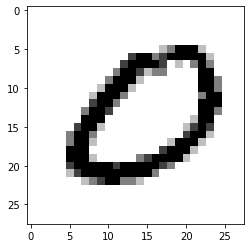

Example 619


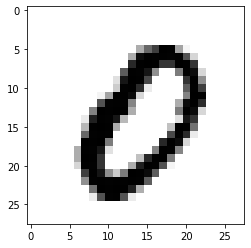

Example 620


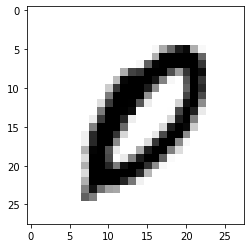

Example 621


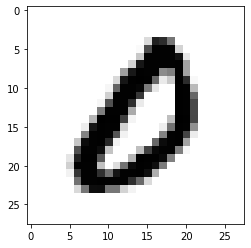

Example 622


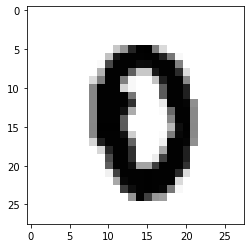

Example 623


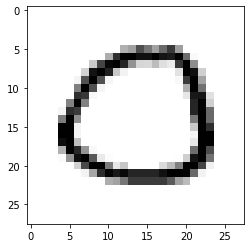

Example 624


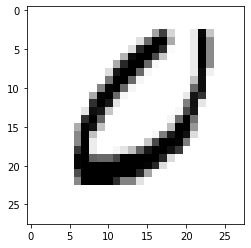

Example 625


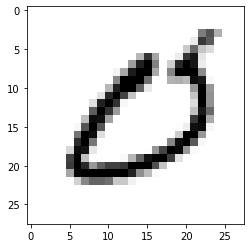

Example 626


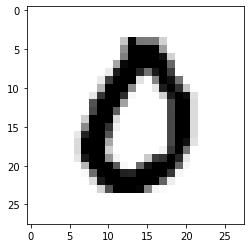

Example 627


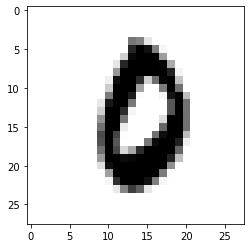

Example 628


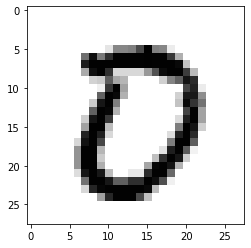

Example 629


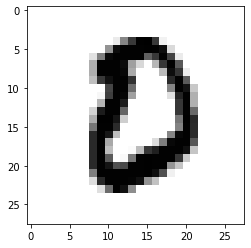

Example 630


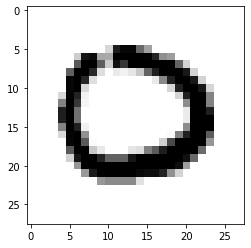

Example 631


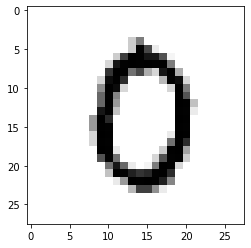

Example 632


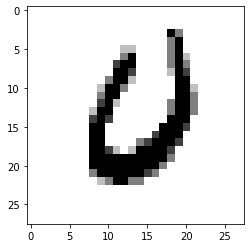

Example 633


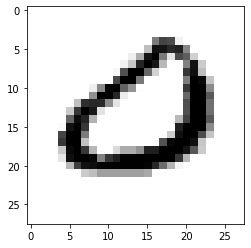

Example 634


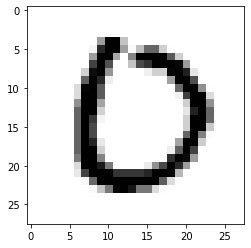

Example 635


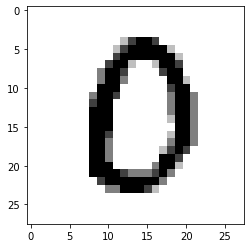

Example 636


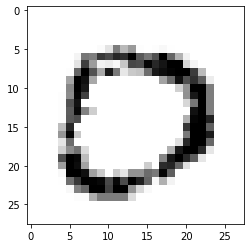

Example 637


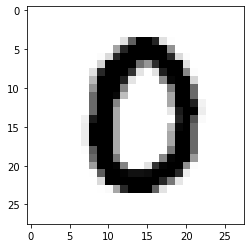

Example 638


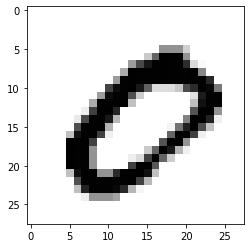

Example 639


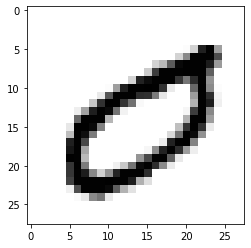

Example 640


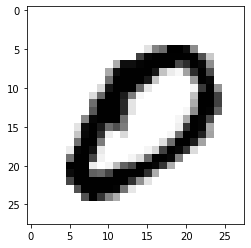

Example 641


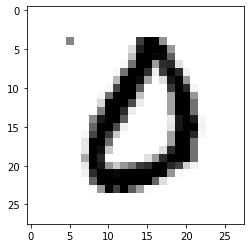

Example 642


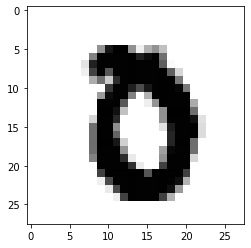

Example 643


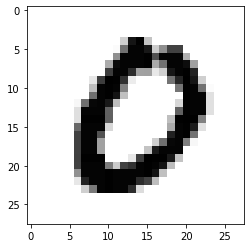

Example 644


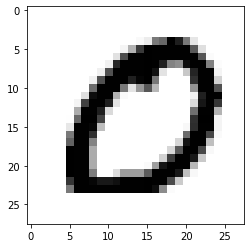

Example 645


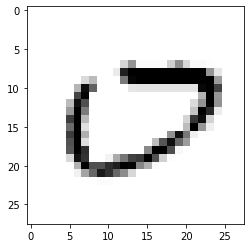

Example 646


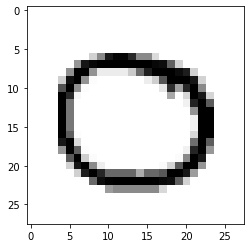

Example 647


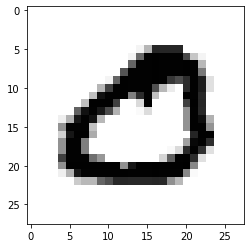

Example 648


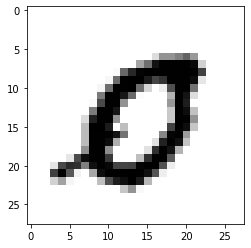

Example 649


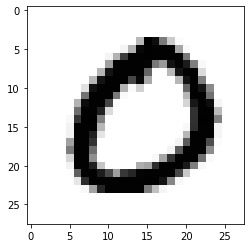

Example 650


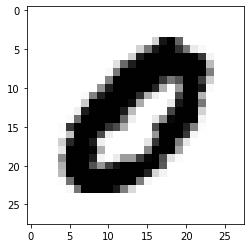

Example 651


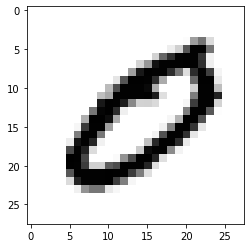

Example 652


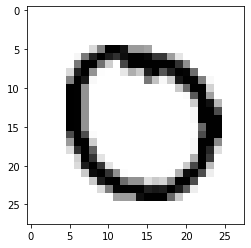

Example 653


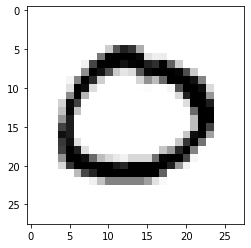

Example 654


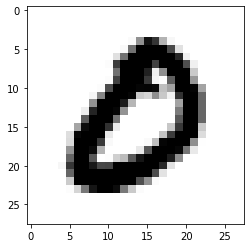

Example 655


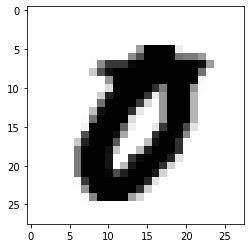

Example 656


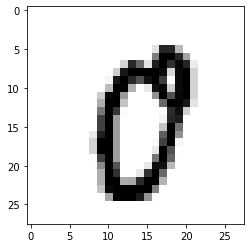

Example 657


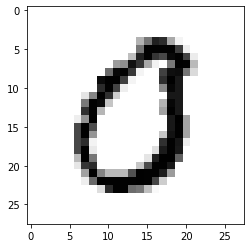

Example 658


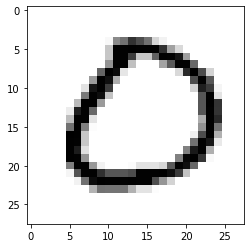

Example 659


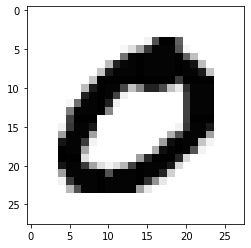

Example 660


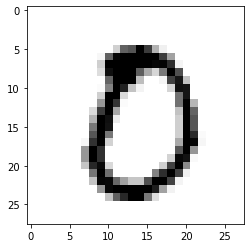

Example 661


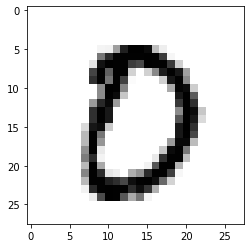

Example 662


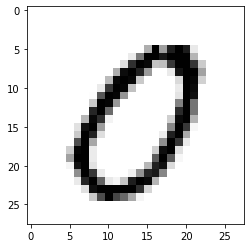

Example 663


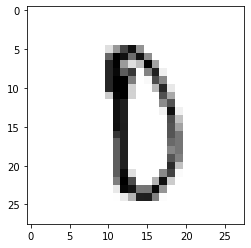

Example 664


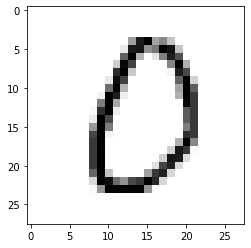

Example 665


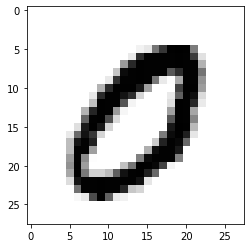

Example 666


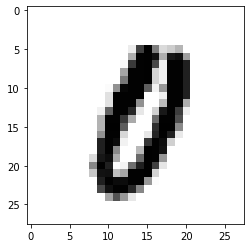

Example 667


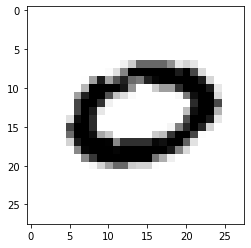

Example 668


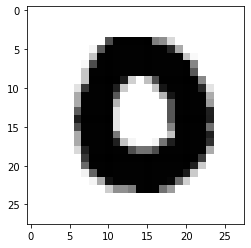

Example 669


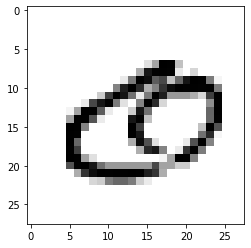

Example 670


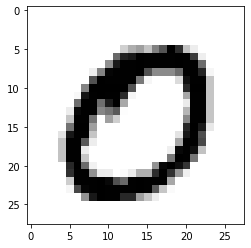

Example 671


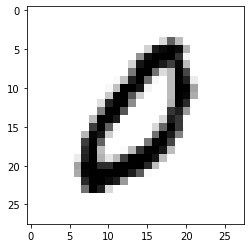

Example 672


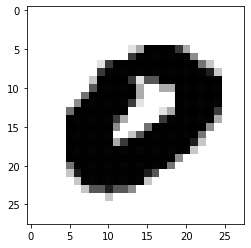

Example 673


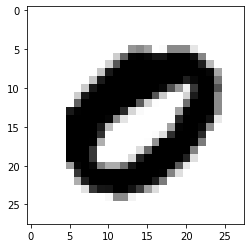

Example 674


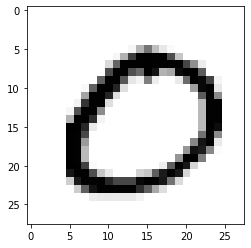

Example 675


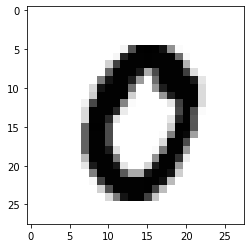

Example 676


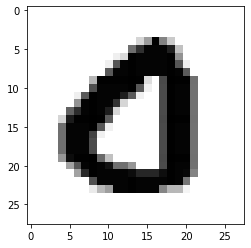

Example 677


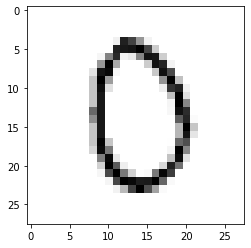

Example 678


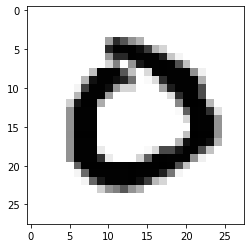

Example 679


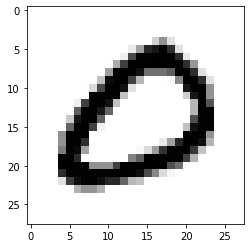

Example 680


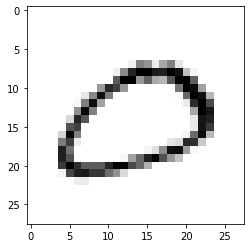

Example 681


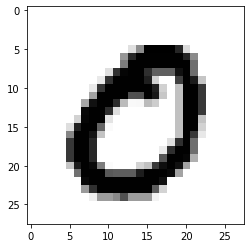

Example 682


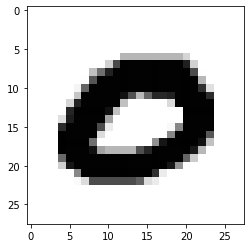

Example 683


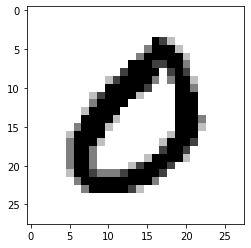

Example 684


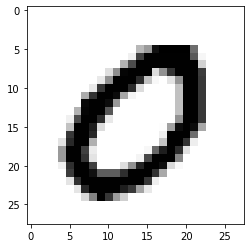

Example 685


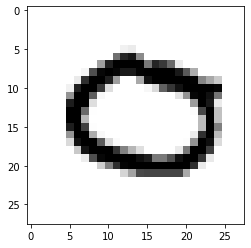

Example 686


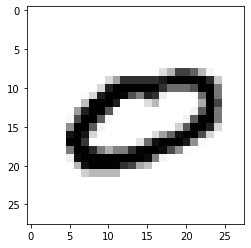

Example 687


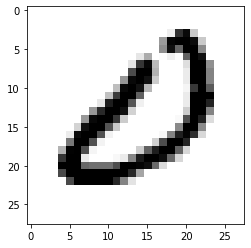

Example 688


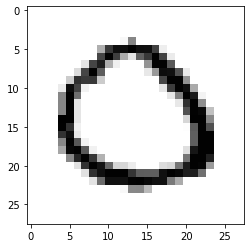

Example 689


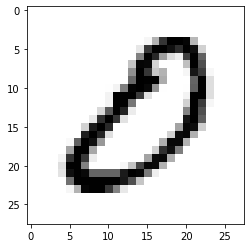

Example 690


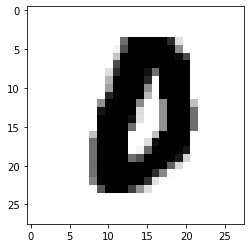

Example 691


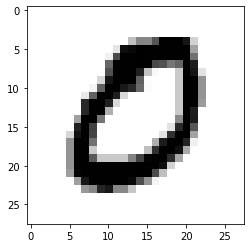

Example 692


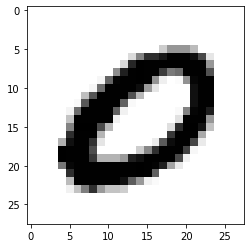

Example 693


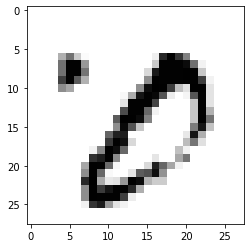

Example 694


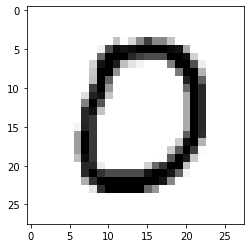

Example 695


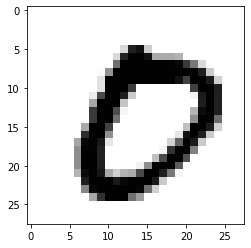

Example 696


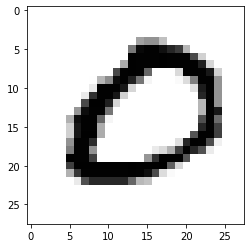

Example 697


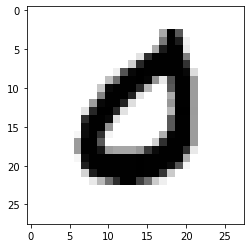

Example 698


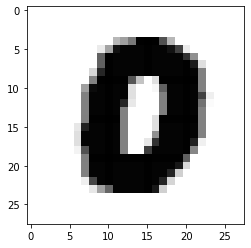

Example 699


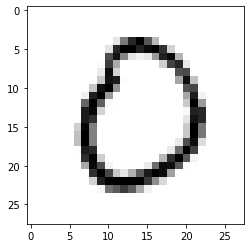

Example 700


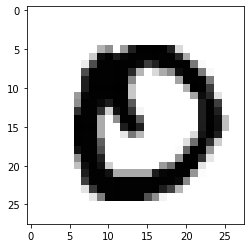

Example 701


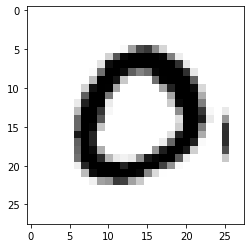

Example 702


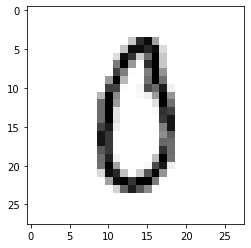

Example 703


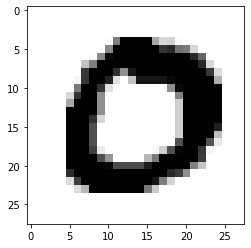

Example 704


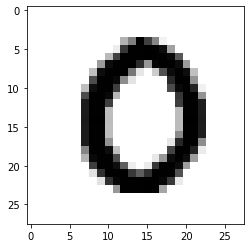

Example 705


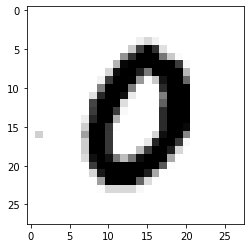

Example 706


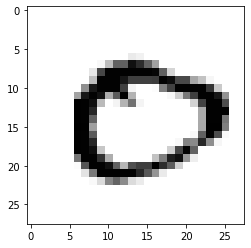

Example 707


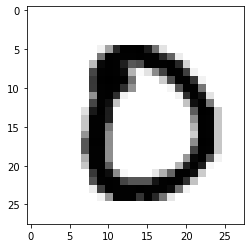

Example 708


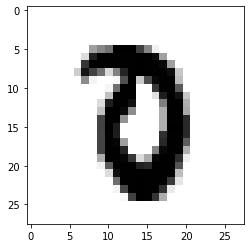

Example 709


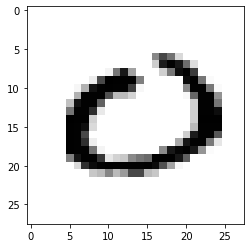

Example 710


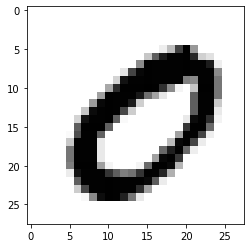

Example 711


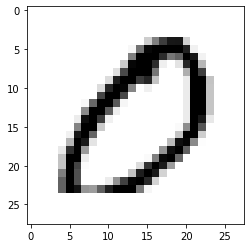

Example 712


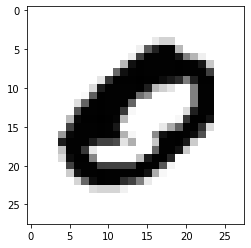

Example 713


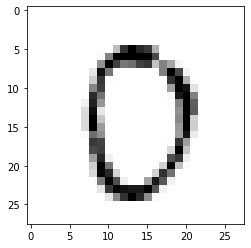

Example 714


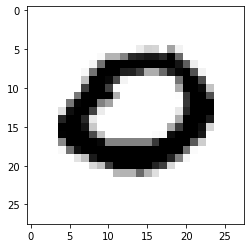

Example 715


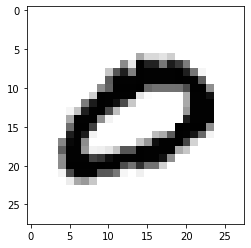

Example 716


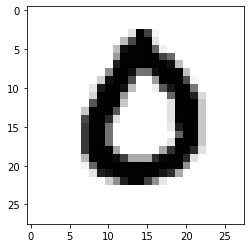

Example 717


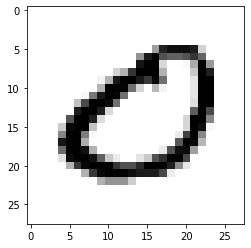

Example 718


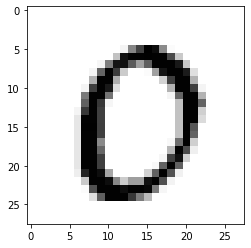

Example 719


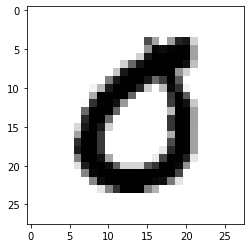

Example 720


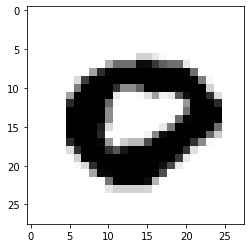

Example 721


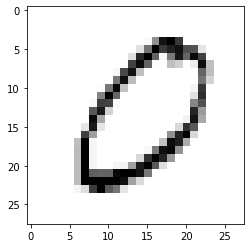

Example 722


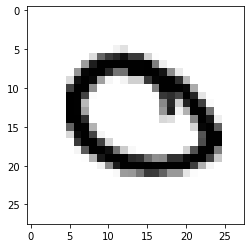

Example 723


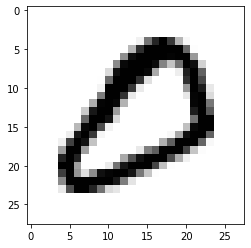

Example 724


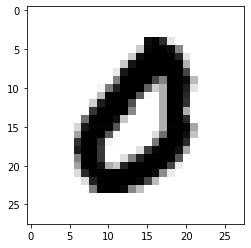

Example 725


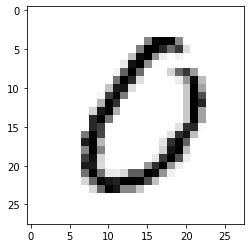

Example 726


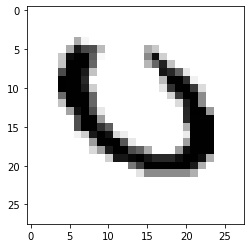

Example 727


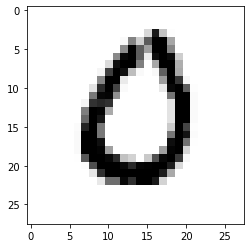

Example 728


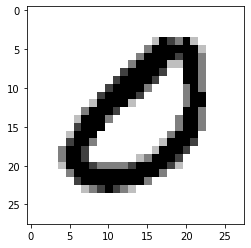

Example 729


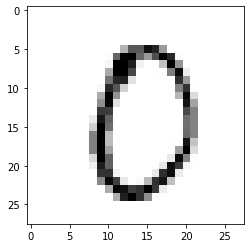

Example 730


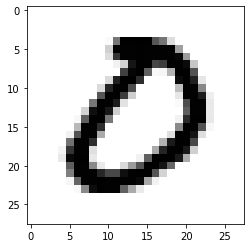

Example 731


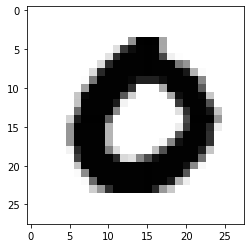

Example 732


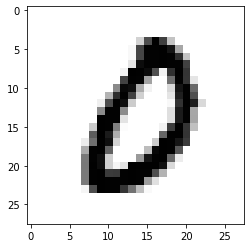

Example 733


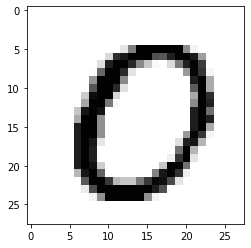

Example 734


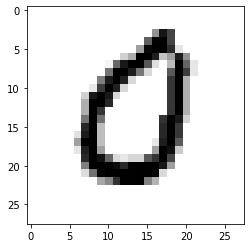

Example 735


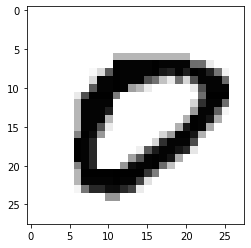

Example 736


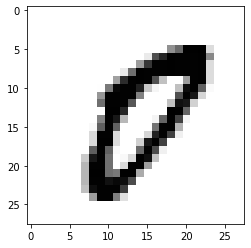

Example 737


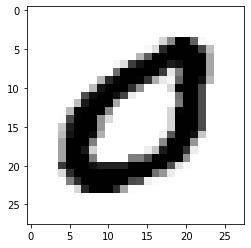

Example 738


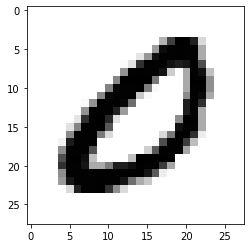

Example 739


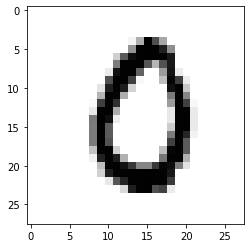

Example 740


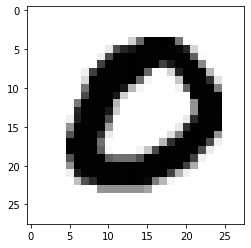

Example 741


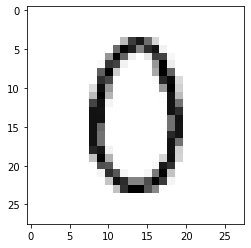

Example 742


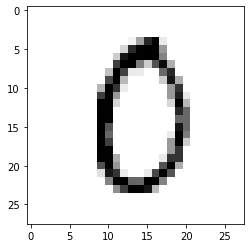

Example 743


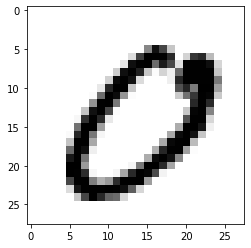

Example 744


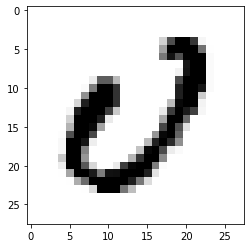

Example 745


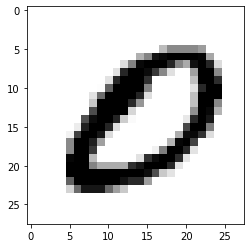

Example 746


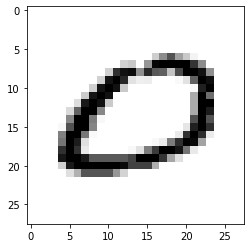

Example 747


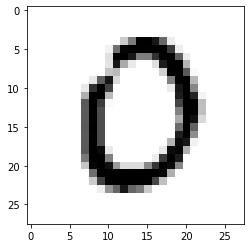

Example 748


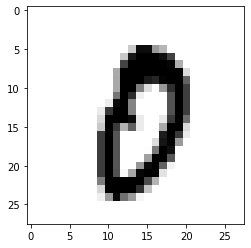

Example 749


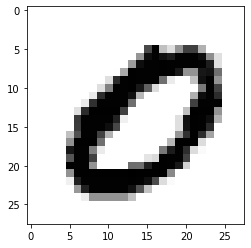

Example 750


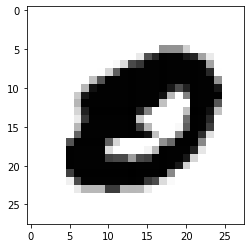

Example 751


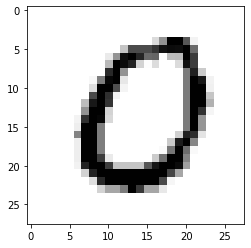

Example 752


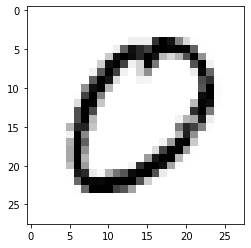

Example 753


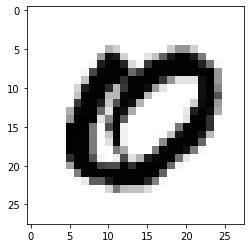

Example 754


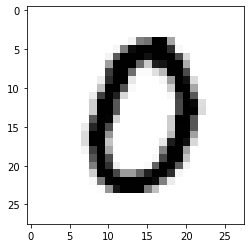

Example 755


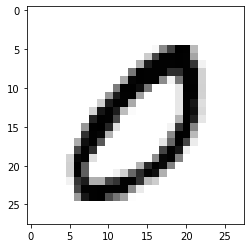

Example 756


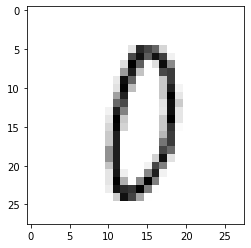

Example 757


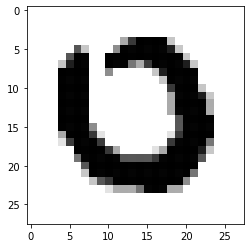

Example 758


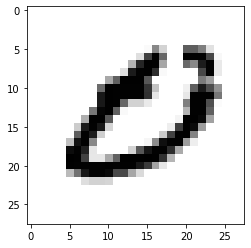

Example 759


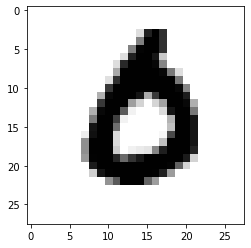

Example 760


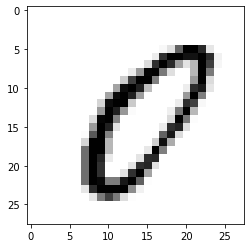

Example 761


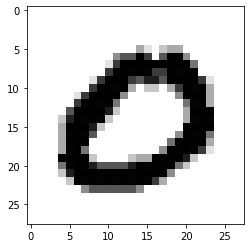

Example 762


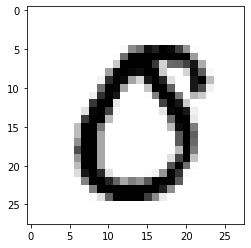

Example 763


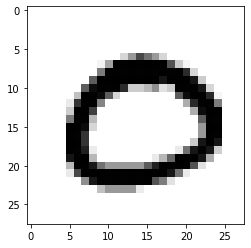

Example 764


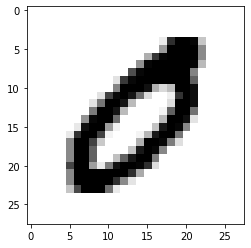

Example 765


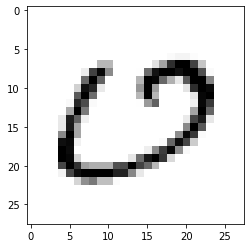

Example 766


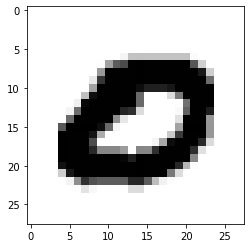

Example 767


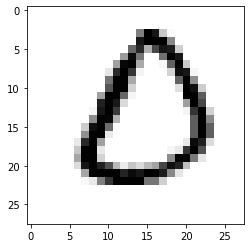

Example 768


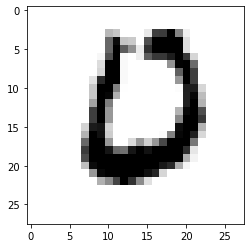

Example 769


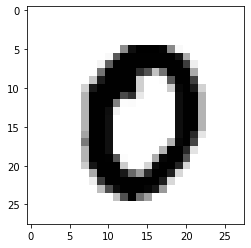

Example 770


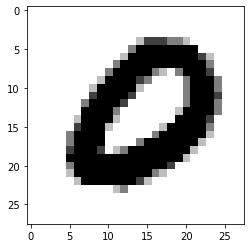

Example 771


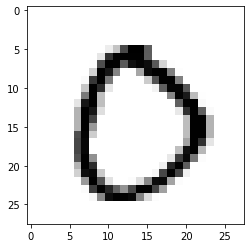

Example 772


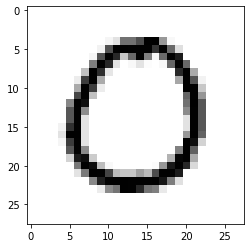

Example 773


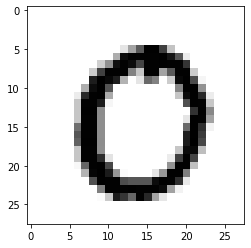

Example 774


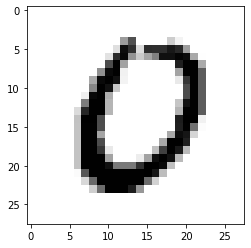

Example 775


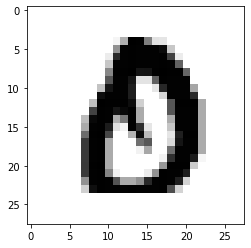

Example 776


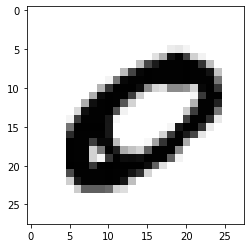

Example 777


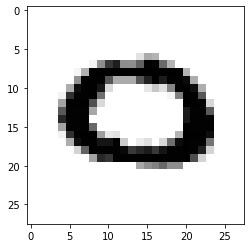

Example 778


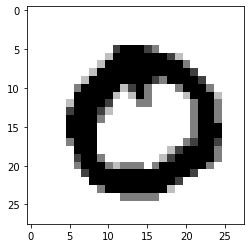

Example 779


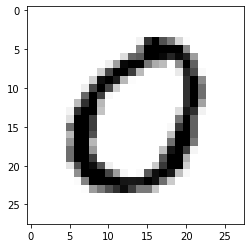

Example 780


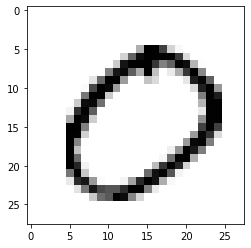

Example 781


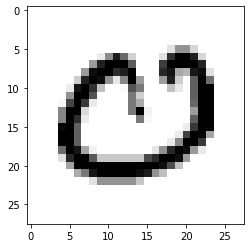

Example 782


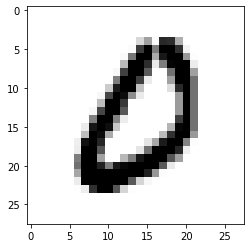

Example 783


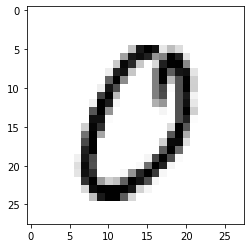

Example 784


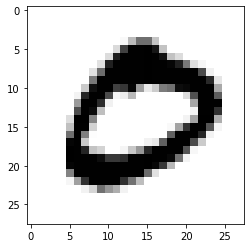

Example 785


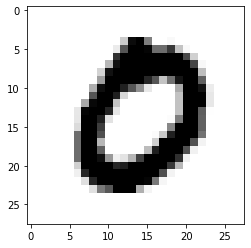

Example 786


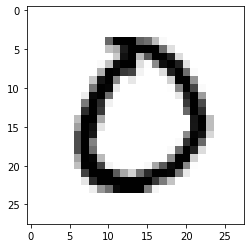

Example 787


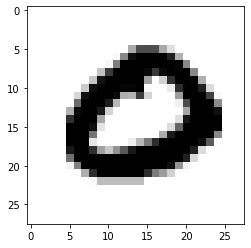

Example 788


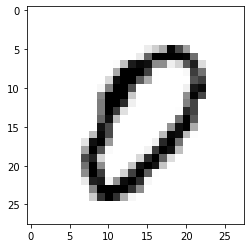

Example 789


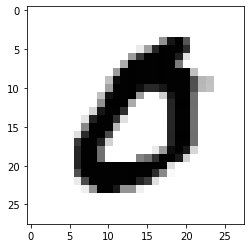

Example 790


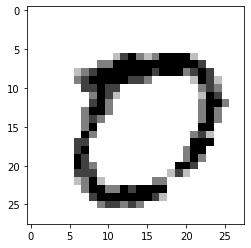

Example 791


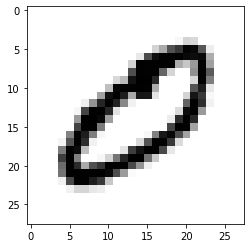

Example 792


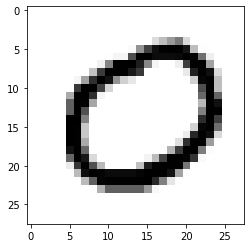

Example 793


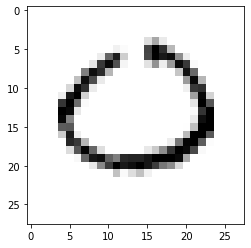

Example 794


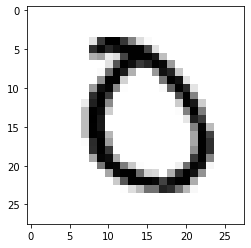

Example 795


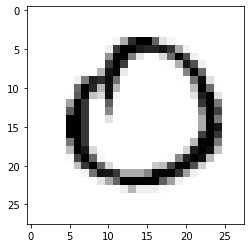

Example 796


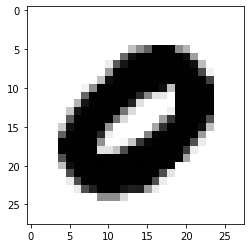

Example 797


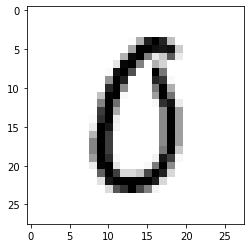

Example 798


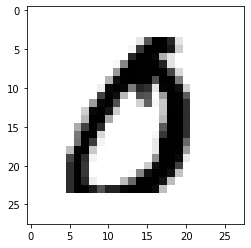

Example 799


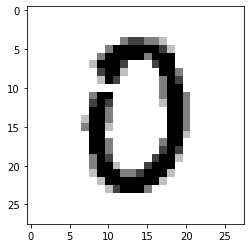

Example 800


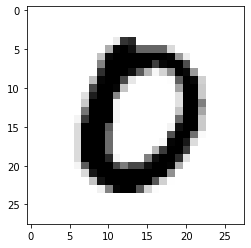

Example 801


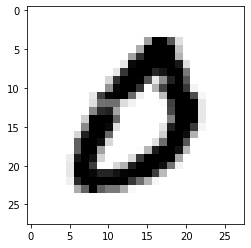

Example 802


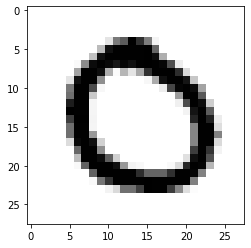

Example 803


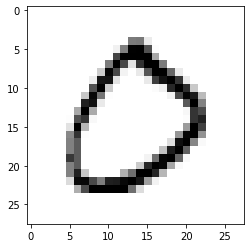

Example 804


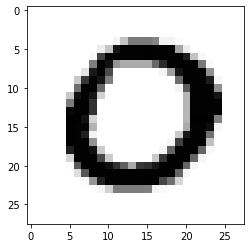

Example 805


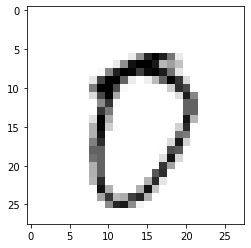

Example 806


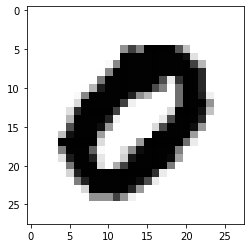

Example 807


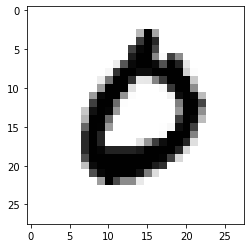

Example 808


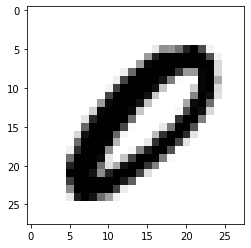

Example 809


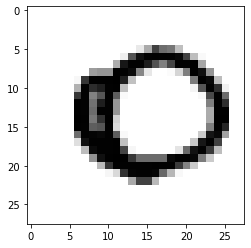

Example 810


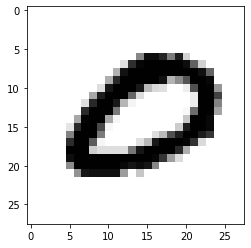

Example 811


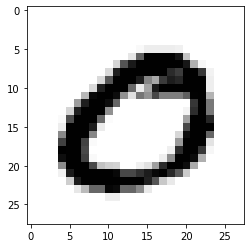

Example 812


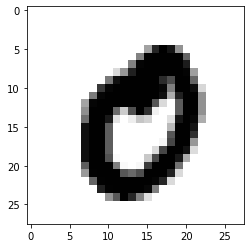

Example 813


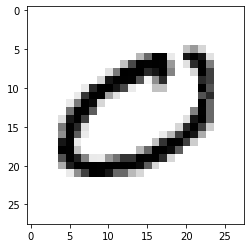

Example 814


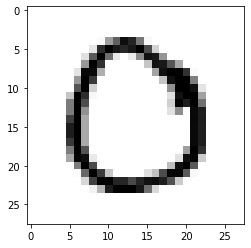

Example 815


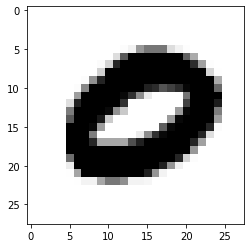

Example 816


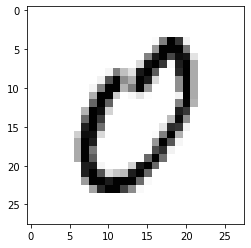

Example 817


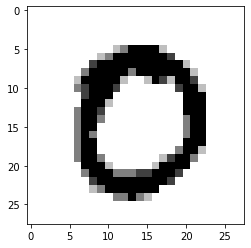

Example 818


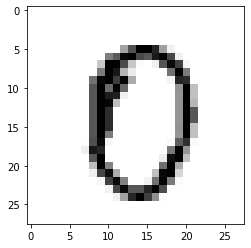

Example 819


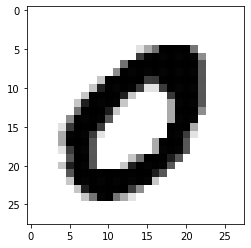

Example 820


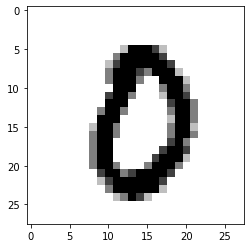

Example 821


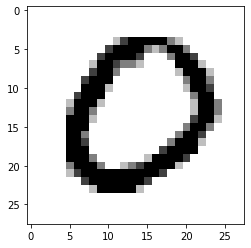

Example 822


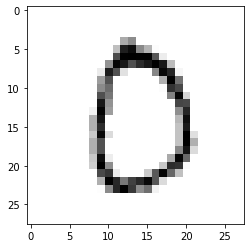

Example 823


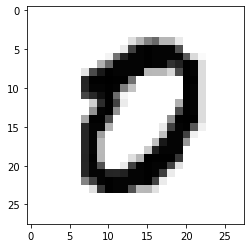

Example 824


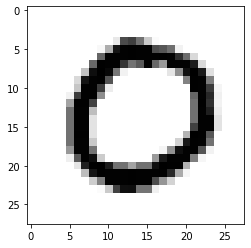

Example 825


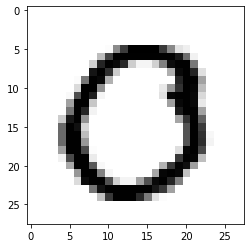

Example 826


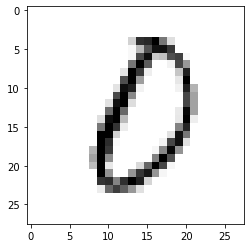

Example 827


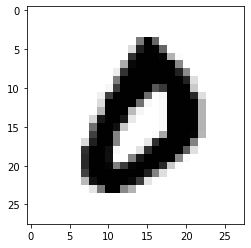

Example 828


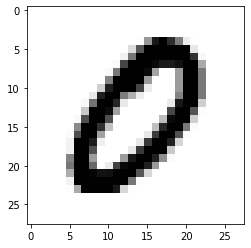

Example 829


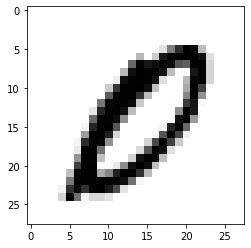

Example 830


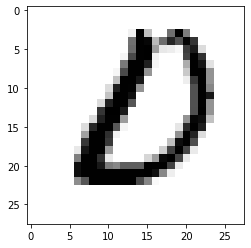

Example 831


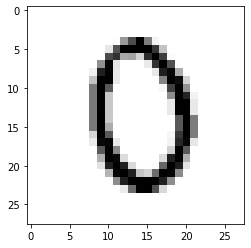

Example 832


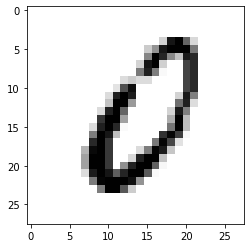

Example 833


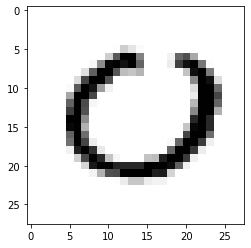

Example 834


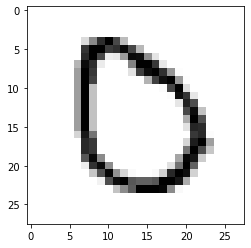

Example 835


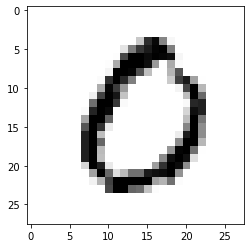

Example 836


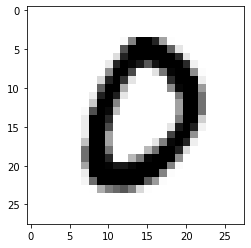

Example 837


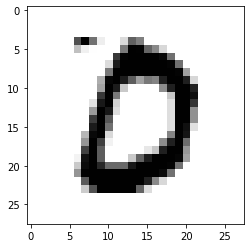

Example 838


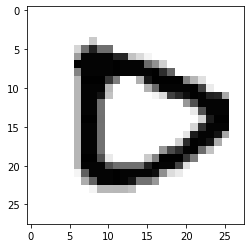

Example 839


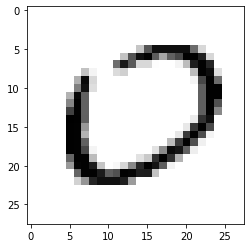

Example 840


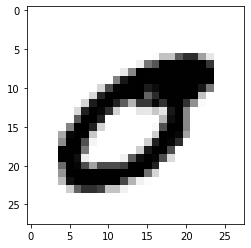

Example 841


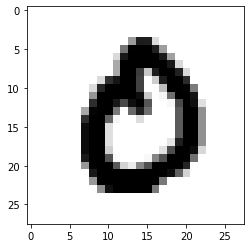

Example 842


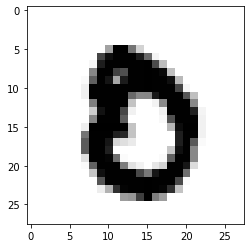

Example 843


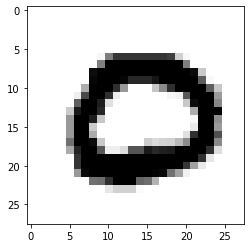

Example 844


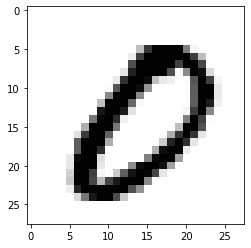

Example 845


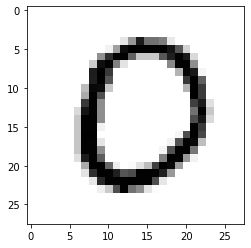

Example 846


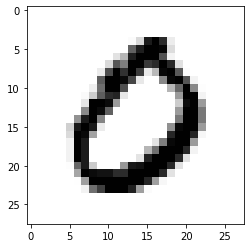

Example 847


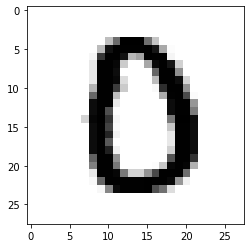

Example 848


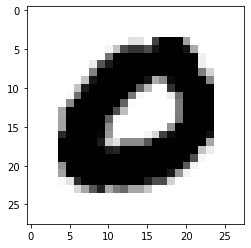

Example 849


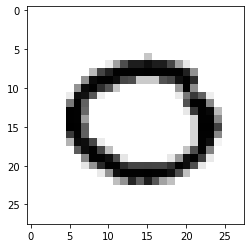

Example 850


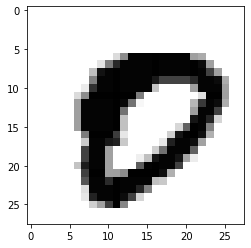

Example 851


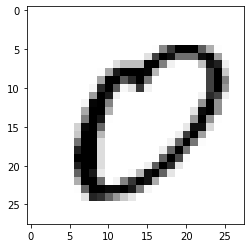

Example 852


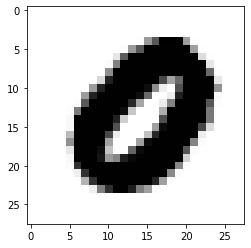

Example 853


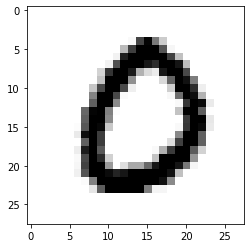

Example 854


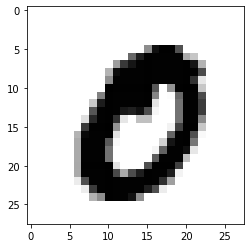

Example 855


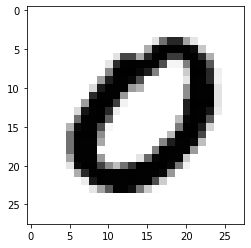

Example 856


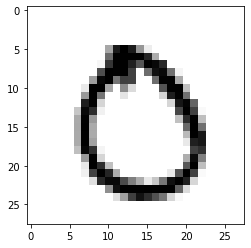

Example 857


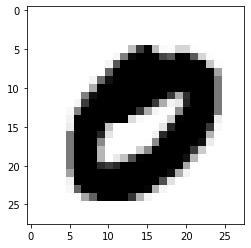

Example 858


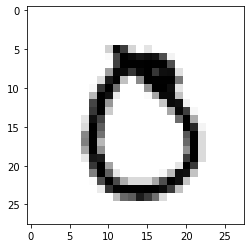

Example 859


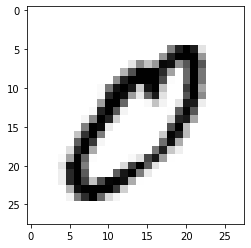

Example 860


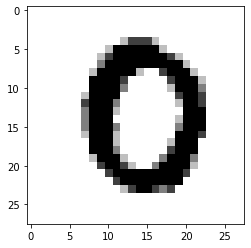

Example 861


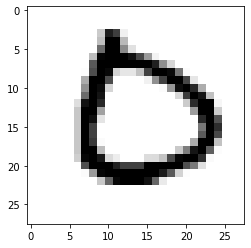

Example 862


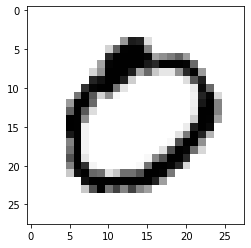

Example 863


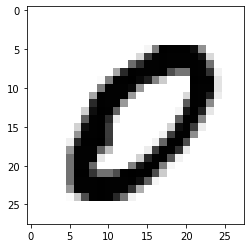

Example 864


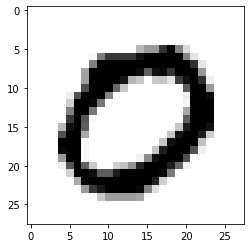

Example 865


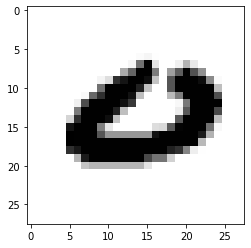

Example 866


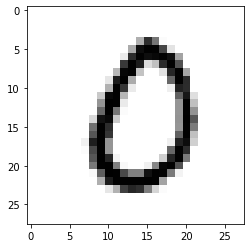

Example 867


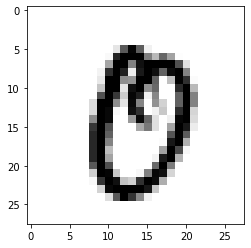

Example 868


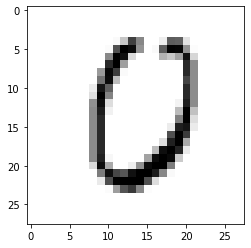

Example 869


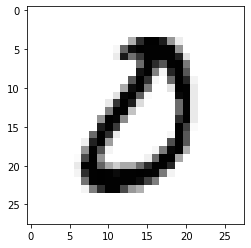

Example 870


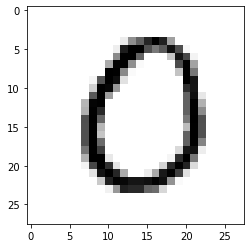

Example 871


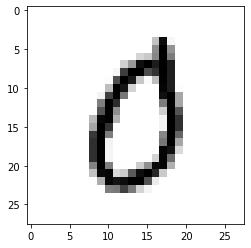

Example 872


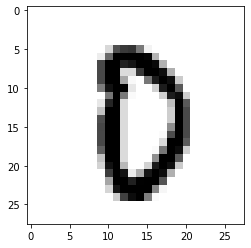

Example 873


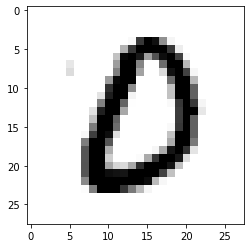

Example 874


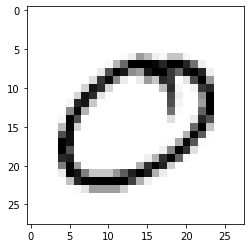

Example 875


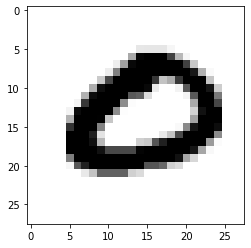

Example 876


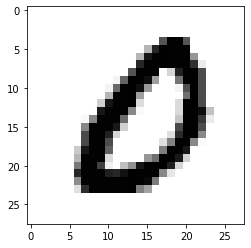

Example 877


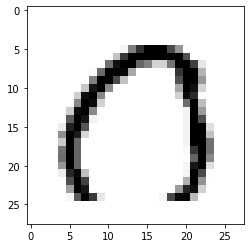

Example 878


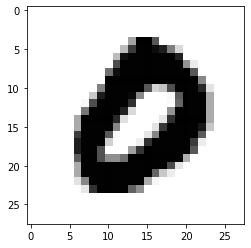

Example 879


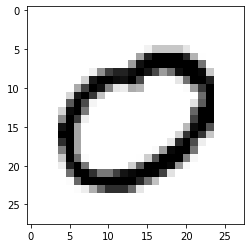

Example 880


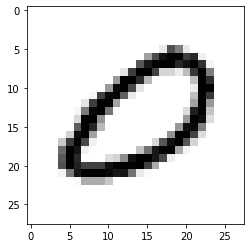

Example 881


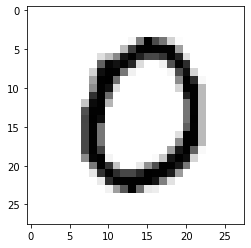

Example 882


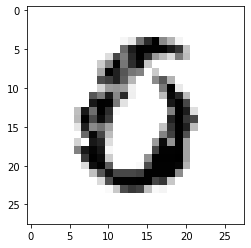

Example 883


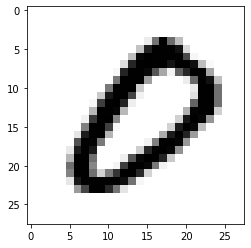

Example 884


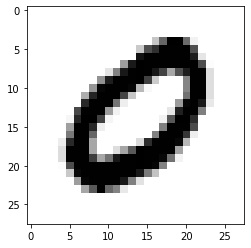

Example 885


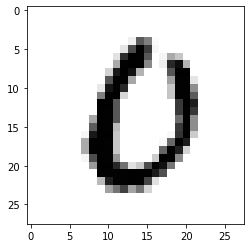

Example 886


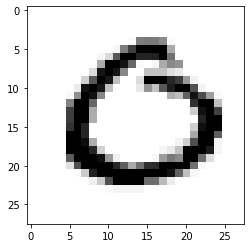

Example 887


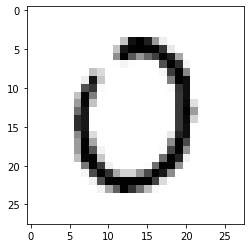

Example 888


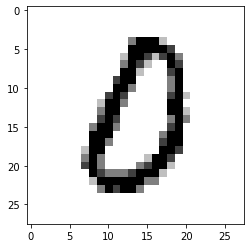

Example 889


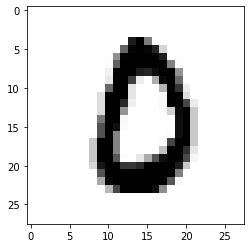

Example 890


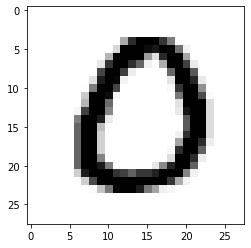

Example 891


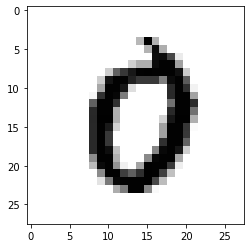

Example 892


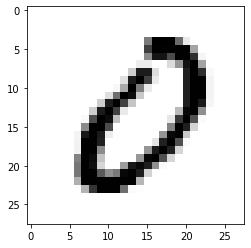

Example 893


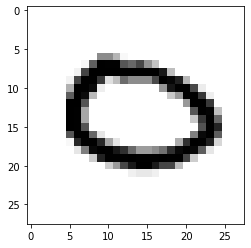

Example 894


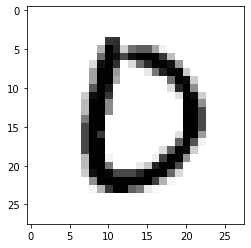

Example 895


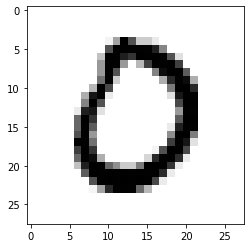

Example 896


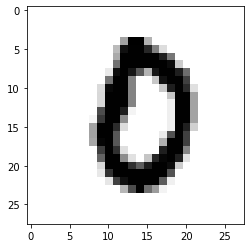

Example 897


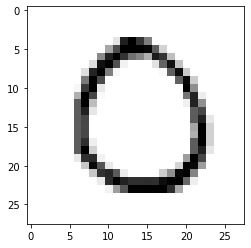

Example 898


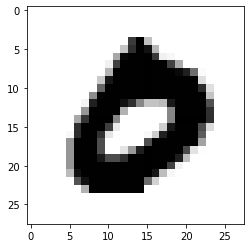

Example 899


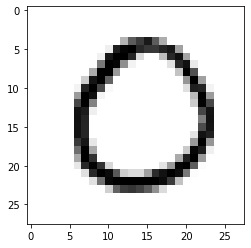

Example 900


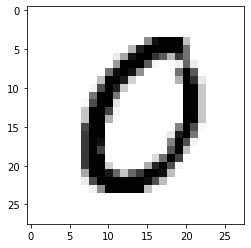

Example 901


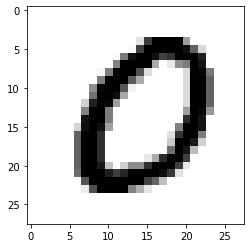

Example 902


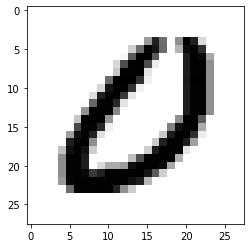

Example 903


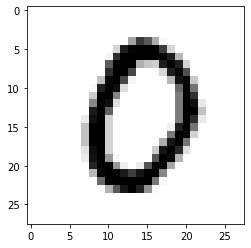

Example 904


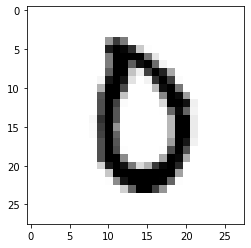

Example 905


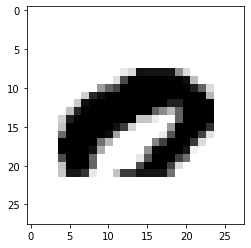

Example 906


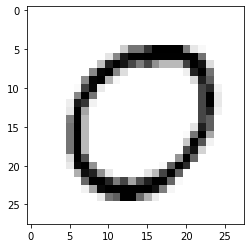

Example 907


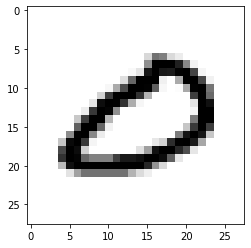

Example 908


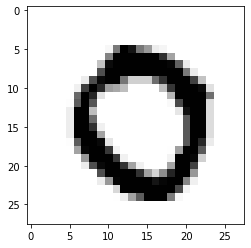

Example 909


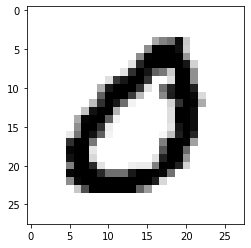

Example 910


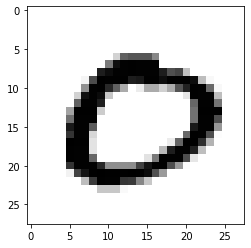

Example 911


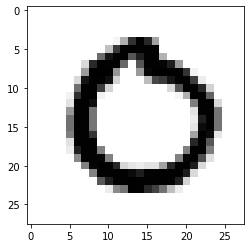

Example 912


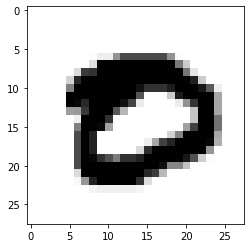

Example 913


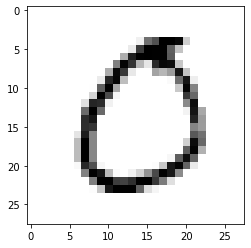

Example 914


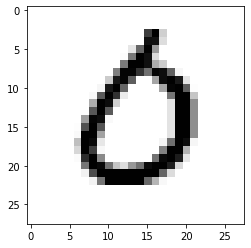

Example 915


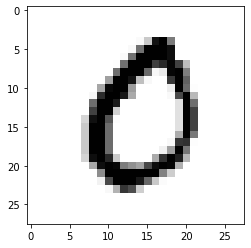

Example 916


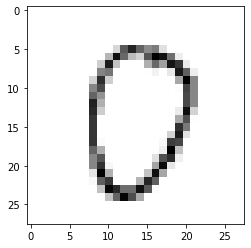

Example 917


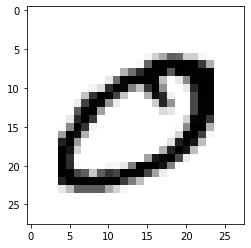

Example 918


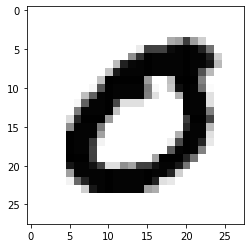

Example 919


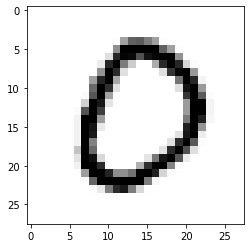

Example 920


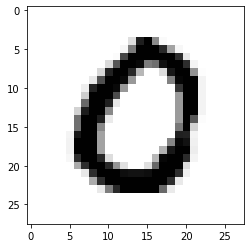

Example 921


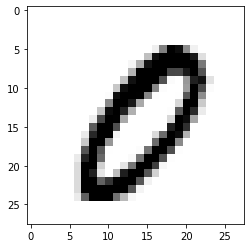

Example 922


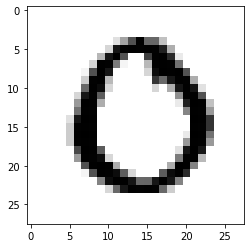

Example 923


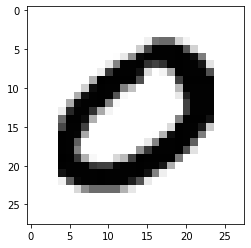

Example 924


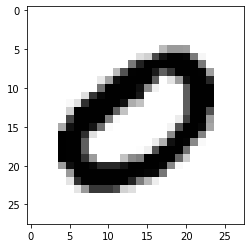

Example 925


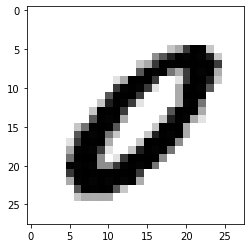

Example 926


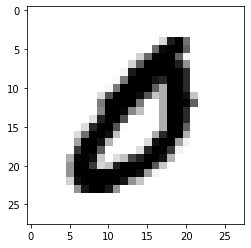

Example 927


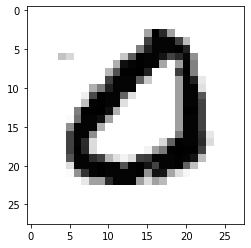

Example 928


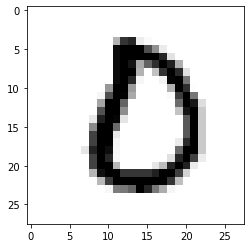

Example 929


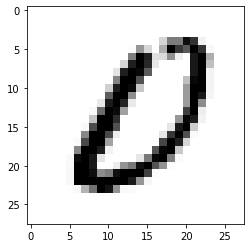

Example 930


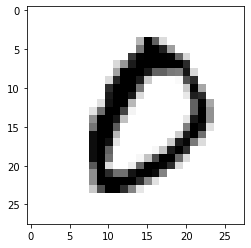

Example 931


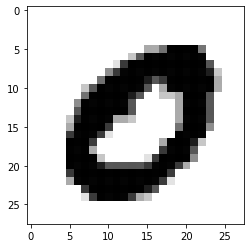

Example 932


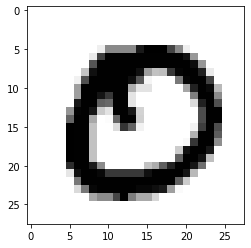

Example 933


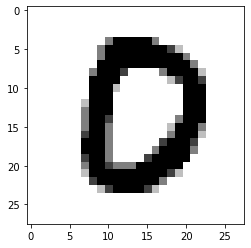

Example 934


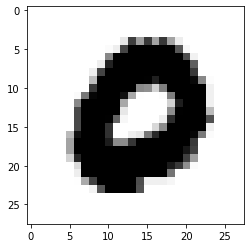

Example 935


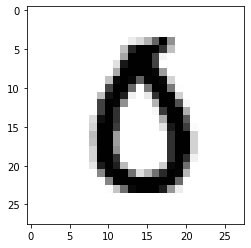

Example 936


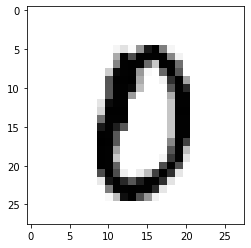

Example 937


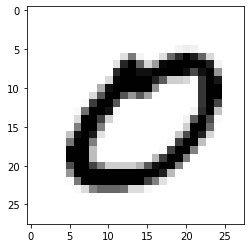

Example 938


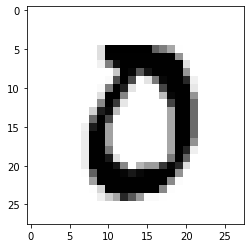

Example 939


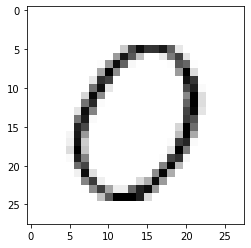

Example 940


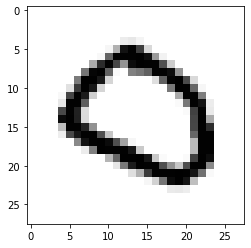

Example 941


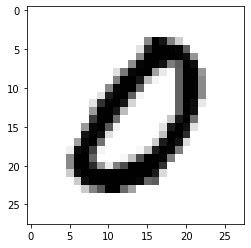

Example 942


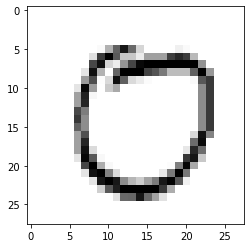

Example 943


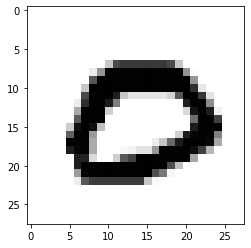

Example 944


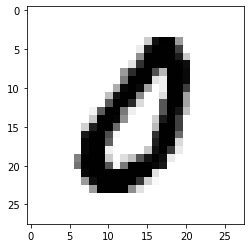

Example 945


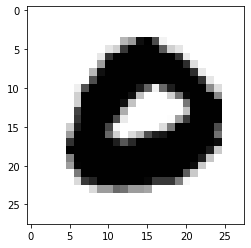

Example 946


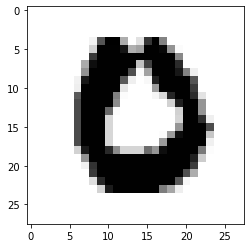

Example 947


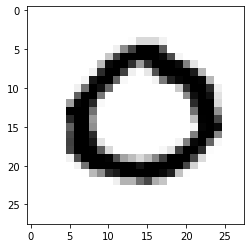

Example 948


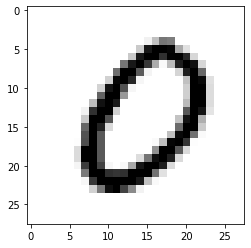

Example 949


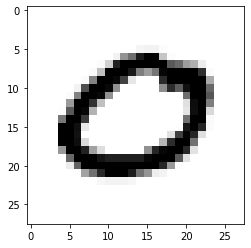

Example 950


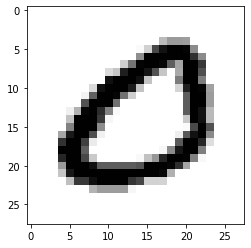

Example 951


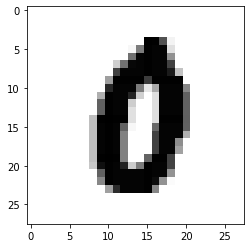

Example 952


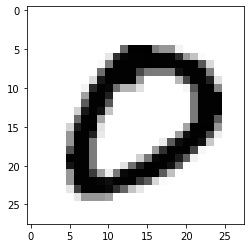

Example 953


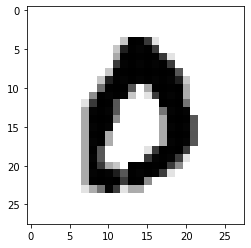

Example 954


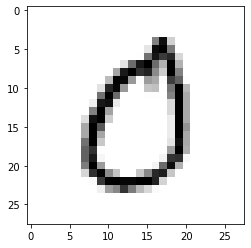

Example 955


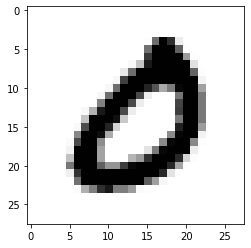

Example 956


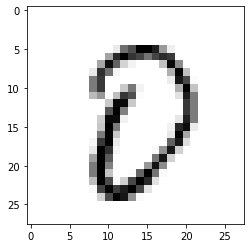

Example 957


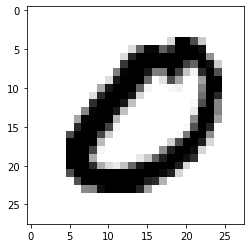

Example 958


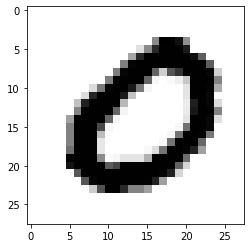

Example 959


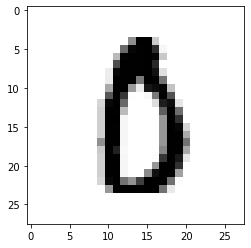

Example 960


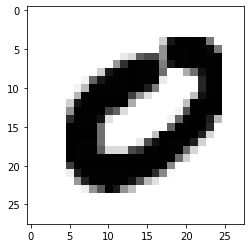

Example 961


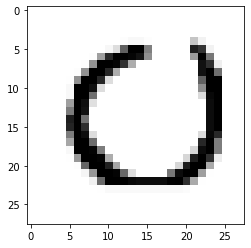

Example 962


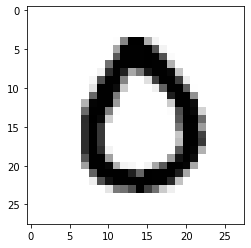

Example 963


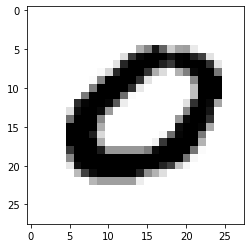

Example 964


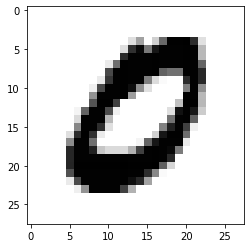

Example 965


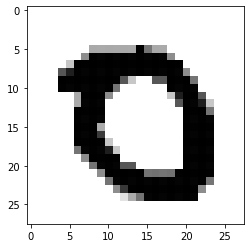

Example 966


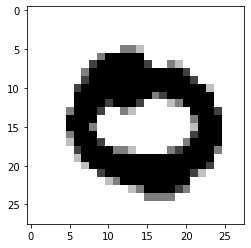

Example 967


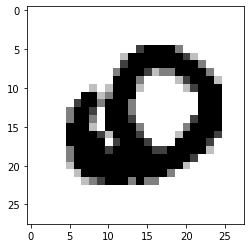

Example 968


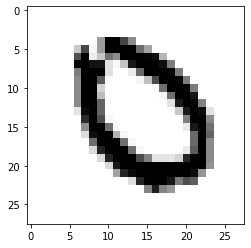

Example 969


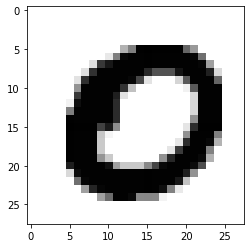

Example 970


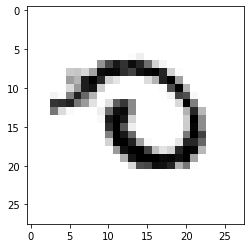

Example 971


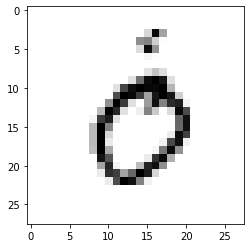

Example 972


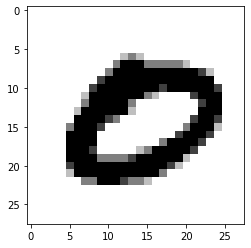

Example 973


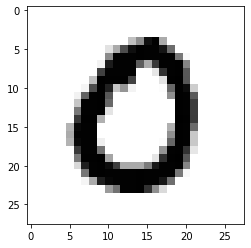

Example 974


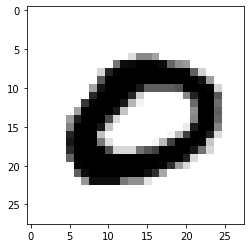

Example 975


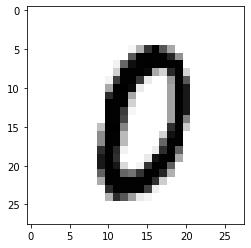

Example 976


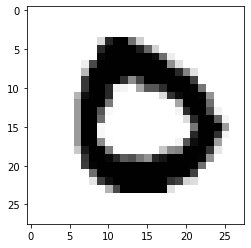

Example 977


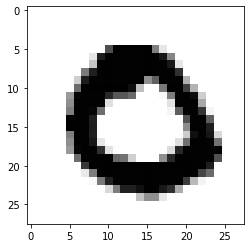

Example 978


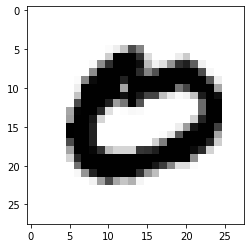

Example 979


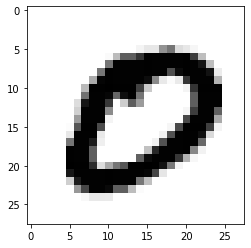

In [ ]:
#Digits.show(0)

## Exercise 3: Train a neural network to classify digits

**THIS EXERCISE SHOULD BE DONE IN A GROUP**

**TIME ESTIMATE: 20 minutes**

![](SciUML-neural.jpg)

Here we will build a neural network to identify digits. It will "train" on a separate, similar set of digit data (so that it can't cheat by knowing exactly what the right answer is).

NOTE: What do you think the sigificance of input_size and output_size is (remember from the introduction)?

This is a single layer linear neural net.  It is basically the simplest model you can construct. Given that this is the simplest model, how well do you think it is doing?

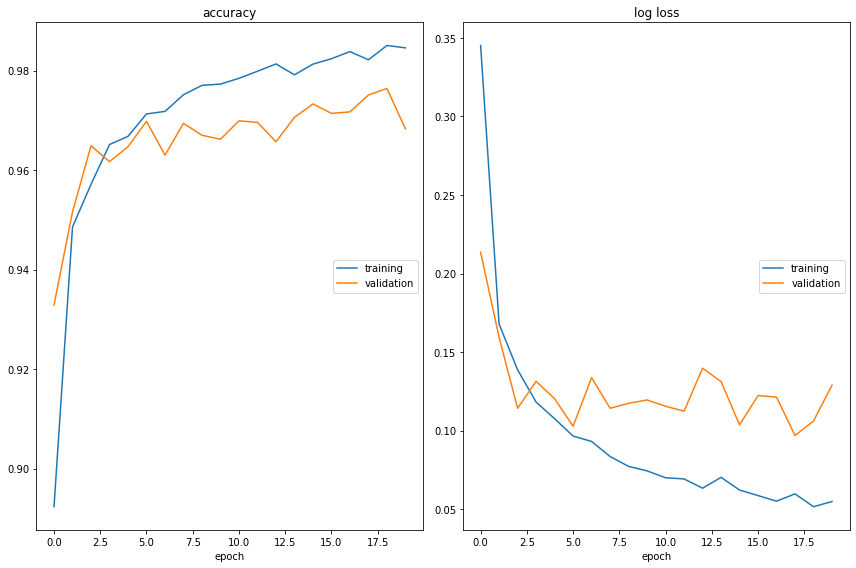

accuracy
	training         	 (min:    0.892, max:    0.985, cur:    0.985)
	validation       	 (min:    0.933, max:    0.976, cur:    0.968)
log loss
	training         	 (min:    0.052, max:    0.345, cur:    0.055)
	validation       	 (min:    0.097, max:    0.214, cur:    0.129)
took 269.0 seconds to run


In [ ]:
###Best Model .977
model = nn.Sequential(nn.Linear(input_size, 300),
                      nn.ReLU(),
                      nn.Linear(300,150),
                      nn.ReLU(),
                      nn.Linear(150,50),
                      nn.ReLU(),
                      nn.Linear(50, output_size),
                     )
##### Bestest model .978
# model = nn.Sequential(nn.Linear(input_size, 290),
#                       nn.ReLU(),
#                       nn.Linear(290,50),
#                       nn.ReLU(),
#                       nn.Linear(50,50),
#                       nn.ReLU(),
#                       nn.Linear(50,50),
#                       nn.ReLU(),
#                       nn.Linear(50,output_size),
#                      )


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
CUDA_LAUNCH_BLOCKING=1
start = time()
train_model(model, criterion, optimizer, num_epochs=20)
print("took %.1f seconds to run" % (time()-start))

### Test the model on your own
You can check any digit and any example to see what the neural net classifies the digit as

In [ ]:
Digits[9][1000].check_model(model)

You can also find all of the mistakes for a given digit by doing this (replace the number with any digit). Scroll all the way to the bottom to find the misclassification fraction for this digit.  Does this agree with your intuition? Did the neural net misclassify the ones you thought it would from your previous list?

In [ ]:
Digits.find_mistakes(model, 6)

## Exercise 4: Try repeating the above with new definitions of the neural net and see if you can improve your accuracy

**THIS EXERCISE SHOULD BE DONE IN A GROUP**

**TIME ESTIMATE: 30 minutes**

Repeat the previous exercise changing the neural net to see if you can improve your accuracy. Remember, the world's best is 99.8%!  Take careful notes about what networks you configure and what the accuracies are. Also record why you chose the choices you did.   You are free to choose all sorts of layer configurations, but remember the first layer has to start with input_size and the last layer has to end with output_size.  Talk through and justify your choices as a group and take notes!!  Remember from the intro matrial how neural nets require the size of the output of one layer to match the input size of the next layer



In [ ]:
model = nn.Sequential(nn.Linear(input_size, 16),
                      nn.ReLU(),
                      nn.Linear(16, 16),
                      nn.ReLU(),
                      nn.Linear(16, output_size),
                     )

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

start = time()
train_model(model, criterion, optimizer, num_epochs=20)
print("took %.1f seconds to run" % (time()-start))

### Bonus Exercise: Has the network actually learned what we expected?

**THIS EXERCISE SHOULD BE DONE IN A GROUP**

**TIME ESTIMATE: 1/2 Hour**
Remember the introductory materials, we were hoping that the network would be learning patterns/ edges, is it the case?  

This helper function will allow you to plot heatmaps of the activation values for neurons in the first hidden layer.

In [ ]:
def _plot_help(model,neuron_number):
    im=model[0].weight[neuron_number].cpu().detach().numpy().reshape(28,28)
    plt.imshow(im)
    return

In [ ]:
_plot_help(model,1)